# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 114.8 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=2025

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping


def map_variables_same_timeline(vars_list, time_identifiers_lst):
  """
  Creates a dictionary that maps each variable to its timeline.
  It will be useful for the feature drop on the testing set due to missing values.

  Args:
      vars_list: list of variable names to be analysed.
      time_identifiers_lst: list of timeline identifiers.

  Returns:
      A dictionary with feature names as keys and their timeline as values.
  """
  # dictionary to store the mapping
  temporal_mapping = {}

  # Assign each chronological variable to its timeline
  for time_id in time_identifiers_lst:
    temporal_cols = [col for col in vars_list if time_id in col]
    for col in temporal_cols:
      temporal_mapping[col] = time_id

  return temporal_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")

**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage. The implementation used for MissForest uses ExtraTrees instead of Random Forests in accordance with the suggestion from Scikit Learn as present in: https://scikit-learn.org/0.21/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed


def measure_temporal_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, temporal_vars_family,
  imputation_dict=None, num_feat=25, method='simple', encoded_vars_family=None,
  categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """
  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    print('original removed: ', original_removed)
    print('length original removed: ', len(original_removed))
    print('num feat: ', num_feat)
    print('i: ', i)
    print('length features importance list: ', len(features_importance_list))
    print('length removed: ', len(removed))
    print('')

    if features_importance_list[i] in removed:
      print('Feature already removed: ', features_importance_list[i])
      i = i+1
      continue
    focus_feature = features_importance_list[i]
    print("Removing feature: ", focus_feature)

    if focus_feature in temporal_vars_family.keys():
      timeline = temporal_vars_family[focus_feature]
      related_temporal_features = [k for k,v in temporal_vars_family.items() if v == timeline and k in X_test.columns]
      related_temporal_features = [feat for feat in related_temporal_features if feat not in removed]
    else:
      related_temporal_features = [focus_feature]

    for current_feature in related_temporal_features:
      print('Removing related temporal feature: ', current_feature)
      if encoded_vars_family is not None:
        # all the ohe variables derived from the original category should be set to missing
        if current_feature in encoded_vars_family.keys():
          original_feature = encoded_vars_family[current_feature]
          related_features = [k for k,v in encoded_vars_family.items() if v == original_feature and k in X_test.columns]
          # related features that are still in the model (e.g. logistic regression does not have all feat)
          related_features = [feat for feat in related_features if feat not in removed]
          print("Removing related features: ", related_features)
          removed.extend(related_features)
          original_removed.extend([original_feature])
          for feature in related_features:
            if method == 'simple':
              X_test_new[feature] = imputation_dict[feature]
        else:
          removed.extend([current_feature])
          original_removed.extend([current_feature])
          if method == 'simple':
            X_test_new[current_feature] = imputation_dict[current_feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Columns with zero variance, i.e. imputed:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    original_removed = list(set(original_removed))
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
variable_rename = {
    'ID': 'ID',
    'X1': 'LIMIT_BAL',
    'X2': 'SEX',
    'X3': 'EDUCATION',
    'X4': 'MARRIAGE',
    'X5': 'AGE',
    'X6': 'PAY_STATUS_1M_AGO',
    'X7': 'PAY_STATUS_2M_AGO',
    'X8': 'PAY_STATUS_3M_AGO',
    'X9': 'PAY_STATUS_4M_AGO',
    'X10': 'PAY_STATUS_5M_AGO',
    'X11': 'PAY_STATUS_6M_AGO',
    'X12': 'BILL_AMT_1M_AGO',
    'X13': 'BILL_AMT_2M_AGO',
    'X14': 'BILL_AMT_3M_AGO',
    'X15': 'BILL_AMT_4M_AGO',
    'X16': 'BILL_AMT_5M_AGO',
    'X17': 'BILL_AMT_6M_AGO',
    'X18': 'PAY_AMT_1M_AGO',
    'X19': 'PAY_AMT_2M_AGO',
    'X20': 'PAY_AMT_3M_AGO',
    'X21': 'PAY_AMT_4M_AGO',
    'X22': 'PAY_AMT_5M_AGO',
    'X23': 'PAY_AMT_6M_AGO',
    'Y': 'Target'
}

default_cc, default_cc_variables = load_data_from_ucimlrepo(350, variable_rename_dict=variable_rename)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [ ]:
default_cc.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_STATUS_1M_AGO  \
0      20000    2          2         1   24                  2   
1     120000    2          2         2   26                 -1   
2      90000    2          2         2   34                  0   
3      50000    2          2         1   37                  0   
4      50000    1          2         1   57                 -1   

   PAY_STATUS_2M_AGO  PAY_STATUS_3M_AGO  PAY_STATUS_4M_AGO  PAY_STATUS_5M_AGO  \
0                  2                 -1                 -1                 -2   
1                  2                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                 -1                  0                  0   

   ...  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
0  ...                0                0                0               0   
1  ...             3272             3455             3261               0   
2  ...            14331            14948            15549            1518   
3  ...            28314            28959            29547            2000   
4  ...            20940            19146            19131            2000   

   PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             689               0               0               0   
1            1000            1000            1000               0   
2            1500            1000            1000            1000   
3            2019            1200            1100            1069   
4           36681           10000            9000             689   

   PAY_AMT_6M_AGO  Target  
0               0       1  
1            2000       1  
2            5000       0  
3            1000       0  
4             679       0  

[5 rows x 24 columns]

In [ ]:
default_cc_variables

name     role     type      demographic  \
0                  ID       ID  Integer             None   
1           LIMIT_BAL  Feature  Integer             None   
2                 SEX  Feature  Integer              Sex   
3           EDUCATION  Feature  Integer  Education Level   
4            MARRIAGE  Feature  Integer   Marital Status   
5                 AGE  Feature  Integer              Age   
6   PAY_STATUS_1M_AGO  Feature  Integer             None   
7   PAY_STATUS_2M_AGO  Feature  Integer             None   
8   PAY_STATUS_3M_AGO  Feature  Integer             None   
9   PAY_STATUS_4M_AGO  Feature  Integer             None   
10  PAY_STATUS_5M_AGO  Feature  Integer             None   
11  PAY_STATUS_6M_AGO  Feature  Integer             None   
12    BILL_AMT_1M_AGO  Feature  Integer             None   
13    BILL_AMT_2M_AGO  Feature  Integer             None   
14    BILL_AMT_3M_AGO  Feature  Integer             None   
15    BILL_AMT_4M_AGO  Feature  Integer             None   
16    BILL_AMT_5M_AGO  Feature  Integer             None   
17    BILL_AMT_6M_AGO  Feature  Integer             None   
18     PAY_AMT_1M_AGO  Feature  Integer             None   
19     PAY_AMT_2M_AGO  Feature  Integer             None   
20     PAY_AMT_3M_AGO  Feature  Integer             None   
21     PAY_AMT_4M_AGO  Feature  Integer             None   
22     PAY_AMT_5M_AGO  Feature  Integer             None   
23     PAY_AMT_6M_AGO  Feature  Integer             None   
24             Target   Target   Binary             None   

                   description units missing_values  
0                         None  None             no  
1                    LIMIT_BAL  None             no  
2                          SEX  None             no  
3                    EDUCATION  None             no  
4                     MARRIAGE  None             no  
5                          AGE  None             no  
6                        PAY_0  None             no  
7                        PAY_2  None             no  
8                        PAY_3  None             no  
9                        PAY_4  None             no  
10                       PAY_5  None             no  
11                       PAY_6  None             no  
12                   BILL_AMT1  None             no  
13                   BILL_AMT2  None             no  
14                   BILL_AMT3  None             no  
15                   BILL_AMT4  None             no  
16                   BILL_AMT5  None             no  
17                   BILL_AMT6  None             no  
18                    PAY_AMT1  None             no  
19                    PAY_AMT2  None             no  
20                    PAY_AMT3  None             no  
21                    PAY_AMT4  None             no  
22                    PAY_AMT5  None             no  
23                    PAY_AMT6  None             no  
24  default payment next month  None             no

In [ ]:
default_cc.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_STATUS_1M_AGO',
       'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO',
       'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO', 'BILL_AMT_1M_AGO',
       'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO',
       'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO',
       'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO',
       'PAY_AMT_6M_AGO', 'Target'],
      dtype='object')

## Make feature names and feature values more human-interpretable

The dataset present categories that have no explanation in the original presentation of the dataset. After some research, it was possible to find additional explanation from the authors for these categories, which will be adopted.

- Original definition of the data: https://www.semanticscholar.org/paper/The-comparisons-of-data-mining-techniques-for-the-Yeh-Lien/1cacac4f0ea9fdff3cd88c151c94115a9fddcf33
- Additional explanation of the categories: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

In [ ]:
# Dictionaries for each categorical attribute
SEX = {
    1: 'male',
    2: 'female',
}

EDUCATION = {
    0: 'others',
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others',
    5: 'others',
    6: 'others'
}

MARRIAGE = {
    0: 'others',
    1: 'married',
    2: 'single',
    3: 'divorced'
}

PAY_STATUS = {
    -2: 'no consumption',
    -1: 'paid fully',
    0: 'revolving credit used'
}

# Dictionary mapping attributes to their respective mapping dictionaries
attribute_mappings = {
    'SEX': SEX,
    'EDUCATION': EDUCATION,
    'MARRIAGE': MARRIAGE,
    'PAY_STATUS_1M_AGO': PAY_STATUS,
    'PAY_STATUS_2M_AGO': PAY_STATUS,
    'PAY_STATUS_3M_AGO': PAY_STATUS,
    'PAY_STATUS_4M_AGO': PAY_STATUS,
    'PAY_STATUS_5M_AGO': PAY_STATUS,
    'PAY_STATUS_6M_AGO': PAY_STATUS
}

# Apply the mappings to the DataFrame:
for column, mapping in attribute_mappings.items():
    default_cc[column] = default_cc[column].map(lambda x: mapping.get(x, x))

default_cc.head()

LIMIT_BAL     SEX   EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0      20000  female  university  married   24                      2   
1     120000  female  university   single   26             paid fully   
2      90000  female  university   single   34  revolving credit used   
3      50000  female  university  married   37  revolving credit used   
4      50000    male  university  married   57             paid fully   

       PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0                      2             paid fully             paid fully   
1                      2  revolving credit used  revolving credit used   
2  revolving credit used  revolving credit used  revolving credit used   
3  revolving credit used  revolving credit used  revolving credit used   
4  revolving credit used             paid fully  revolving credit used   

       PAY_STATUS_5M_AGO  ... BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  \
0         no consumption  ...               0                0   
1  revolving credit used  ...            3272             3455   
2  revolving credit used  ...           14331            14948   
3  revolving credit used  ...           28314            28959   
4  revolving credit used  ...           20940            19146   

   BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  \
0                0               0             689               0   
1             3261               0            1000            1000   
2            15549            1518            1500            1000   
3            29547            2000            2019            1200   
4            19131            2000           36681           10000   

   PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  PAY_AMT_6M_AGO  Target  
0               0               0               0       1  
1            1000               0            2000       1  
2            1000            1000            5000       0  
3            1100            1069            1000       0  
4            9000             689             679       0  

[5 rows x 24 columns]

## Feature engineering

The features PAY_STATUS_xM_AGO have a different meaning if their value is a number (i.e. nr of months of delay in the payment) or if the value is a text (no delay in the payment).

So each PAY_STATUS_xM_AGO will result in two features:
- PAY_STATUS_xM_AGO: 'no consumption', 'paid fully', 'revolving credit used', 'payment overdue'
- PAY_DELAY_xM_AGO: 1, 2, ..., 9

In [ ]:
for col in default_cc.columns:
  if col.startswith('PAY_STATUS'):
    new_colname = col.replace('STATUS', 'DELAY')
    default_cc[new_colname] = default_cc[col].apply(lambda x: x if isinstance(x, (int, float)) else 0)
    default_cc[col] = default_cc[col].apply(lambda x: 'payment overdue' if isinstance(x, (int, float)) else x)

default_cc

LIMIT_BAL     SEX    EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0          20000  female   university  married   24        payment overdue   
1         120000  female   university   single   26             paid fully   
2          90000  female   university   single   34  revolving credit used   
3          50000  female   university  married   37  revolving credit used   
4          50000    male   university  married   57             paid fully   
...          ...     ...          ...      ...  ...                    ...   
29995     220000    male  high school  married   39  revolving credit used   
29996     150000    male  high school   single   43             paid fully   
29997      30000    male   university   single   37        payment overdue   
29998      80000    male  high school  married   41        payment overdue   
29999      50000    male   university  married   46  revolving credit used   

           PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0            payment overdue             paid fully             paid fully   
1            payment overdue  revolving credit used  revolving credit used   
2      revolving credit used  revolving credit used  revolving credit used   
3      revolving credit used  revolving credit used  revolving credit used   
4      revolving credit used             paid fully  revolving credit used   
...                      ...                    ...                    ...   
29995  revolving credit used  revolving credit used  revolving credit used   
29996             paid fully             paid fully             paid fully   
29997        payment overdue        payment overdue             paid fully   
29998             paid fully  revolving credit used  revolving credit used   
29999  revolving credit used  revolving credit used  revolving credit used   

           PAY_STATUS_5M_AGO  ... PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             no consumption  ...              0               0   
1      revolving credit used  ...           1000               0   
2      revolving credit used  ...           1000            1000   
3      revolving credit used  ...           1100            1069   
4      revolving credit used  ...           9000             689   
...                      ...  ...            ...             ...   
29995  revolving credit used  ...           3047            5000   
29996  revolving credit used  ...            129               0   
29997  revolving credit used  ...           4200            2000   
29998  revolving credit used  ...           1926           52964   
29999  revolving credit used  ...           1000            1000   

       PAY_AMT_6M_AGO  Target  PAY_DELAY_1M_AGO  PAY_DELAY_2M_AGO  \
0                   0       1                 2                 2   
1                2000       1                 0                 2   
2                5000       0                 0                 0   
3                1000       0                 0                 0   
4                 679       0                 0                 0   
...               ...     ...               ...               ...   
29995            1000       0                 0                 0   
29996               0       0                 0                 0   
29997            3100       1                 4                 3   
29998            1804       1                 1                 0   
29999            1000       1                 0                 0   

       PAY_DELAY_3M_AGO  PAY_DELAY_4M_AGO  PAY_DELAY_5M_AGO  PAY_DELAY_6M_AGO  
0                     0                 0                 0                 0  
1                     0                 0                 0                 2  
2                     0                 0                 0                 0  
3                     0                 0                 0                 0  
4                     0                 0                 0                 0  
...    

# **Split data in train and test set**

In [ ]:
default_cc_train, default_cc_test = train_test_split(
    default_cc, test_size=0.2, random_state=RANDOM_STATE, stratify=default_cc['Target']
)
default_cc_train['Target'].value_counts()

Target
0    18691
1     5309
Name: count, dtype: int64

## Variable encoding

In [ ]:
cat_variables = ['SEX', 'EDUCATION', 'MARRIAGE'] + [col for col in default_cc_train.columns if col.startswith('PAY_STATUS')]

if 'Target' in cat_variables:
  cat_variables.remove('Target')

print('Categorical variables: ', cat_variables)

# Apply the encoding function
default_cc_train_encoded, default_cc_ohe = one_hot_encoding(default_cc_train, cat_variables, encoder=None)
default_cc_test_encoded, _ = one_hot_encoding(default_cc_test, cat_variables, encoder=default_cc_ohe)

# move target variable to the end of the dataframe
X_vars = [col for col in default_cc_train_encoded.columns if col != 'Target']
default_cc_train_encoded = default_cc_train_encoded[X_vars + ['Target']]
default_cc_test_encoded = default_cc_test_encoded[X_vars + ['Target']]

default_cc_encoded_vars_family = map_encoded_variables_to_original(default_cc_train_encoded.columns, cat_variables)

Categorical variables:  ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO']


In [ ]:
default_cc_train_encoded.head()

LIMIT_BAL  AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  BILL_AMT_3M_AGO  \
2667      120000   38             6856            17329             2047   
25947     430000   29             2548            12020             2539   
27427     170000   32             2097                0                0   
7926      200000   30            15176             2693             6632   
15236      30000   26            30028            26208            28804   

       BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
2667              8568             8814            17180           19600   
25947             2250                0             2580           12082   
27427                0                0             6271               0   
7926                 0              734              584            2715   
15236            22335            17448            17448               0   

       PAY_AMT_2M_AGO  ...  PAY_STATUS_4M_AGO_paid fully  \
2667                0  ...                           1.0   
25947            2539  ...                           0.0   
27427               0  ...                           0.0   
7926             6632  ...                           0.0   
15236            3400  ...                           0.0   

       PAY_STATUS_4M_AGO_payment overdue  \
2667                                 0.0   
25947                                0.0   
27427                                0.0   
7926                                 0.0   
15236                                1.0   

       PAY_STATUS_4M_AGO_revolving credit used  PAY_STATUS_5M_AGO_paid fully  \
2667                                       0.0                           1.0   
25947                                      0.0                           0.0   
27427                                      0.0                           0.0   
7926                                       0.0                           1.0   
15236                                      0.0                           0.0   

       PAY_STATUS_5M_AGO_payment overdue  \
2667                                 0.0   
25947                                0.0   
27427                                0.0   
7926                                 0.0   
15236                                0.0   

       PAY_STATUS_5M_AGO_revolving credit used  PAY_STATUS_6M_AGO_paid fully  \
2667                                       0.0                           1.0   
25947                                      0.0                           0.0   
27427                                      0.0                           1.0   
7926                                       0.0                           0.0   
15236                                      1.0                           0.0   

       PAY_STATUS_6M_AGO_payment overdue  \
2667                                 0.0   
25947                                0.0   
27427                                0.0   
7926                                 1.0   
15236                                0.0   

       PAY_STATUS_6M_AGO_revolving credit used  Target  
2667                                       0.0       0  
25947                                      0.0       0  
27427                                      0.0       1  
7926                                       0.0       0  
15236                                      1.0       1  

[5 rows x 46 columns]

In [ ]:
default_cc_train_encoded.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment

In [ ]:
default_cc_encoded_vars_family

{'SEX_male': 'SEX',
 'EDUCATION_high school': 'EDUCATION',
 'EDUCATION_others': 'EDUCATION',
 'EDUCATION_university': 'EDUCATION',
 'MARRIAGE_married': 'MARRIAGE',
 'MARRIAGE_others': 'MARRIAGE',
 'MARRIAGE_single': 'MARRIAGE',
 'PAY_STATUS_1M_AGO_paid fully': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_5M_AGO_paid fully': 'PAY_STATUS_5M_AGO',
 'PAY_

Because this dataset has a chronologica factor, it will be interesting to measure the performance decay in terms of timeline feature disruption, i.e. what if the model in production does not have access to the most recent data (i.e. last month, last 2 months, ...)

In [ ]:
temporal_ids = [str(i+1)+'M_AGO' for i in range(6)]
default_cc_timeline_vars_family = map_variables_same_timeline(
    default_cc_train_encoded.columns, temporal_ids
)
default_cc_timeline_vars_family

{'BILL_AMT_1M_AGO': '1M_AGO',
 'PAY_AMT_1M_AGO': '1M_AGO',
 'PAY_DELAY_1M_AGO': '1M_AGO',
 'PAY_STATUS_1M_AGO_paid fully': '1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': '1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': '1M_AGO',
 'BILL_AMT_2M_AGO': '2M_AGO',
 'PAY_AMT_2M_AGO': '2M_AGO',
 'PAY_DELAY_2M_AGO': '2M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': '2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': '2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': '2M_AGO',
 'BILL_AMT_3M_AGO': '3M_AGO',
 'PAY_AMT_3M_AGO': '3M_AGO',
 'PAY_DELAY_3M_AGO': '3M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': '3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': '3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': '3M_AGO',
 'BILL_AMT_4M_AGO': '4M_AGO',
 'PAY_AMT_4M_AGO': '4M_AGO',
 'PAY_DELAY_4M_AGO': '4M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': '4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': '4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': '4M_AGO',
 'BILL_AMT_5M_AGO': '5M_AGO',
 'PAY_AMT_5M_AGO': '5M_AGO',
 

# **Data summary and quality**

In [ ]:
describe_data(default_cc_train_encoded)


Data dimension :
Number of Records :  24000 
Number of Features :  46

Datatype of Features :
float64    25
int64      21
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Number of duplicated records : 18

Data summary :
           LIMIT_BAL           AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  \
count   24000.000000  24000.000000     24000.000000     24000.000000   
mean   167535.153333     35.515083     51299.859083     49309.741958   
std    129594.714803      9.244674     73544.555313     71274.239603   
min     10000.000000     21.000000   -154973.000000    -69777.000000   
25%     50000.000000     28.000000      3620.000000      3051.500000   
50%    140000.000000     34.000000     22596.000000     21482.500000   
75%    240000.000000     41.000000     67265.500000     64031.500000   
max    800000.000000     79.000000    746814.000000    743970.000000   

       BILL_AMT_3M_AGO  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  \
count

# **Correlation**

In [ ]:
default_cc_train_encoded.dtypes

LIMIT_BAL                                    int64
AGE                                          int64
BILL_AMT_1M_AGO                              int64
BILL_AMT_2M_AGO                              int64
BILL_AMT_3M_AGO                              int64
BILL_AMT_4M_AGO                              int64
BILL_AMT_5M_AGO                              int64
BILL_AMT_6M_AGO                              int64
PAY_AMT_1M_AGO                               int64
PAY_AMT_2M_AGO                               int64
PAY_AMT_3M_AGO                               int64
PAY_AMT_4M_AGO                               int64
PAY_AMT_5M_AGO                               int64
PAY_AMT_6M_AGO                               int64
PAY_DELAY_1M_AGO                             int64
PAY_DELAY_2M_AGO                             int64
PAY_DELAY_3M_AGO                             int64
PAY_DELAY_4M_AGO                             int64
PAY_DELAY_5M_AGO                             int64
PAY_DELAY_6M_AGO                             int64
SEX_male                                   float64
EDUCATION_high school                      float64
EDUCATION_others                           float64
EDUCATION_university                       float64
MARRIAGE_married                           float64
MARRIAGE_others                            float64
MARRIAGE_single                            float64
PAY_STATUS_1M_AGO_paid fully               float64
PAY_STATUS_1M_AGO_payment overdue          float64
PAY_STATUS_1M_AGO_revolving credit used    float64
PAY_STATUS_2M_AGO_paid fully               float64
PAY_STATUS_2M_AGO_payment overdue          float64
PAY_STATUS_2M_AGO_revolving credit used    float64
PAY_STATUS_3M_AGO_paid fully               float64
PAY_STATUS_3M_AGO_payment overdue          float64
PAY_STATUS_3M_AGO_revolving credit used    float64
PAY_STATUS_4M_AGO_paid fully               float64
PAY_STATUS_4M_AGO_payment overdue          float64
PAY_STATUS_4M_AGO_revolving credit used    float64
PAY_STATUS_5M_AGO_paid fully               float64
PAY_STATUS_5M_AGO_payment overdue          float64
PAY_STATUS_5M_AGO_revolving credit used    float64
PAY_STATUS_6M_AGO_paid fully               float64
PAY_STATUS_6M_AGO_payment overdue          float64
PAY_STATUS_6M_AGO_revolving credit used    float64
Target                                       int64
dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

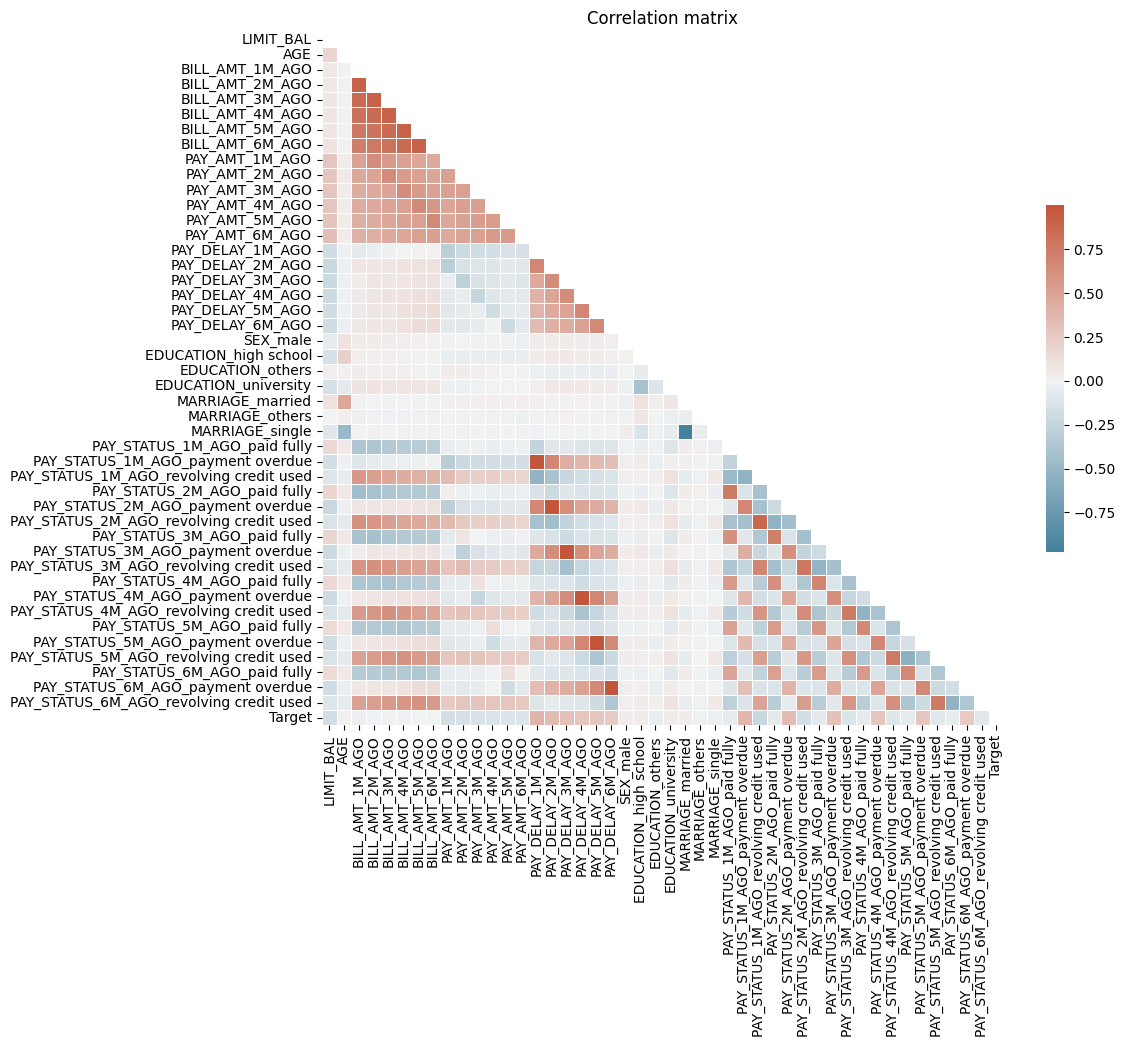

In [ ]:
default_cc_corr = calculate_correlation(default_cc_train_encoded, 'spearman') #, variables_for_correlation)

In [ ]:
abs(default_cc_corr['Target']).sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.393065
PAY_STATUS_1M_AGO_payment overdue          0.370192
PAY_DELAY_2M_AGO                           0.344422
PAY_STATUS_2M_AGO_payment overdue          0.343893
PAY_DELAY_3M_AGO                           0.301715
PAY_STATUS_3M_AGO_payment overdue          0.300965
PAY_DELAY_4M_AGO                           0.281333
PAY_STATUS_4M_AGO_payment overdue          0.280206
PAY_DELAY_5M_AGO                           0.272405
PAY_STATUS_5M_AGO_payment overdue          0.271409
PAY_DELAY_6M_AGO                           0.245625
PAY_STATUS_6M_AGO_payment overdue          0.244220
PAY_STATUS_1M_AGO_revolving credit used    0.222784
LIMIT_BAL                                  0.169676
PAY_AMT_1M_AGO                             0.163213
PAY_STATUS_2M_AGO_revolving credit used    0.162810
PAY_AMT_2M_AGO                             0.154690
PAY_AMT_3M_AGO                             0.145890
PAY_AMT_4M_AGO                             0.132393
PAY_AMT_6M_AGO                             0.125179
PAY_STATUS_3M_AGO_revolving credit used    0.124042
PAY_AMT_5M_AGO                             0.119254
PAY_STATUS_4M_AGO_revolving credit used    0.104079
PAY_STATUS_5M_AGO_revolving credit used    0.092145
PAY_STATUS_6M_AGO_revolving credit used    0.088379
PAY_STATUS_3M_AGO_paid fully               0.075515
PAY_STATUS_2M_AGO_paid fully               0.071266
PAY_STATUS_4M_AGO_paid fully               0.069586
PAY_STATUS_5M_AGO_paid fully               0.064468
PAY_STATUS_1M_AGO_paid fully               0.058158
PAY_STATUS_6M_AGO_paid fully               0.054579
EDUCATION_others                           0.047144
EDUCATION_university                       0.038595
SEX_male                                   0.038067
EDUCATION_high school                      0.031188
MARRIAGE_single                            0.029251
MARRIAGE_married                           0.028707
BILL_AMT_1M_AGO                            0.027420
BILL_AMT_2M_AGO                            0.017301
BILL_AMT_3M_AGO                            0.014297
MARRIAGE_others                            0.012623
BILL_AMT_4M_AGO                            0.011205
BILL_AMT_5M_AGO                            0.009867
AGE                                        0.004769
BILL_AMT_6M_AGO                            0.003652
Name: Target, dtype: float64

df columns:  Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4

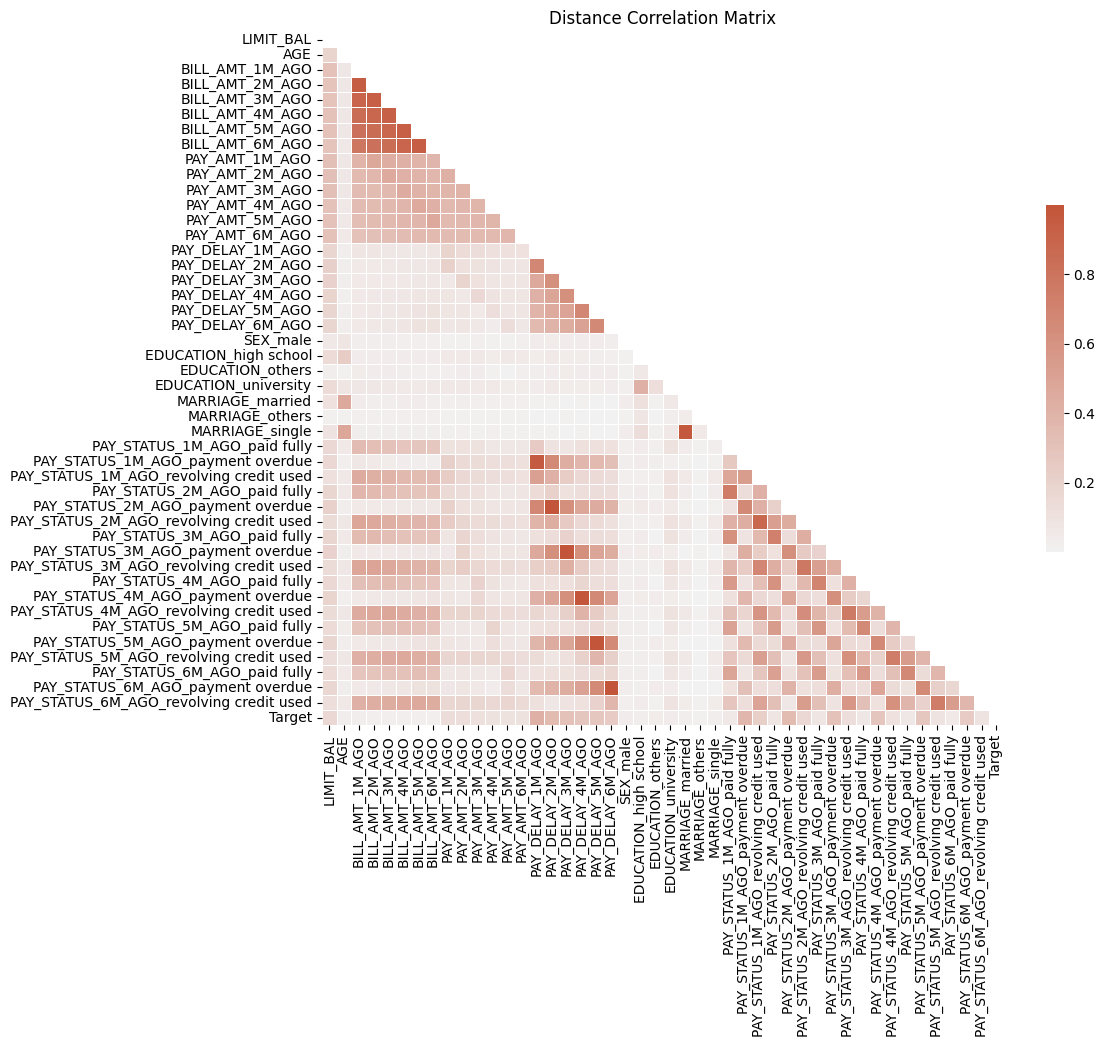

In [ ]:
default_cc_dist_corr = calculate_distance_correlation_matrix(default_cc_train_encoded)

In [ ]:
default_cc_dist_corr['Target'].sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.408891
PAY_STATUS_1M_AGO_payment overdue          0.370192
PAY_DELAY_2M_AGO                           0.344593
PAY_STATUS_2M_AGO_payment overdue          0.343893
PAY_DELAY_3M_AGO                           0.301220
PAY_STATUS_3M_AGO_payment overdue          0.300965
PAY_DELAY_4M_AGO                           0.280710
PAY_STATUS_4M_AGO_payment overdue          0.280206
PAY_DELAY_5M_AGO                           0.271967
PAY_STATUS_5M_AGO_payment overdue          0.271409
PAY_DELAY_6M_AGO                           0.245190
PAY_STATUS_6M_AGO_payment overdue          0.244220
PAY_STATUS_1M_AGO_revolving credit used    0.222784
PAY_STATUS_2M_AGO_revolving credit used    0.162810
LIMIT_BAL                                  0.157119
PAY_AMT_1M_AGO                             0.125812
PAY_AMT_2M_AGO                             0.124435
PAY_STATUS_3M_AGO_revolving credit used    0.124042
PAY_AMT_3M_AGO                             0.110408
PAY_STATUS_4M_AGO_revolving credit used    0.104079
PAY_AMT_4M_AGO                             0.100163
PAY_AMT_5M_AGO                             0.095468
PAY_AMT_6M_AGO                             0.094972
PAY_STATUS_5M_AGO_revolving credit used    0.092145
PAY_STATUS_6M_AGO_revolving credit used    0.088379
PAY_STATUS_3M_AGO_paid fully               0.075515
PAY_STATUS_2M_AGO_paid fully               0.071266
PAY_STATUS_4M_AGO_paid fully               0.069586
PAY_STATUS_5M_AGO_paid fully               0.064468
PAY_STATUS_1M_AGO_paid fully               0.058158
PAY_STATUS_6M_AGO_paid fully               0.054579
EDUCATION_others                           0.047144
EDUCATION_university                       0.038595
SEX_male                                   0.038067
EDUCATION_high school                      0.031188
MARRIAGE_single                            0.029251
BILL_AMT_1M_AGO                            0.029235
MARRIAGE_married                           0.028707
AGE                                        0.027026
BILL_AMT_2M_AGO                            0.023847
BILL_AMT_3M_AGO                            0.021764
BILL_AMT_4M_AGO                            0.019649
BILL_AMT_5M_AGO                            0.018590
BILL_AMT_6M_AGO                            0.016757
MARRIAGE_others                            0.012623
Name: Target, dtype: float64

# **Pre-feature selection + Remove intercorrelated features**
Features with zero-variance will be dropped. In this scenario, intercorrelated features will be dropped as well with only one of the pair remaining.

The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
filtered_features = filter_out_intercorrelated_features(default_cc_dist_corr, 'Target', 0.8)

appended feature:  PAY_DELAY_1M_AGO
eliminated feature:  PAY_STATUS_1M_AGO_payment overdue 0.9603579952219865
appended feature:  PAY_DELAY_2M_AGO
eliminated feature:  PAY_STATUS_2M_AGO_payment overdue 0.9974995350422445
appended feature:  PAY_DELAY_3M_AGO
eliminated feature:  PAY_STATUS_3M_AGO_payment overdue 0.9984579871108346
appended feature:  PAY_DELAY_4M_AGO
eliminated feature:  PAY_STATUS_4M_AGO_payment overdue 0.9977613943439647
appended feature:  PAY_DELAY_5M_AGO
eliminated feature:  PAY_STATUS_5M_AGO_payment overdue 0.9973790509201896
appended feature:  PAY_DELAY_6M_AGO
eliminated feature:  PAY_STATUS_6M_AGO_payment overdue 0.9980350932435607
appended feature:  PAY_STATUS_1M_AGO_revolving credit used
eliminated feature:  PAY_STATUS_2M_AGO_revolving credit used 0.8754640075186755
appended feature:  LIMIT_BAL
appended feature:  PAY_AMT_1M_AGO
appended feature:  PAY_AMT_2M_AGO
appended feature:  PAY_STATUS_3M_AGO_revolving credit used
appended feature:  PAY_AMT_3M_AGO
appended fe

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

default_cc_zero_variance_columns = identify_zero_variance_columns(default_cc_train_encoded[filtered_features])

if DROP_WEAK_FEATURES:
  default_cc_weak_features = identify_weak_associated_features(
      default_cc_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  default_cc_weak_features = []

remove_columns = set(default_cc_zero_variance_columns + default_cc_weak_features)
remove_columns = [col for col in remove_columns if col in filtered_features]
print(remove_columns)

default_cc_train = default_cc_train_encoded[filtered_features + ['Target']].drop(columns=remove_columns)
default_cc_test = default_cc_test_encoded[filtered_features + ['Target']].drop(columns=remove_columns)

Variance of each column:
PAY_DELAY_1M_AGO                           5.743928e-01
PAY_DELAY_2M_AGO                           6.458192e-01
PAY_DELAY_3M_AGO                           6.318367e-01
PAY_DELAY_4M_AGO                           5.835756e-01
PAY_DELAY_5M_AGO                           5.167945e-01
PAY_DELAY_6M_AGO                           5.197415e-01
PAY_STATUS_1M_AGO_revolving credit used    2.499719e-01
LIMIT_BAL                                  1.679479e+10
PAY_AMT_1M_AGO                             2.731437e+08
PAY_AMT_2M_AGO                             5.902438e+08
PAY_STATUS_3M_AGO_revolving credit used    2.493300e-01
PAY_AMT_3M_AGO                             2.969637e+08
PAY_STATUS_4M_AGO_revolving credit used    2.475683e-01
PAY_AMT_4M_AGO                             2.534763e+08
PAY_AMT_5M_AGO                             2.287609e+08
PAY_AMT_6M_AGO                             3.138079e+08
PAY_STATUS_5M_AGO_revolving credit used    2.456046e-01
PAY_STATUS_6M_AGO_revol

In [ ]:
default_cc_train.head()

PAY_DELAY_1M_AGO  PAY_DELAY_2M_AGO  PAY_DELAY_3M_AGO  PAY_DELAY_4M_AGO  \
2667                0.0               0.0               2.0               0.0   
25947               0.0               0.0               0.0               0.0   
27427               2.0               2.0               0.0               0.0   
7926                0.0               0.0               0.0               0.0   
15236               2.0               2.0               2.0               2.0   

       PAY_DELAY_5M_AGO  PAY_DELAY_6M_AGO  \
2667                0.0               0.0   
25947               0.0               0.0   
27427               0.0               0.0   
7926                0.0               2.0   
15236               0.0               0.0   

       PAY_STATUS_1M_AGO_revolving credit used  LIMIT_BAL  PAY_AMT_1M_AGO  \
2667                                       0.0   120000.0         19600.0   
25947                                      0.0   430000.0         12082.0   
27427                                      0.0   170000.0             0.0   
7926                                       0.0   200000.0          2715.0   
15236                                      0.0    30000.0             0.0   

       PAY_AMT_2M_AGO  ...  EDUCATION_others  EDUCATION_university  SEX_male  \
2667              0.0  ...               0.0                   0.0       0.0   
25947          2539.0  ...               0.0                   1.0       0.0   
27427             0.0  ...               0.0                   0.0       1.0   
7926           6632.0  ...               0.0                   0.0       1.0   
15236          3400.0  ...               0.0                   1.0       0.0   

       EDUCATION_high school  MARRIAGE_single  BILL_AMT_1M_AGO   AGE  \
2667                     0.0              0.0           6856.0  38.0   
25947                    0.0              1.0           2548.0  29.0   
27427                    0.0              1.0           2097.0  32.0   
7926                     0.0              1.0          15176.0  30.0   
15236                    0.0              1.0          30028.0  26.0   

       BILL_AMT_6M_AGO  MARRIAGE_others  Target  
2667           17180.0              0.0     0.0  
25947           2580.0              0.0     0.0  
27427           6271.0              0.0     1.0  
7926             584.0              0.0     0.0  
15236          17448.0              0.0     1.0  

[5 rows x 34 columns]

In [ ]:
print('Original number of features: ', len(default_cc.columns))
print('Number of features after pre-feature selection: ', len(default_cc_train.columns))

Original number of features:  30
Number of features after pre-feature selection:  34


# **Imbalanced dataset**

In [ ]:
X_train = default_cc_train.drop('Target', axis=1)
y_train = default_cc_train['Target']

X_test = default_cc_test.drop('Target', axis=1)
y_test = default_cc_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0     18691    0.778792
1.0      5309    0.221208

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
default_cc_imputation_values_dict = calculate_imputation_values_for_missing(
    default_cc_train
)
default_cc_imputation_values_dict

{'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'PAY_STATUS_1M_AGO_revolving credit used': 0.0,
 'LIMIT_BAL': 140000.0,
 'PAY_AMT_1M_AGO': 2100.0,
 'PAY_AMT_2M_AGO': 2011.0,
 'PAY_STATUS_3M_AGO_revolving credit used': 1.0,
 'PAY_AMT_3M_AGO': 1806.0,
 'PAY_STATUS_4M_AGO_revolving credit used': 1.0,
 'PAY_AMT_4M_AGO': 1500.0,
 'PAY_AMT_5M_AGO': 1500.0,
 'PAY_AMT_6M_AGO': 1500.0,
 'PAY_STATUS_5M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_6M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_3M_AGO_paid fully': 0.0,
 'PAY_STATUS_2M_AGO_paid fully': 0.0,
 'PAY_STATUS_4M_AGO_paid fully': 0.0,
 'PAY_STATUS_5M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'PAY_STATUS_6M_AGO_paid fully': 0.0,
 'EDUCATION_others': 0.0,
 'EDUCATION_university': 0.0,
 'SEX_male': 0.0,
 'EDUCATION_high school': 0.0,
 'MARRIAGE_single': 1.0,
 'BILL_AMT_1M_AGO': 22596.0,
 'AGE': 34.0,
 'BILL_AMT_6

In [ ]:
default_cc_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
default_cc_cat_vars

['PAY_STATUS_1M_AGO_revolving credit used',
 'PAY_STATUS_3M_AGO_revolving credit used',
 'PAY_STATUS_4M_AGO_revolving credit used',
 'PAY_STATUS_5M_AGO_revolving credit used',
 'PAY_STATUS_6M_AGO_revolving credit used',
 'PAY_STATUS_3M_AGO_paid fully',
 'PAY_STATUS_2M_AGO_paid fully',
 'PAY_STATUS_4M_AGO_paid fully',
 'PAY_STATUS_5M_AGO_paid fully',
 'PAY_STATUS_1M_AGO_paid fully',
 'PAY_STATUS_6M_AGO_paid fully',
 'EDUCATION_others',
 'EDUCATION_university',
 'SEX_male',
 'EDUCATION_high school',
 'MARRIAGE_single',
 'MARRIAGE_others']

In [ ]:
# Maximum number of original features (after feature engineering) to be imputed
NUM_FEAT = 20

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [5],
    'min_samples_split': [0.05],
    'min_samples_leaf': [0.005]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 18:10:23.044105

Nested Cross-validation Results:
Individual scores: [0.5273343  0.53385827 0.52052589]
Average nested CV score: 0.527 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.527
2025-01-18 18:10:23.785967

Execution time: 0.01 minutes


```
Starting hyperparameter tuning at: 2025-01-17 16:49:47.515581

Nested Cross-validation Results:
Individual scores: [0.52109065 0.53555138 0.52027586]
Average nested CV score: 0.526 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.527
2025-01-17 16:50:27.396209

Execution time: 0.66 minutes
```


In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0               PAY_DELAY_1M_AGO    0.116675  0.002975
3               PAY_DELAY_4M_AGO    0.040144  0.001055
1               PAY_DELAY_2M_AGO    0.018473  0.000342
20  PAY_STATUS_4M_AGO_paid fully    0.014658  0.001161
4               PAY_DELAY_5M_AGO    0.014256  0.001719
8                 PAY_AMT_1M_AGO    0.010922  0.002863
9                 PAY_AMT_2M_AGO    0.005803  0.001274

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

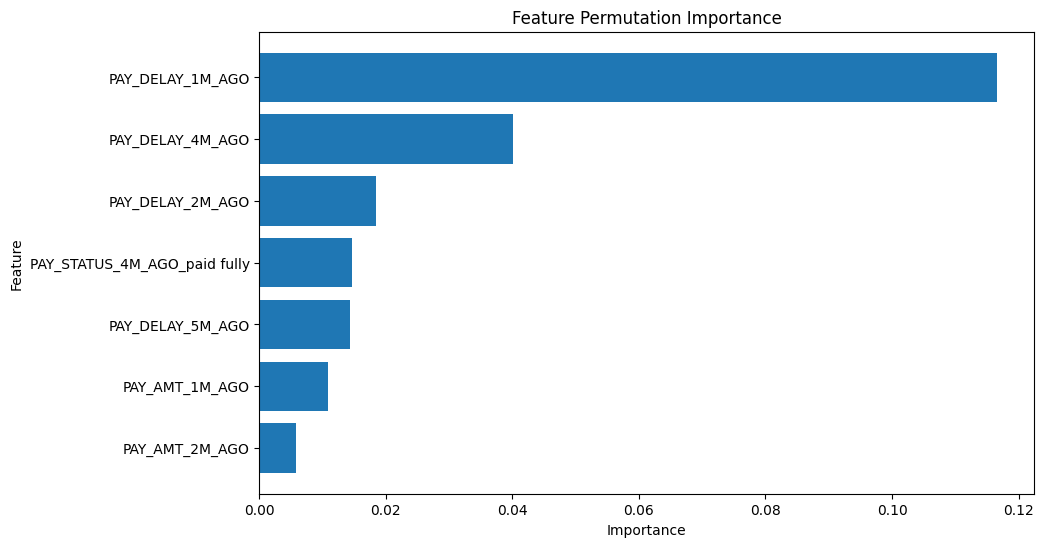

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_paid fully
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_5M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_DELAY_5M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'

In [ ]:
dt_orig_missing

['PAY_DELAY_1M_AGO',
 'PAY_DELAY_4M_AGO',
 'PAY_DELAY_2M_AGO',
 'PAY_STATUS_4M_AGO',
 'PAY_DELAY_5M_AGO',
 'PAY_AMT_1M_AGO',
 'PAY_AMT_2M_AGO',
 'EDUCATION',
 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_5M_AGO',
 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_6M_AGO',
 'SEX',
 'MARRIAGE',
 'BILL_AMT_1M_AGO',
 'PAY_STATUS_3M_AGO',
 'BILL_AMT_6M_AGO',
 'AGE',
 'PAY_DELAY_6M_AGO',
 'PAY_AMT_6M_AGO']

In [ ]:
len(dt_missing)

28

In [ ]:
dt_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   728  3895  778   599      48.34   54.86        83.35     77.05     51.39   
1   482  4179  494   845      49.39   36.32        89.43     77.68     41.86   
2   280  4392  281  1047      49.91   21.10        93.99     77.87     29.66   
3   151  4542  131  1176      53.55   11.38        97.20     78.22     18.77   
4   151  4542  131  1176      53.55   11.38        97.20     78.22     18.77   
5     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.11                 0   
1               62.88                 1   
2               57.54                 2   
3               54.29                 3   
4               54.29                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:10:37.638247

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
dt_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   728  3895  778   599      48.34   54.86        83.35     77.05     51.39   
1   619  3965  708   708      46.65   46.65        84.85     76.40     46.65   
2   585  4037  636   742      47.91   44.08        86.39     77.03     45.92   
3   411  4222  451   916      47.68   30.97        90.35     77.22     37.55   
4   413  4220  453   914      47.69   31.12        90.31     77.22     37.67   
5   208  4384  289  1119      41.85   15.67        93.82     76.53     22.81   
6   139  4491  182  1188      43.30   10.47        96.11     77.17     16.87   
7   132  4519  154  1195      46.15    9.95        96.70     77.52     16.37   
8   132  4519  154  1195      46.15    9.95        96.70     77.52     16.37   
9   132  4519  154  1195      46.15    9.95        96.70     77.52     16.37   
10  132  4519  154  1195      46.15    9.95        96.70     77.52     16.37   
11  132  4519  154  1195      46.15    9.95        96.70     77.52     16.37   
12  132  4519  154  1195      46.15    9.95        96.70     77.52     16.37   
13  132  4519  154  1195      46.15    9.95        96.70     77.52     16.37   
14  132  4519  154  1195      46.15    9.95        96.70     77.52     16.37   
15  116  4541  132  1211      46.77    8.74        97.18     77.62     14.73   
16  116  4541  132  1211      46.77    8.74        97.18     77.62     14.73   
17  122  4539  134  1205      47.66    9.19        97.13     77.68     15.41   
18  109  4538  135  1218      44.67    8.21        97.11     77.45     13.88   
19  101  4550  123  1226      45.09    7.61        97.37     77.52     13.02   
20  112  4544  129  1215      46.47    8.44        97.24     77.60     14.29   

    balanced_accuracy  num_feat_missing  \
0               69.11                 0   
1               65.75                 1   
2               65.24                 2   
3               60.66                 3   
4               60.71                 4   
5               54.74                 5   
6               53.29                 6   
7               53.33                 7   
8               53.33                 8   
9               53.33                 9   
10              53.33                10   
11              53.33                11   
12              53.33                12   
13              53.33                13   
14              53.33                14   
15              52.96                15   
16              52.96                16   
17              53.16                17   
18              52.66                18   
19              52.49                19   
20              52.84                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
dt_perf_temp, dt_orig_missing_temp, dt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
dt_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  728  3895  778   599      48.34   54.86        83.35     77.05     51.39   
1  482  4179  494   845      49.39   36.32        89.43     77.68     41.86   
2  280  4392  281  1047      49.91   21.10        93.99     77.87     29.66   
3    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.11                 0   
1              62.88                 4   
2              57.54                 7   
3              50.00                10   
4              50.00                13   
5              50.00                14   
6              50.00                18   
7              50.00                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_temp_mf, dt_orig_missing_temp_mf, dt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:15:10.310505

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
dt_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  728  3895  778   599      48.34   54.86        83.35     77.05     51.39   
1  518  4145  528   809      49.52   39.04        88.70     77.72     43.66   
2  501  4181  492   826      50.45   37.75        89.47     78.03     43.19   
3  338  4374  299   989      53.06   25.47        93.60     78.53     34.42   
4  113  4543  130  1214      46.50    8.52        97.22     77.60     14.39   
5  113  4543  130  1214      46.50    8.52        97.22     77.60     14.39   
6  149  4512  161  1178      48.06   11.23        96.55     77.68     18.20   
7  149  4512  161  1178      48.06   11.23        96.55     77.68     18.20   
8  149  4512  161  1178      48.06   11.23        96.55     77.68     18.20   

   balanced_accuracy  num_feat_missing  \
0              69.11                 0   
1              63.87                 4   
2              63.61                 7   
3              59.54                10   
4              52.87                13   
5              52.87                14   
6              53.89                18   
7              53.89                19   
8              53.89                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [300],
      'max_features': ['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 18:16:57.377067

Nested Cross-validation Results:
Individual scores: [0.55783036 0.54716501 0.53598775]
Average nested CV score: 0.547 (+/- 0.018)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.550
2025-01-18 19:28:41.404715

Execution time: 71.73 minutes



```
Starting hyperparameter tuning at: 2025-01-18 18:16:57.377067

Nested Cross-validation Results:
Individual scores: [0.55783036 0.54716501 0.53598775]
Average nested CV score: 0.547 (+/- 0.018)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.550
2025-01-18 19:28:41.404715

Execution time: 71.73 minutes
```

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.084420  0.001728
13                           PAY_AMT_4M_AGO    0.024982  0.001049
8                            PAY_AMT_1M_AGO    0.022410  0.001348
11                           PAY_AMT_3M_AGO    0.022076  0.001711
9                            PAY_AMT_2M_AGO    0.021138  0.000769
29                          BILL_AMT_1M_AGO    0.020993  0.000671
7                                 LIMIT_BAL    0.020812  0.000920
31                          BILL_AMT_6M_AGO    0.015903  0.000940
15                           PAY_AMT_6M_AGO    0.015153  0.001487
14                           PAY_AMT_5M_AGO    0.012504  0.001709
30                                      AGE    0.009308  0.000840
1                          PAY_DELAY_2M_AGO    0.007853  0.000930
2                          PAY_DELAY_3M_AGO    0.006303  0.000896
6   PAY_STATUS_1M_AGO_revolving credit used    0.006273  0.001450
18             PAY_STATUS_3M_AGO_paid fully    0.004557  0.000678
10  PAY_STATUS_3M_AGO_revolving credit used    0.003960  0.000435
25                     EDUCATION_university    0.003844  0.000423
28                          MARRIAGE_single    0.003649  0.000584
3                          PAY_DELAY_4M_AGO    0.003438  0.000944
23             PAY_STATUS_6M_AGO_paid fully    0.003179  0.000444
17  PAY_STATUS_6M_AGO_revolving credit used    0.003071  0.000750
19             PAY_STATUS_2M_AGO_paid fully    0.002999  0.000273
16  PAY_STATUS_5M_AGO_revolving credit used    0.002805  0.000626
20             PAY_STATUS_4M_AGO_paid fully    0.002691  0.000232
22             PAY_STATUS_1M_AGO_paid fully    0.002498  0.000656
4                          PAY_DELAY_5M_AGO    0.002327  0.001009
26                                 SEX_male    0.002104  0.000463
21             PAY_STATUS_5M_AGO_paid fully    0.002069  0.000202
12  PAY_STATUS_4M_AGO_revolving credit used    0.002036  0.000469
24                         EDUCATION_others    0.001195  0.000285
27                    EDUCATION_high school    0.001154  0.000204
5                          PAY_DELAY_6M_AGO    0.000588  0.000546
32                          MARRIAGE_others    0.000076  0.000048

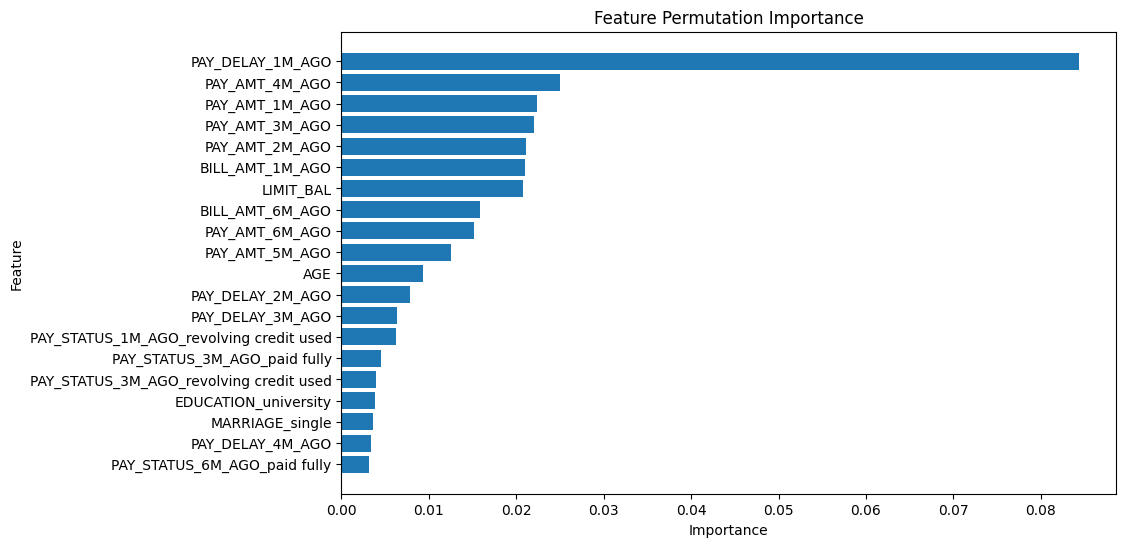

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_2M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat remove

In [ ]:
rf_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   794  3846  827   533      48.98   59.83        82.30     77.33     53.87   
1   658  3974  699   669      48.49   49.59        85.04     77.20     49.03   
2   582  4108  565   745      50.74   43.86        87.91     78.17     47.05   
3   556  4146  527   771      51.34   41.90        88.72     78.37     46.14   
4   531  4183  490   796      52.01   40.02        89.51     78.57     45.23   
5   535  4182  491   792      52.14   40.32        89.49     78.62     45.47   
6   517  4203  470   810      52.38   38.96        89.94     78.67     44.68   
7   479  4261  412   848      53.76   36.10        91.18     79.00     43.19   
8   475  4266  407   852      53.85   35.80        91.29     79.02     43.01   
9   469  4285  388   858      54.73   35.34        91.70     79.23     42.95   
10  455  4296  377   872      54.69   34.29        91.93     79.18     42.15   
11  455  4296  377   872      54.69   34.29        91.93     79.18     42.15   
12  365  4385  288   962      55.90   27.51        93.84     79.17     36.87   
13  295  4478  195  1032      60.20   22.23        95.83     79.55     32.47   
14  305  4448  225  1022      57.55   22.98        95.19     79.22     32.85   
15  305  4445  228  1022      57.22   22.98        95.12     79.17     32.80   
16  305  4447  226  1022      57.44   22.98        95.16     79.20     32.83   
17  305  4448  225  1022      57.55   22.98        95.19     79.22     32.85   
18  254  4496  177  1073      58.93   19.14        96.21     79.17     28.90   
19  253  4501  172  1074      59.53   19.07        96.32     79.23     28.88   
20  254  4494  179  1073      58.66   19.14        96.17     79.13     28.86   

    balanced_accuracy  num_feat_missing  \
0               71.07                 0   
1               67.31                 1   
2               65.88                 2   
3               65.31                 3   
4               64.76                 4   
5               64.90                 5   
6               64.45                 6   
7               63.64                 7   
8               63.54                 8   
9               63.52                 9   
10              63.11                10   
11              63.11                11   
12              60.67                12   
13              59.03                13   
14              59.08                14   
15              59.05                15   
16              59.07                16   
17              59.08                17   
18              57.68                18   
19              57.69                19   
20              57.66                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2      ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
4   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
5   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
6   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
7   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
8   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
9   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
10  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
11  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
12  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
13  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
14  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
15  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
16  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
17  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
18  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
19  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
20  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:29:15.306664

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
rf_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   794  3846  827   533      48.98   59.83        82.30     77.33     53.87   
1   690  3897  776   637      47.07   52.00        83.39     76.45     49.41   
2   651  3948  725   676      47.31   49.06        84.49     76.65     48.17   
3   588  4099  574   739      50.60   44.31        87.72     78.12     47.25   
4   555  4157  516   772      51.82   41.82        88.96     78.53     46.29   
5   558  4160  513   769      52.10   42.05        89.02     78.63     46.54   
6   542  4188  485   785      52.78   40.84        89.62     78.83     46.05   
7   536  4176  497   791      51.89   40.39        89.36     78.53     45.42   
8   552  4152  521   775      51.44   41.60        88.85     78.40     46.00   
9   556  4160  513   771      52.01   41.90        89.02     78.60     46.41   
10  559  4151  522   768      51.71   42.13        88.83     78.50     46.43   
11  561  4146  527   766      51.56   42.28        88.72     78.45     46.46   
12  376  4371  302   951      55.46   28.33        93.54     79.12     37.51   
13  300  4470  203  1027      59.64   22.61        95.66     79.50     32.79   
14  278  4479  194  1049      58.90   20.95        95.85     79.28     30.91   
15  275  4484  189  1052      59.27   20.72        95.96     79.32     30.71   
16  275  4484  189  1052      59.27   20.72        95.96     79.32     30.71   
17  275  4485  188  1052      59.40   20.72        95.98     79.33     30.73   
18   45  4639   34  1282      56.96    3.39        99.27     78.07      6.40   
19   45  4639   34  1282      56.96    3.39        99.27     78.07      6.40   
20   45  4639   34  1282      56.96    3.39        99.27     78.07      6.40   

    balanced_accuracy  num_feat_missing  \
0               71.07                 0   
1               67.70                 1   
2               66.77                 2   
3               66.01                 3   
4               65.39                 4   
5               65.54                 5   
6               65.23                 6   
7               64.88                 7   
8               65.22                 8   
9               65.46                 9   
10              65.48                10   
11              65.50                11   
12              60.94                12   
13              59.13                13   
14              58.40                14   
15              58.34                15   
16              58.34                16   
17              58.35                17   
18              51.33                18   
19              51.33                19   
20              51.33                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2      ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
4   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
5   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
6   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
7   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
8   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
9   ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
10  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
11  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
12  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
13  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
14  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
15  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
16  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
17  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
18  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
19  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...  
20  ['PAY_DELAY_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AM...

In [ ]:
rf_perf_temp, rf_orig_missing_temp, rf_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
rf_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  794  3846  827   533      48.98   59.83        82.30     77.33     53.87   
1  559  4112  561   768      49.91   42.13        87.99     77.85     45.69   
2  529  4161  512   798      50.82   39.86        89.04     78.17     44.68   
3  453  4271  402   874      52.98   34.14        91.40     78.73     41.52   
4  285  4454  219  1042      56.55   21.48        95.31     78.98     31.13   
5  252  4499  174  1075      59.15   18.99        96.28     79.18     28.75   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.07                 0   
1              65.06                 4   
2              64.45                 7   
3              62.77                10   
4              58.40                13   
5              57.63                14   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_temp_mf, rf_orig_missing_temp_mf, rf_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:33:28.868815

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
rf_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  794  3846  827   533      48.98   59.83        82.30     77.33     53.87   
1  532  4148  525   795      50.33   40.09        88.77     78.00     44.63   
2  511  4192  481   816      51.51   38.51        89.71     78.38     44.07   
3  475  4250  423   852      52.90   35.80        90.95     78.75     42.70   
4  208  4528  145  1119      58.92   15.67        96.90     78.93     24.76   
5  170  4555  118  1157      59.03   12.81        97.47     78.75     21.05   
6  197  4493  180  1130      52.25   14.85        96.15     78.17     23.12   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.07                 0   
1              64.43                 4   
2              64.11                 7   
3              63.37                10   
4              56.29                13   
5              55.14                14   
6              55.50                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

3.520625353173856

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [200],
      'max_depth': [2],
      'min_child_samples': [25],
      'min_split_gain': [0.5],
      'reg_lambda': [10.0]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 19:34:58.944976

Nested Cross-validation Results:
Individual scores: [0.55518234 0.54200146 0.53151862]
Average nested CV score: 0.543 (+/- 0.019)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 25, 'min_split_gain': 0.5, 'n_estimators': 200, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.543
2025-01-18 19:35:03.081713

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-17 16:50:27.418762

Nested Cross-validation Results:
Individual scores: [0.55184275 0.53995157 0.5272771 ]
Average nested CV score: 0.540 (+/- 0.020)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 25, 'min_split_gain': 0.5, 'n_estimators': 200, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.543
2025-01-17 17:00:03.910248

Execution time: 9.61 minutes
```

In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.090536  0.002259
29                          BILL_AMT_1M_AGO    0.011417  0.001150
7                                 LIMIT_BAL    0.010281  0.001651
2                          PAY_DELAY_3M_AGO    0.005894  0.000916
1                          PAY_DELAY_2M_AGO    0.005135  0.000987
31                          BILL_AMT_6M_AGO    0.005083  0.000861
3                          PAY_DELAY_4M_AGO    0.004187  0.000958
4                          PAY_DELAY_5M_AGO    0.002720  0.001182
9                            PAY_AMT_2M_AGO    0.002393  0.000890
24                         EDUCATION_others    0.001892  0.000682
5                          PAY_DELAY_6M_AGO    0.001618  0.000659
28                          MARRIAGE_single    0.001474  0.000991
18             PAY_STATUS_3M_AGO_paid fully    0.001149  0.000313
8                            PAY_AMT_1M_AGO    0.000807  0.001627
22             PAY_STATUS_1M_AGO_paid fully    0.000740  0.000618
11                           PAY_AMT_3M_AGO    0.000577  0.001166
30                                      AGE    0.000477  0.000598
12  PAY_STATUS_4M_AGO_revolving credit used    0.000437  0.000268
32                          MARRIAGE_others    0.000432  0.000166
16  PAY_STATUS_5M_AGO_revolving credit used    0.000215  0.000164
19             PAY_STATUS_2M_AGO_paid fully    0.000193  0.000231
23             PAY_STATUS_6M_AGO_paid fully    0.000062  0.000518
6   PAY_STATUS_1M_AGO_revolving credit used   -0.000271  0.000119
25                     EDUCATION_university   -0.000282  0.000216
14                           PAY_AMT_5M_AGO   -0.000329  0.000293
26                                 SEX_male   -0.000382  0.000644
13                           PAY_AMT_4M_AGO   -0.001418  0.001162
15                           PAY_AMT_6M_AGO   -0.001432  0.000716

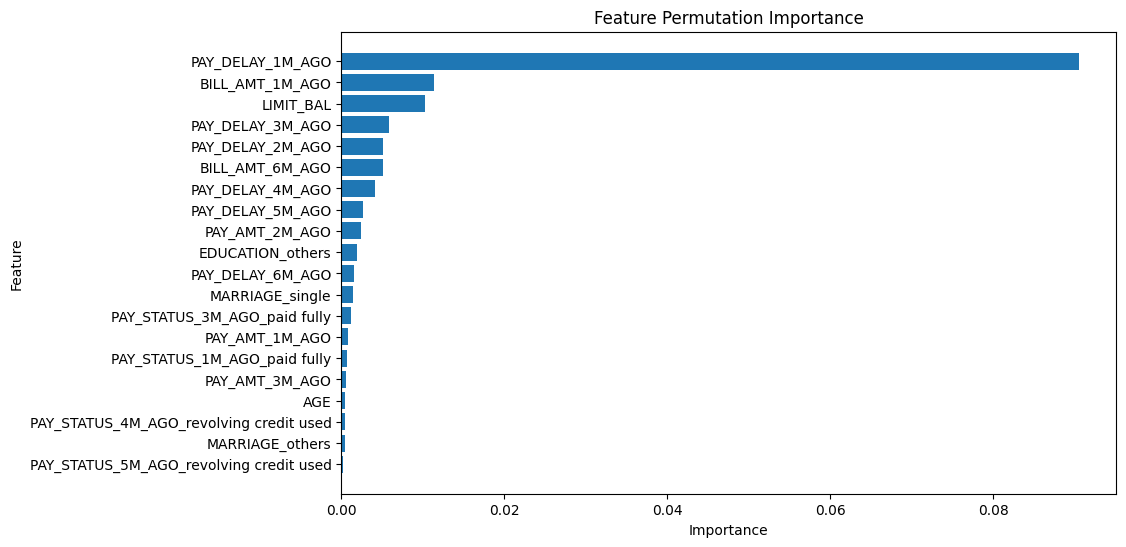

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_6M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_2M_AGO', 'BILL_AMT_6M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat remo

In [ ]:
gbt_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   828  3659  1014   499      44.95   62.40        78.30     74.78     52.26   
1   598  3879   794   729      42.96   45.06        83.01     74.62     43.99   
2   470  4195   478   857      49.58   35.42        89.77     77.75     41.32   
3   440  4267   406   887      52.01   33.16        91.31     78.45     40.50   
4   349  4362   311   978      52.88   26.30        93.34     78.52     35.13   
5   270  4444   229  1057      54.11   20.35        95.10     78.57     29.57   
6   250  4459   214  1077      53.88   18.84        95.42     78.48     27.92   
7   140  4548   125  1187      52.83   10.55        97.33     78.13     17.59   
8    34  4627    46  1293      42.50    2.56        99.02     77.68      4.83   
9    17  4651    22  1310      43.59    1.28        99.53     77.80      2.49   
10   14  4653    20  1313      41.18    1.06        99.57     77.78      2.06   
11    6  4662    11  1321      35.29    0.45        99.76     77.80      0.89   
12    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.35                 0   
1               64.04                 1   
2               62.59                 2   
3               62.23                 3   
4               59.82                 4   
5               57.72                 5   
6               57.13                 6   
7               53.94                 7   
8               50.79                 8   
9               50.41                 9   
10              50.31                10   
11              50.11                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:35:09.148945

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
gbt_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    828  3659  1014  499      44.95   62.40        78.30     74.78     52.26   
1   1064  2372  2301  263      31.62   80.18        50.76     57.27     45.35   
2   1003  2691  1982  324      33.60   75.58        57.59     61.57     46.52   
3    918  3002  1671  409      35.46   69.18        64.24     65.33     46.88   
4    907  2982  1691  420      34.91   68.35        63.81     64.82     46.22   
5    818  3092  1581  509      34.10   61.64        66.17     65.17     43.91   
6    817  3093  1580  510      34.08   61.57        66.19     65.17     43.88   
7    914  2623  2050  413      30.84   68.88        56.13     58.95     42.60   
8   1070  1906  2767  257      27.89   80.63        40.79     49.60     41.44   
9   1060  1953  2720  267      28.04   79.88        41.79     50.22     41.51   
10  1070  1889  2784  257      27.76   80.63        40.42     49.32     41.30   
11  1163  1106  3567  164      24.59   87.64        23.67     37.82     38.40   
12  1144  1151  3522  183      24.52   86.21        24.63     38.25     38.18   
13  1153  1140  3533  174      24.61   86.89        24.40     38.22     38.35   
14  1136  1139  3534  191      24.33   85.61        24.37     37.92     37.89   
15  1133  1181  3492  194      24.50   85.38        25.27     38.57     38.07   
16  1183   866  3807  144      23.71   89.15        18.53     34.15     37.45   
17  1211   750  3923  116      23.59   91.26        16.05     32.68     37.49   
18  1219   653  4020  108      23.27   91.86        13.97     31.20     37.13   
19  1218   666  4007  109      23.31   91.79        14.25     31.40     37.18   
20  1224   617  4056  103      23.18   92.24        13.20     30.68     37.05   

    balanced_accuracy  num_feat_missing  \
0               70.35                 0   
1               65.47                 1   
2               66.59                 2   
3               66.71                 3   
4               66.08                 4   
5               63.91                 5   
6               63.88                 6   
7               62.50                 7   
8               60.71                 8   
9               60.84                 9   
10              60.53                10   
11              55.65                11   
12              55.42                12   
13              55.64                13   
14              54.99                14   
15              55.33                15   
16              53.84                16   
17              53.65                17   
18              52.92                18   
19              53.02                19   
20              52.72                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
gbt_perf_temp, gbt_orig_missing_temp, gbt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
gbt_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  828  3659  1014   499      44.95   62.40        78.30     74.78     52.26   
1  417  4303   370   910      52.99   31.42        92.08     78.67     39.45   
2  381  4343   330   946      53.59   28.71        92.94     78.73     37.39   
3  269  4507   166  1058      61.84   20.27        96.45     79.60     30.53   
4  219  4536   137  1108      61.52   16.50        97.07     79.25     26.02   
5   10  4661    12  1317      45.45    0.75        99.74     77.85      1.48   
6    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.35                 0   
1              61.75                 4   
2              60.82                 5   
3              58.36                 8   
4              56.79                11   
5              50.25                15   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_temp_mf, gbt_orig_missing_temp_mf, gbt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:39:18.687521

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
gbt_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   828  3659  1014  499      44.95   62.40        78.30     74.78     52.26   
1   861  3203  1470  466      36.94   64.88        68.54     67.73     47.07   
2   839  3291  1382  488      37.78   63.23        70.43     68.83     47.29   
3   731  3544  1129  596      39.30   55.09        75.84     71.25     45.87   
4   615  3692   981  712      38.53   46.35        79.01     71.78     42.08   
5  1098  1643  3030  229      26.60   82.74        35.16     45.68     40.26   
6  1242   589  4084   85      23.32   93.59        12.60     30.52     37.34   
7  1324    41  4632    3      22.23   99.77         0.88     22.75     36.36   

   balanced_accuracy  num_feat_missing  \
0              70.35                 0   
1              66.71                 4   
2              66.83                 5   
3              65.46                 8   
4              62.68                11   
5              58.95                15   
6              53.10                18   
7              50.33                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'reg_lambda':[0.0],
      'gamma': [0.5],
      'colsample_bytree':[0.5]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 19:40:46.154258

Nested Cross-validation Results:
Individual scores: [0.5549688  0.54176726 0.53193016]
Average nested CV score: 0.543 (+/- 0.019)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.5, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.543
2025-01-18 19:40:49.456874

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-17 17:00:03.919300

Nested Cross-validation Results:
Individual scores: [0.55275174 0.54042243 0.53114598]
Average nested CV score: 0.541 (+/- 0.018)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.5, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.543
2025-01-17 17:18:51.804299

Execution time: 18.80 minutes
```

In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.063469  0.001445
29                          BILL_AMT_1M_AGO    0.021542  0.000604
1                          PAY_DELAY_2M_AGO    0.018647  0.001103
7                                 LIMIT_BAL    0.015212  0.001483
3                          PAY_DELAY_4M_AGO    0.009158  0.001367
9                            PAY_AMT_2M_AGO    0.005089  0.001252
8                            PAY_AMT_1M_AGO    0.004862  0.001561
2                          PAY_DELAY_3M_AGO    0.004466  0.001208
12  PAY_STATUS_4M_AGO_revolving credit used    0.004218  0.000893
31                          BILL_AMT_6M_AGO    0.004022  0.000187
5                          PAY_DELAY_6M_AGO    0.003532  0.000908
24                         EDUCATION_others    0.002611  0.000580
10  PAY_STATUS_3M_AGO_revolving credit used    0.002406  0.000895
11                           PAY_AMT_3M_AGO    0.002240  0.001488
30                                      AGE    0.002224  0.000665
6   PAY_STATUS_1M_AGO_revolving credit used    0.001940  0.000834
4                          PAY_DELAY_5M_AGO    0.001653  0.000542
25                     EDUCATION_university    0.001558  0.000489
16  PAY_STATUS_5M_AGO_revolving credit used    0.001227  0.000465
28                          MARRIAGE_single    0.001158  0.001058
26                                 SEX_male    0.000896  0.000557
14                           PAY_AMT_5M_AGO    0.000781  0.001132
18             PAY_STATUS_3M_AGO_paid fully    0.000770  0.000450
32                          MARRIAGE_others    0.000667  0.000326
23             PAY_STATUS_6M_AGO_paid fully    0.000599  0.000736
17  PAY_STATUS_6M_AGO_revolving credit used    0.000511  0.000158
15                           PAY_AMT_6M_AGO   -0.000014  0.000398
13                           PAY_AMT_4M_AGO   -0.000130  0.001166
22             PAY_STATUS_1M_AGO_paid fully   -0.000797  0.000185
19             PAY_STATUS_2M_AGO_paid fully   -0.001789  0.000442

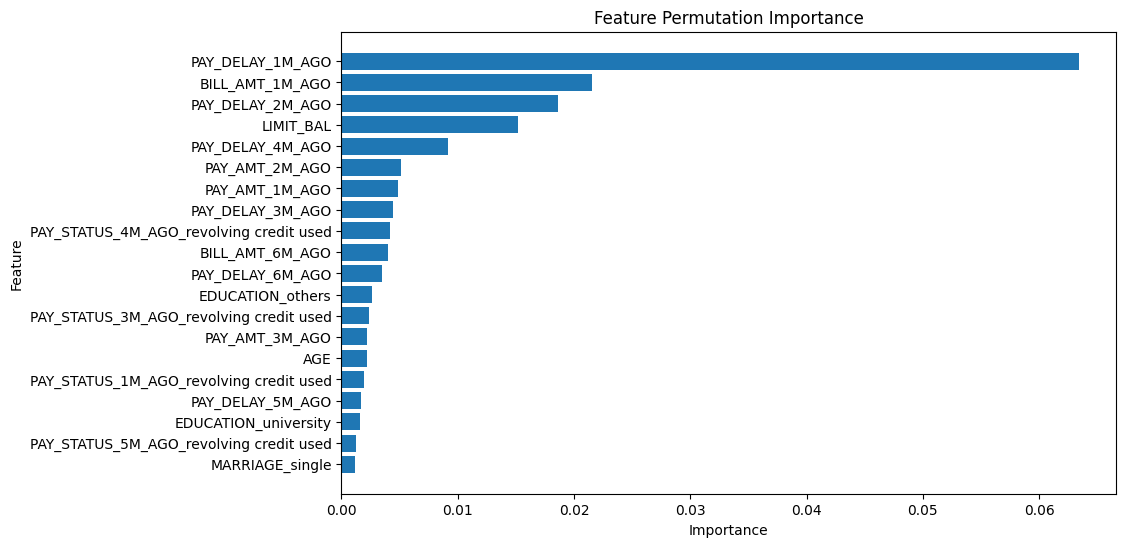

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMIT_BAL', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMIT_BAL', 'PAY_DELAY_4M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat r

In [ ]:
xgb_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   840  3638  1035   487      44.80   63.30        77.85     74.63     52.47   
1   736  3718   955   591      43.52   55.46        79.56     74.23     48.77   
2   568  4121   552   759      50.71   42.80        88.19     78.15     46.42   
3   427  4261   412   900      50.89   32.18        91.18     78.13     39.43   
4   361  4356   317   966      53.24   27.20        93.22     78.62     36.01   
5   221  4475   198  1106      52.74   16.65        95.76     78.27     25.32   
6   211  4522   151  1116      58.29   15.90        96.77     78.88     24.99   
7   228  4497   176  1099      56.44   17.18        96.23     78.75     26.34   
8   145  4570   103  1182      58.47   10.93        97.80     78.58     18.41   
9   205  4499   174  1122      54.09   15.45        96.28     78.40     24.03   
10  204  4465   208  1123      49.51   15.37        95.55     77.82     23.46   
11  110  4535   138  1217      44.35    8.29        97.05     77.42     13.97   
12  102  4544   129  1225      44.16    7.69        97.24     77.43     13.09   
13  104  4539   134  1223      43.70    7.84        97.13     77.38     13.29   
14   53  4628    45  1274      54.08    3.99        99.04     78.02      7.44   
15   49  4634    39  1278      55.68    3.69        99.17     78.05      6.93   
16   52  4619    54  1275      49.06    3.92        98.84     77.85      7.26   
17    2  4668     5  1325      28.57    0.15        99.89     77.83      0.30   
18    4  4664     9  1323      30.77    0.30        99.81     77.80      0.60   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.58                 0   
1               67.51                 1   
2               65.50                 2   
3               61.68                 3   
4               60.21                 4   
5               56.21                 5   
6               56.33                 6   
7               56.71                 7   
8               54.36                 8   
9               55.86                 9   
10              55.46                10   
11              52.67                11   
12              52.46                12   
13              52.48                13   
14              51.52                14   
15              51.43                15   
16              51.38                16   
17              50.02                17   
18              50.05                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:40:51.996943

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
xgb_perf_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   840  3638  1035   487      44.80   63.30        77.85     74.63     52.47   
1   740  3711   962   587      43.48   55.76        79.41     74.18     48.86   
2   657  3943   730   670      47.37   49.51        84.38     76.67     48.42   
3   521  4087   586   806      47.06   39.26        87.46     76.80     42.81   
4   460  4193   480   867      48.94   34.66        89.73     77.55     40.58   
5   419  4237   436   908      49.01   31.57        90.67     77.60     38.41   
6   366  4325   348   961      51.26   27.58        92.55     78.18     35.86   
7   372  4319   354   955      51.24   28.03        92.42     78.18     36.24   
8   197  4474   199  1130      49.75   14.85        95.74     77.85     22.87   
9   200  4465   208  1127      49.02   15.07        95.55     77.75     23.05   
10  256  4419   254  1071      50.20   19.29        94.56     77.92     27.87   
11  185  4481   192  1142      49.07   13.94        95.89     77.77     21.71   
12  175  4495   178  1152      49.58   13.19        96.19     77.83     20.83   
13  244  4381   292  1083      45.52   18.39        93.75     77.08     26.19   
14  199  4450   223  1128      47.16   15.00        95.23     77.48     22.76   
15  120  4518   155  1207      43.64    9.04        96.68     77.30     14.98   
16   52  4599    74  1275      41.27    3.92        98.42     77.52      7.16   
17   11  4645    28  1316      28.21    0.83        99.40     77.60      1.61   
18    8  4651    22  1319      26.67    0.60        99.53     77.65      1.18   
19    1  4670     3  1326      25.00    0.08        99.94     77.85      0.15   
20    2  4669     4  1325      33.33    0.15        99.91     77.85      0.30   

    balanced_accuracy  num_feat_missing  \
0               70.58                 0   
1               67.59                 1   
2               66.94                 2   
3               63.36                 3   
4               62.20                 4   
5               61.12                 5   
6               60.07                 6   
7               60.23                 7   
8               55.29                 8   
9               55.31                 9   
10              56.93                10   
11              54.92                11   
12              54.69                12   
13              56.07                13   
14              55.11                14   
15              52.86                15   
16              51.17                16   
17              50.11                17   
18              50.07                18   
19              50.01                19   
20              50.03                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...

In [ ]:
xgb_perf_temp, xgb_orig_missing_temp, xgb_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
xgb_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  840  3638  1035   487      44.80   63.30        77.85     74.63     52.47   
1  638  3940   733   689      46.54   48.08        84.31     76.30     47.29   
2  468  4159   514   859      47.66   35.27        89.00     77.12     40.54   
3  378  4302   371   949      50.47   28.49        92.06     78.00     36.42   
4  338  4361   312   989      52.00   25.47        93.32     78.32     34.19   
5  242  4472   201  1085      54.63   18.24        95.70     78.57     27.34   
6   21  4660    13  1306      61.76    1.58        99.72     78.02      3.09   
7   17  4667     6  1310      73.91    1.28        99.87     78.07      2.52   
8    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.58                 0   
1              66.20                 4   
2              62.13                 7   
3              60.27                 8   
4              59.40                11   
5              56.97                14   
6              50.65                18   
7              50.58                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_temp_mf, xgb_orig_missing_temp_mf, xgb_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:45:03.457933

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
xgb_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  840  3638  1035   487      44.80   63.30        77.85     74.63     52.47   
1  577  4050   623   750      48.08   43.48        86.67     77.12     45.67   
2  383  4285   388   944      49.68   28.86        91.70     77.80     36.51   
3  367  4313   360   960      50.48   27.66        92.30     78.00     35.74   
4  309  4415   258  1018      54.50   23.29        94.48     78.73     32.63   
5   89  4620    53  1238      62.68    6.71        98.87     78.48     12.12   
6   37  4645    28  1290      56.92    2.79        99.40     78.03      5.32   
7   46  4643    30  1281      60.53    3.47        99.36     78.15      6.56   
8   34  4646    27  1293      55.74    2.56        99.42     78.00      4.90   

   balanced_accuracy  num_feat_missing  \
0              70.58                 0   
1              65.07                 4   
2              60.28                 7   
3              59.98                 8   
4              58.88                11   
5              52.79                14   
6              51.09                18   
7              51.41                19   
8              50.99                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [200],
      'max_depth': [None],
      'max_features':[0.5],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 19:46:42.583277

Nested Cross-validation Results:
Individual scores: [0.54673721 0.55286624 0.53138392]
Average nested CV score: 0.544 (+/- 0.018)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.544
2025-01-18 19:47:04.062450

Execution time: 0.36 minutes


```
Starting hyperparameter tuning at: 2025-01-17 18:48:22.117627

Nested Cross-validation Results:
Individual scores: [0.54930683 0.54045562 0.5299012 ]
Average nested CV score: 0.540 (+/- 0.016)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.544
2025-01-17 19:38:49.552233

Execution time: 50.46 minutes
```

In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.087507  0.001293
7                                 LIMIT_BAL    0.038034  0.000961
1                          PAY_DELAY_2M_AGO    0.034835  0.000862
6   PAY_STATUS_1M_AGO_revolving credit used    0.029695  0.001872
17  PAY_STATUS_6M_AGO_revolving credit used    0.025102  0.001868
29                          BILL_AMT_1M_AGO    0.022431  0.000856
2                          PAY_DELAY_3M_AGO    0.018930  0.001659
31                          BILL_AMT_6M_AGO    0.016649  0.000611
10  PAY_STATUS_3M_AGO_revolving credit used    0.016197  0.001039
8                            PAY_AMT_1M_AGO    0.016095  0.002538
3                          PAY_DELAY_4M_AGO    0.016012  0.000988
28                          MARRIAGE_single    0.015872  0.002232
26                                 SEX_male    0.015728  0.001192
9                            PAY_AMT_2M_AGO    0.015637  0.001206
25                     EDUCATION_university    0.014412  0.000526
13                           PAY_AMT_4M_AGO    0.013723  0.001148
11                           PAY_AMT_3M_AGO    0.013660  0.001677
15                           PAY_AMT_6M_AGO    0.013589  0.001570
30                                      AGE    0.013379  0.000272
4                          PAY_DELAY_5M_AGO    0.012759  0.000637
16  PAY_STATUS_5M_AGO_revolving credit used    0.012508  0.001127
12  PAY_STATUS_4M_AGO_revolving credit used    0.012460  0.000219
19             PAY_STATUS_2M_AGO_paid fully    0.012090  0.000916
18             PAY_STATUS_3M_AGO_paid fully    0.011868  0.001085
22             PAY_STATUS_1M_AGO_paid fully    0.011493  0.000629
14                           PAY_AMT_5M_AGO    0.010602  0.001847
20             PAY_STATUS_4M_AGO_paid fully    0.010067  0.000796
23             PAY_STATUS_6M_AGO_paid fully    0.007952  0.000415
27                    EDUCATION_high school    0.006869  0.000393
21             PAY_STATUS_5M_AGO_paid fully    0.006156  0.001539
24                         EDUCATION_others    0.004494  0.000443
5                          PAY_DELAY_6M_AGO    0.004456  0.000303
32                          MARRIAGE_others    0.000798  0.000110

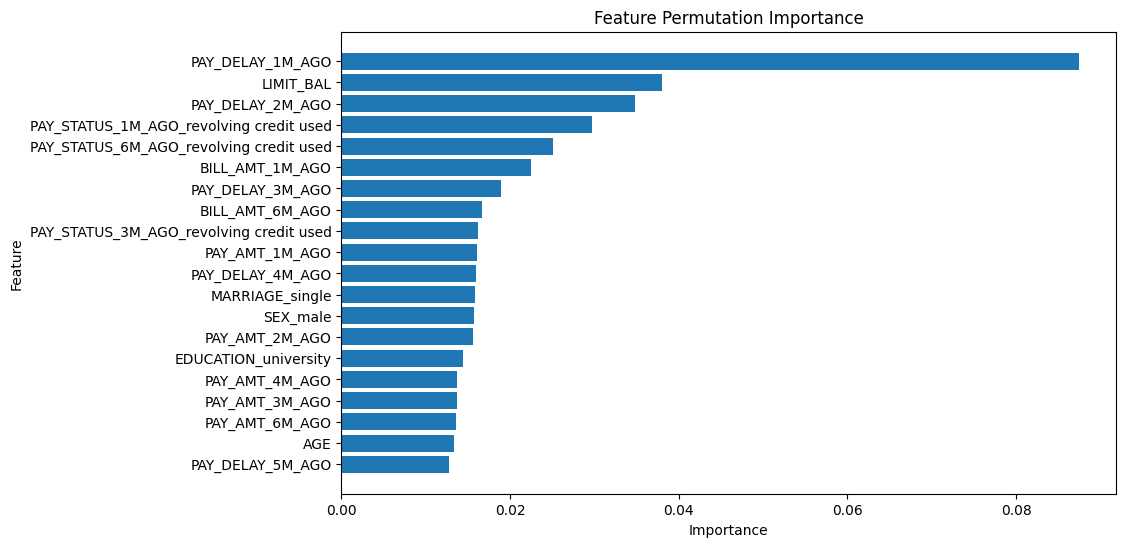

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2M_AGO', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_6M_AGO']

--- NEW ITERATION ---


In [ ]:
et_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   808  3768  905   519      47.17   60.89        80.63     76.27     53.16   
1   669  3913  760   658      46.82   50.41        83.74     76.37     48.55   
2   614  4007  666   713      47.97   46.27        85.75     77.02     47.10   
3   435  4203  470   892      48.07   32.78        89.94     77.30     38.98   
4   422  4205  468   905      47.42   31.80        89.99     77.12     38.07   
5   411  4233  440   916      48.30   30.97        90.58     77.40     37.74   
6   409  4240  433   918      48.57   30.82        90.73     77.48     37.71   
7   387  4279  394   940      49.55   29.16        91.57     77.77     36.72   
8   390  4279  394   937      49.74   29.39        91.57     77.82     36.95   
9   416  4231  442   911      48.48   31.35        90.54     77.45     38.08   
10  418  4221  452   909      48.05   31.50        90.33     77.32     38.05   
11  329  4376  297   998      52.56   24.79        93.64     78.42     33.69   
12  329  4377  296   998      52.64   24.79        93.67     78.43     33.71   
13  329  4378  295   998      52.72   24.79        93.69     78.45     33.73   
14  329  4377  296   998      52.64   24.79        93.67     78.43     33.71   
15  329  4377  296   998      52.64   24.79        93.67     78.43     33.71   
16  329  4377  296   998      52.64   24.79        93.67     78.43     33.71   
17  329  4377  296   998      52.64   24.79        93.67     78.43     33.71   
18  329  4376  297   998      52.56   24.79        93.64     78.42     33.69   
19  329  4376  297   998      52.56   24.79        93.64     78.42     33.69   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.76                 0   
1               67.08                 1   
2               66.01                 2   
3               61.36                 3   
4               60.89                 4   
5               60.78                 5   
6               60.78                 6   
7               60.37                 7   
8               60.48                 8   
9               60.95                 9   
10              60.91                10   
11              59.22                11   
12              59.23                12   
13              59.24                13   
14              59.23                14   
15              59.23                15   
16              59.23                16   
17              59.23                17   
18              59.22                18   
19              59.22                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:47:27.291146

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
et_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   808  3768  905   519      47.17   60.89        80.63     76.27     53.16   
1   694  3833  840   633      45.24   52.30        82.02     75.45     48.51   
2   677  3855  818   650      45.28   51.02        82.50     75.53     47.98   
3   545  4001  672   782      44.78   41.07        85.62     75.77     42.85   
4   527  4033  640   800      45.16   39.71        86.30     76.00     42.26   
5   500  4071  602   827      45.37   37.68        87.12     76.18     41.17   
6   421  4240  433   906      49.30   31.73        90.73     77.68     38.61   
7   369  4323  350   958      51.32   27.81        92.51     78.20     36.07   
8   370  4341  332   957      52.71   27.88        92.90     78.52     36.47   
9   375  4326  347   952      51.94   28.26        92.57     78.35     36.60   
10  366  4336  337   961      52.06   27.58        92.79     78.37     36.06   
11  305  4412  261  1022      53.89   22.98        94.41     78.62     32.22   
12  301  4429  244  1026      55.23   22.68        94.78     78.83     32.16   
13  297  4444  229  1030      56.46   22.38        95.10     79.02     32.06   
14  292  4449  224  1035      56.59   22.00        95.21     79.02     31.69   
15  272  4459  214  1055      55.97   20.50        95.42     78.85     30.01   
16  293  4449  224  1034      56.67   22.08        95.21     79.03     31.78   
17  286  4450  223  1041      56.19   21.55        95.23     78.93     31.15   
18  271  4461  212  1056      56.11   20.42        95.46     78.87     29.94   
19  275  4473  200  1052      57.89   20.72        95.72     79.13     30.52   
20  108  4604   69  1219      61.02    8.14        98.52     78.53     14.36   

    balanced_accuracy  num_feat_missing  \
0               70.76                 0   
1               67.16                 1   
2               66.76                 2   
3               63.34                 3   
4               63.01                 4   
5               62.40                 5   
6               61.23                 6   
7               60.16                 7   
8               60.39                 8   
9               60.42                 9   
10              60.18                10   
11              58.70                11   
12              58.73                12   
13              58.74                13   
14              58.61                14   
15              57.96                15   
16              58.64                16   
17              58.39                17   
18              57.94                18   
19              58.22                19   
20              53.33                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_2...

In [ ]:
et_perf_temp, et_orig_missing_temp, et_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
et_perf_temp

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0  808  3768  905  519      47.17   60.89        80.63     76.27     53.16   
1  596  4038  635  731      48.42   44.91        86.41     77.23     46.60   
2  600  4013  660  727      47.62   45.21        85.88     76.88     46.39   
3  412  4226  447  915      47.96   31.05        90.43     77.30     37.69   
4  414  4224  449  913      47.97   31.20        90.39     77.30     37.81   
5  420  4209  464  907      47.51   31.65        90.07     77.15     37.99   
6  329  4375  298  998      52.47   24.79        93.62     78.40     33.67   
7  329  4375  298  998      52.47   24.79        93.62     78.40     33.67   
8  329  4375  298  998      52.47   24.79        93.62     78.40     33.67   

   balanced_accuracy  num_feat_missing  \
0              70.76                 0   
1              65.66                 4   
2              65.55                 5   
3              60.74                 8   
4              60.79                12   
5              60.86                15   
6              59.21                18   
7              59.21                19   
8              59.21                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_temp_mf, et_orig_missing_temp_mf, et_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:51:47.241477

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
et_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  808  3768  905   519      47.17   60.89        80.63     76.27     53.16   
1  530  4131  542   797      49.44   39.94        88.40     77.68     44.19   
2  506  4154  519   821      49.37   38.13        88.89     77.67     43.03   
3  418  4275  398   909      51.23   31.50        91.48     78.22     39.01   
4  374  4304  369   953      50.34   28.18        92.10     77.97     36.14   
5  348  4371  302   979      53.54   26.22        93.54     78.65     35.20   
6  275  4426  247  1052      52.68   20.72        94.71     78.35     29.75   
7  260  4438  235  1067      52.53   19.59        94.97     78.30     28.54   
8  241  4457  216  1086      52.74   18.16        95.38     78.30     27.02   

   balanced_accuracy  num_feat_missing  \
0              70.76                 0   
1              64.17                 4   
2              63.51                 5   
3              61.49                 8   
4              60.14                12   
5              59.88                15   
6              57.72                18   
7              57.28                19   
8              56.77                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, default_cc_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = default_cc_scaler)

In [ ]:
default_cc_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
default_cc_imputation_scaled_values_dict

{'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'PAY_STATUS_1M_AGO_revolving credit used': 0.0,
 'LIMIT_BAL': 0.16455696202531644,
 'PAY_AMT_1M_AGO': 0.0024039782405626685,
 'PAY_AMT_2M_AGO': 0.0011939968852771458,
 'PAY_STATUS_3M_AGO_revolving credit used': 1.0,
 'PAY_AMT_3M_AGO': 0.0020313978064053144,
 'PAY_STATUS_4M_AGO_revolving credit used': 1.0,
 'PAY_AMT_4M_AGO': 0.0024154589371980675,
 'PAY_AMT_5M_AGO': 0.0035167597044984044,
 'PAY_AMT_6M_AGO': 0.002845527684138839,
 'PAY_STATUS_5M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_6M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_3M_AGO_paid fully': 0.0,
 'PAY_STATUS_2M_AGO_paid fully': 0.0,
 'PAY_STATUS_4M_AGO_paid fully': 0.0,
 'PAY_STATUS_5M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'PAY_STATUS_6M_AGO_paid fully': 0.0,
 'EDUCATION_others': 0.0,
 'EDUCATION_university': 0.0,
 'SEX_male': 0.0,
 'EDUCATION

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5, 10, 100],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1]
  }
else:
  # best model
  svm_param_grid = {
    'C': [10.0],
    'kernel': ['rbf'],
    'gamma': [0.1]
}

svm_classifier = SVC(
    class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE
)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 19:53:28.748065

Nested Cross-validation Results:
Individual scores: [0.52614555 0.53493222 0.52153727]
Average nested CV score: 0.528 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.528
2025-01-18 19:54:47.000911

Execution time: 1.30 minutes


```
Starting hyperparameter tuning at: 2025-01-17 22:22:00.736630

Nested Cross-validation Results:
Individual scores: [0.52156057 0.53052878 0.51481043]
Average nested CV score: 0.522 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 56 candidates, totalling 168 fits
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.528
2025-01-17 23:38:21.935189

Execution time: 76.35 minutes
```




In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1", n_repeats=3)
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
6   PAY_STATUS_1M_AGO_revolving credit used    0.123030  0.004224
0                          PAY_DELAY_1M_AGO    0.038283  0.001122
22             PAY_STATUS_1M_AGO_paid fully    0.018357  0.001040
19             PAY_STATUS_2M_AGO_paid fully    0.014722  0.001332
1                          PAY_DELAY_2M_AGO    0.010686  0.000884
20             PAY_STATUS_4M_AGO_paid fully    0.009048  0.000501
12  PAY_STATUS_4M_AGO_revolving credit used    0.008372  0.001217
10  PAY_STATUS_3M_AGO_revolving credit used    0.008053  0.001361
16  PAY_STATUS_5M_AGO_revolving credit used    0.007436  0.000508
21             PAY_STATUS_5M_AGO_paid fully    0.007018  0.001193
17  PAY_STATUS_6M_AGO_revolving credit used    0.006625  0.002102
28                          MARRIAGE_single    0.006333  0.000854
18             PAY_STATUS_3M_AGO_paid fully    0.006043  0.000276
26                                 SEX_male    0.005759  0.000608
25                     EDUCATION_university    0.005393  0.000362
23             PAY_STATUS_6M_AGO_paid fully    0.005333  0.000939
2                          PAY_DELAY_3M_AGO    0.005148  0.001376
7                                 LIMIT_BAL    0.004664  0.001190
3                          PAY_DELAY_4M_AGO    0.003760  0.001001
27                    EDUCATION_high school    0.003736  0.000526
4                          PAY_DELAY_5M_AGO    0.002150  0.000757
24                         EDUCATION_others    0.002135  0.000154
30                                      AGE    0.000923  0.000109
5                          PAY_DELAY_6M_AGO    0.000758  0.000361
14                           PAY_AMT_5M_AGO    0.000543  0.000249
8                            PAY_AMT_1M_AGO    0.000417  0.000147
15                           PAY_AMT_6M_AGO    0.000391  0.000144
9                            PAY_AMT_2M_AGO    0.000345  0.000320
11                           PAY_AMT_3M_AGO    0.000208  0.000298
29                          BILL_AMT_1M_AGO    0.000128  0.000582
32                          MARRIAGE_others    0.000049  0.000127
13                           PAY_AMT_4M_AGO    0.000003  0.000033
31                          BILL_AMT_6M_AGO   -0.000614  0.000153

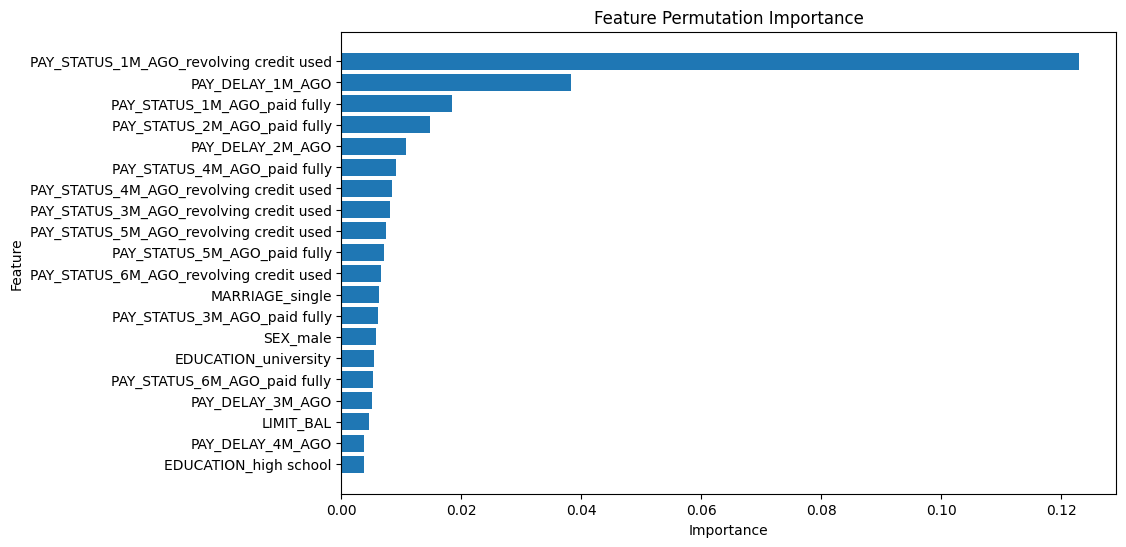

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_paid fully
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_paid fully
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  [

In [ ]:
svm_perf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    752  3861   812  575      48.08   56.67        82.62     76.88     52.02   
1   1032  1828  2845  295      26.62   77.77        39.12     47.67     39.66   
2    942  1999  2674  385      26.05   70.99        42.78     49.02     38.11   
3    947  1953  2720  380      25.82   71.36        41.79     48.33     37.93   
4    933  1974  2699  394      25.69   70.31        42.24     48.45     37.63   
5    974  1885  2788  353      25.89   73.40        40.34     47.65     38.28   
6   1078  1409  3264  249      24.83   81.24        30.15     41.45     38.03   
7   1204   778  3895  123      23.61   90.73        16.65     33.03     37.47   
8   1320    84  4589    7      22.34   99.47         1.80     23.40     36.48   
9   1319    84  4589    8      22.33   99.40         1.80     23.38     36.46   
10  1319    84  4589    8      22.33   99.40         1.80     23.38     36.46   
11  1327     2  4671    0      22.12  100.00         0.04     22.15     36.23   
12  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
13  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
14  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
15  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
16  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
17  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
18  1327     2  4671    0      22.12  100.00         0.04     22.15     36.23   
19  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
20  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

    balanced_accuracy  num_feat_missing  \
0               69.65                 0   
1               58.44                 1   
2               56.88                 2   
3               56.58                 3   
4               56.28                 4   
5               56.87                 5   
6               55.69                 6   
7               53.69                 7   
8               50.64                 8   
9               50.60                 9   
10              50.60                10   
11              50.02                11   
12              50.03                12   
13              50.03                13   
14              50.03                14   
15              50.03                15   
16              50.03                16   
17              50.03                17   
18              50.02                18   
19              50.01                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:03:35.071285

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  2
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUC

In [ ]:
svm_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   752  3861  812   575      48.08   56.67        82.62     76.88     52.02   
1   580  3974  699   747      45.35   43.71        85.04     75.90     44.51   
2   545  4018  655   782      45.42   41.07        85.98     76.05     43.13   
3   544  4033  640   783      45.95   40.99        86.30     76.28     43.33   
4   509  4075  598   818      45.98   38.36        87.20     76.40     41.82   
5   491  4114  559   836      46.76   37.00        88.04     76.75     41.31   
6   402  4289  384   925      51.15   30.29        91.78     78.18     38.05   
7   366  4365  308   961      54.30   27.58        93.41     78.85     36.58   
8   332  4398  275   995      54.70   25.02        94.12     78.83     34.33   
9   333  4395  278   994      54.50   25.09        94.05     78.80     34.37   
10  332  4397  276   995      54.61   25.02        94.09     78.82     34.32   
11  333  4397  276   994      54.68   25.09        94.09     78.83     34.40   
12  293  4451  222  1034      56.89   22.08        95.25     79.07     31.81   
13  289  4459  214  1038      57.46   21.78        95.42     79.13     31.58   
14  206  4528  145  1121      58.69   15.52        96.90     78.90     24.55   
15   12  4666    7  1315      63.16    0.90        99.85     77.97      1.78   
16   11  4666    7  1316      61.11    0.83        99.85     77.95      1.64   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.65                 0   
1               64.37                 1   
2               63.53                 2   
3               63.65                 3   
4               62.78                 4   
5               62.52                 5   
6               61.04                 6   
7               60.49                 7   
8               59.57                 8   
9               59.57                 9   
10              59.56                10   
11              59.59                11   
12              58.66                12   
13              58.60                13   
14              56.21                14   
15              50.38                15   
16              50.34                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm_perf_temp, svm_orig_missing_temp, svm_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO    

In [ ]:
svm_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  752  3861  812   575      48.08   56.67        82.62     76.88     52.02   
1    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
2    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
3    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.65                 0   
1              50.00                 4   
2              50.00                 7   
3              50.00                10   
4              50.00                13   
5              50.00                16   
6              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_temp_mf, svm_orig_missing_temp_mf, svm_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:09:57.671458

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']


In [ ]:
svm_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  752  3861  812   575      48.08   56.67        82.62     76.88     52.02   
1  514  4087  586   813      46.73   38.73        87.46     76.68     42.36   
2  469  4168  505   858      48.15   35.34        89.19     77.28     40.76   
3  444  4199  474   883      48.37   33.46        89.86     77.38     39.55   
4  314  4410  263  1013      54.42   23.66        94.37     78.73     32.98   
5   65  4618   55  1262      54.17    4.90        98.82     78.05      8.98   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.65                 0   
1              63.10                 4   
2              62.27                 7   
3              61.66                10   
4              59.02                13   
5              51.86                16   
6              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**##

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicolinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_default_cc_dist_corr = default_cc_dist_corr[present_features]
filtered_default_cc_dist_corr = filtered_default_cc_dist_corr[filtered_default_cc_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_default_cc_dist_corr, 'Target', 0.8)

appended feature:  PAY_DELAY_1M_AGO
appended feature:  PAY_DELAY_2M_AGO
appended feature:  PAY_DELAY_3M_AGO
appended feature:  PAY_DELAY_4M_AGO
appended feature:  PAY_DELAY_5M_AGO
appended feature:  PAY_DELAY_6M_AGO
appended feature:  PAY_STATUS_1M_AGO_revolving credit used
appended feature:  LIMIT_BAL
appended feature:  PAY_AMT_1M_AGO
appended feature:  PAY_AMT_2M_AGO
appended feature:  PAY_STATUS_3M_AGO_revolving credit used
appended feature:  PAY_AMT_3M_AGO
appended feature:  PAY_STATUS_4M_AGO_revolving credit used
appended feature:  PAY_AMT_4M_AGO
appended feature:  PAY_AMT_5M_AGO
appended feature:  PAY_AMT_6M_AGO
appended feature:  PAY_STATUS_5M_AGO_revolving credit used
appended feature:  PAY_STATUS_6M_AGO_revolving credit used
appended feature:  PAY_STATUS_3M_AGO_paid fully
appended feature:  PAY_STATUS_2M_AGO_paid fully
appended feature:  PAY_STATUS_4M_AGO_paid fully
appended feature:  PAY_STATUS_5M_AGO_paid fully
appended feature:  PAY_STATUS_1M_AGO_paid fully
appended feature

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]
print('Nr features for LR: ', len(lr_X_train.columns))

Nr features for LR:  33


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],  # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [5],
      'penalty': ['l1'],
      'solver': ['saga']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 18:09:05.500334

Nested Cross-validation Results:
Individual scores: [0.54041688 0.53128259 0.52655889]
Average nested CV score: 0.533 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.533
2025-01-18 18:09:11.614530

Execution time: 0.10 minutes


```
Starting hyperparameter tuning at: 2025-01-17 17:37:53.662274

Nested Cross-validation Results:
Individual scores: [0.54027954 0.5286757  0.52702007]
Average nested CV score: 0.532 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.533
2025-01-17 17:38:16.718772

Execution time: 0.38 minutes
```

In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.116414  0.003383
7                                 LIMIT_BAL    0.018203  0.001994
29                          BILL_AMT_1M_AGO    0.008948  0.001676
2                          PAY_DELAY_3M_AGO    0.008356  0.000758
22             PAY_STATUS_1M_AGO_paid fully    0.006985  0.000775
3                          PAY_DELAY_4M_AGO    0.004286  0.001134
4                          PAY_DELAY_5M_AGO    0.004243  0.001061
19             PAY_STATUS_2M_AGO_paid fully    0.003629  0.000442
17  PAY_STATUS_6M_AGO_revolving credit used    0.002318  0.000730
18             PAY_STATUS_3M_AGO_paid fully    0.002005  0.000311
24                         EDUCATION_others    0.001559  0.000500
26                                 SEX_male    0.001508  0.000753
8                            PAY_AMT_1M_AGO    0.001197  0.000628
9                            PAY_AMT_2M_AGO    0.001012  0.000846
28                          MARRIAGE_single    0.000907  0.000900
20             PAY_STATUS_4M_AGO_paid fully    0.000754  0.000386
21             PAY_STATUS_5M_AGO_paid fully    0.000702  0.000159
16  PAY_STATUS_5M_AGO_revolving credit used    0.000671  0.000197
31                          BILL_AMT_6M_AGO    0.000657  0.000437
6   PAY_STATUS_1M_AGO_revolving credit used    0.000428  0.001426
32                          MARRIAGE_others    0.000355  0.000258
23             PAY_STATUS_6M_AGO_paid fully    0.000308  0.000103
30                                      AGE    0.000114  0.000437
27                    EDUCATION_high school   -0.000007  0.000145
15                           PAY_AMT_6M_AGO   -0.000058  0.000494
5                          PAY_DELAY_6M_AGO   -0.000064  0.000302
1                          PAY_DELAY_2M_AGO   -0.000112  0.000080
13                           PAY_AMT_4M_AGO   -0.000166  0.000299
25                     EDUCATION_university   -0.000333  0.000341
11                           PAY_AMT_3M_AGO   -0.000424  0.000291
12  PAY_STATUS_4M_AGO_revolving credit used   -0.000461  0.000343
10  PAY_STATUS_3M_AGO_revolving credit used   -0.000485  0.000430
14                           PAY_AMT_5M_AGO   -0.000818  0.000451

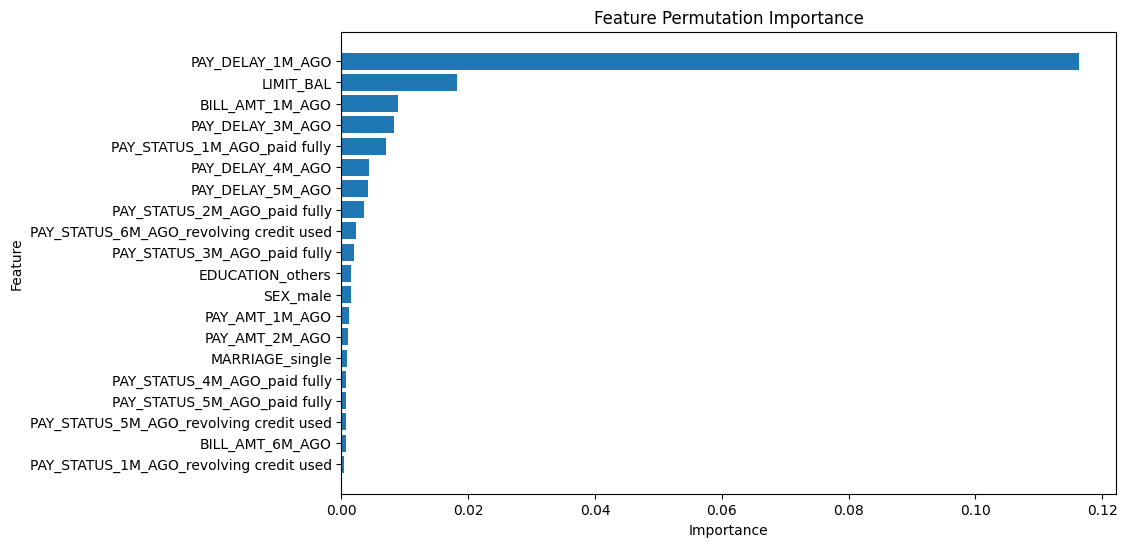

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY

In [ ]:
lr_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   773  3802  871   554      47.02   58.25        81.36     76.25     52.04   
1   480  4187  486   847      49.69   36.17        89.60     77.78     41.87   
2   441  4225  448   886      49.61   33.23        90.41     77.77     39.80   
3   409  4230  443   918      48.00   30.82        90.52     77.32     37.54   
4   332  4336  337   995      49.63   25.02        92.79     77.80     33.27   
5   314  4436  237  1013      56.99   23.66        94.93     79.17     33.44   
6   243  4494  179  1084      57.58   18.31        96.17     78.95     27.79   
7    68  4627   46  1259      59.65    5.12        99.02     78.25      9.44   
8    70  4624   49  1257      58.82    5.28        98.95     78.23      9.68   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.81                 0   
1               62.89                 1   
2               61.82                 2   
3               60.67                 3   
4               58.90                 4   
5               59.30                 5   
6               57.24                 6   
7               52.07                 7   
8               52.11                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
lr_X_train.columns

Index(['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO',
       'PAY_STATUS_1M_AGO_revolving credit used', 'LIMIT_BAL',
       'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO',
       'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_AMT_3M_AGO',
       'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_AMT_4M_AGO',
       'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_STATUS_5M_AGO_revolving credit used',
       'PAY_STATUS_6M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully',
       'EDUCATION_others', 'EDUCATION_university', 'SEX_male',
       'EDUCATION_high school', 'MARRIAGE_single', 'BILL_AMT_1M_AGO', 'AGE',
       'BILL_AMT_6M_AGO', 'MARRIAGE_others'],
      dtype='object')

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_default_cc_cat_vars = [col for col in lr_X_train.columns if col in default_cc_cat_vars]

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:11:41.290668

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   773  3802  871  554      47.02   58.25        81.36     76.25     52.04   
1   710  3726  947  617      42.85   53.50        79.73     73.93     47.59   
2   698  3807  866  629      44.63   52.60        81.47     75.08     48.29   
3   654  3905  768  673      45.99   49.28        83.57     75.98     47.58   
4   651  3908  765  676      45.97   49.06        83.63     75.98     47.47   
5   634  3969  704  693      47.38   47.78        84.93     76.72     47.58   
6   617  3991  682  710      47.50   46.50        85.41     76.80     46.99   
7   599  4024  649  728      48.00   45.14        86.11     77.05     46.52   
8   571  4092  581  756      49.57   43.03        87.57     77.72     46.07   
9   550  4104  569  777      49.15   41.45        87.82     77.57     44.97   
10  494  4233  440  833      52.89   37.23        90.58     78.78     43.70   
11  495  4236  437  832      53.11   37.30        90.65     78.85     43.82   
12  474  4275  398  853      54.36   35.72        91.48     79.15     43.11   
13  488  4254  419  839      53.80   36.77        91.03     79.03     43.69   
14  491  4255  418  836      54.02   37.00        91.05     79.10     43.92   
15  480  4269  404  847      54.30   36.17        91.35     79.15     43.42   
16  489  4244  429  838      53.27   36.85        90.82     78.88     43.56   
17  478  4253  420  849      53.23   36.02        91.01     78.85     42.97   
18  474  4262  411  853      53.56   35.72        91.20     78.93     42.86   
19  470  4271  402  857      53.90   35.42        91.40     79.02     42.75   
20  471  4269  404  856      53.83   35.49        91.35     79.00     42.78   

    balanced_accuracy  num_feat_missing  \
0               69.81                 0   
1               66.62                 1   
2               67.03                 2   
3               66.42                 3   
4               66.34                 4   
5               66.36                 5   
6               65.95                 6   
7               65.63                 7   
8               65.30                 8   
9               64.64                 9   
10              63.91                10   
11              63.98                11   
12              63.60                12   
13              63.90                13   
14              64.03                14   
15              63.76                15   
16              63.83                16   
17              63.52                17   
18              63.46                18   
19              63.41                19   
20              63.42                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
lr_perf_temp, lr_orig_missing_temp, lr_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   773  3802   871   554      47.02   58.25        81.36     76.25     52.04   
1  1327     0  4673     0      22.12  100.00         0.00     22.12     36.22   
2     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
3     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
4     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.81                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                11   
5              50.00                14   
6              50.00                17   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_temp_mf, lr_orig_missing_temp_mf, lr_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:15:57.690659

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  773  3802  871   554      47.02   58.25        81.36     76.25     52.04   
1  623  3919  754   704      45.24   46.95        83.86     75.70     46.08   
2  660  3891  782   667      45.77   49.74        83.27     75.85     47.67   
3  588  4063  610   739      49.08   44.31        86.95     77.52     46.57   
4  579  4010  663   748      46.62   43.63        85.81     76.48     45.08   
5  551  4096  577   776      48.85   41.52        87.65     77.45     44.89   
6  148  4565  108  1179      57.81   11.15        97.69     78.55     18.70   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.81                 0   
1              65.41                 4   
2              66.50                 5   
3              65.63                 8   
4              64.72                11   
5              64.59                14   
6              54.42                17   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Models optimized for Balanced Accuracy**

## **Decision Tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [None],
      'min_samples_split': [0.05],
      'min_samples_leaf': [0.001]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 20:17:25.880502

Nested Cross-validation Results:
Individual scores: [0.70372821 0.70586419 0.69962184]
Average nested CV score: 0.703 (+/- 0.005)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.001, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.703
2025-01-18 20:17:29.041790

Execution time: 0.05 minutes


```
Starting hyperparameter tuning at: 2025-01-17 17:38:16.726015

Nested Cross-validation Results:
Individual scores: [0.70835337 0.70495461 0.69318996]
Average nested CV score: 0.702 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.001, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.703
2025-01-17 17:38:53.166394

Execution time: 0.61 minutes
```

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.079010  0.002201
3                          PAY_DELAY_4M_AGO    0.025523  0.000481
8                            PAY_AMT_1M_AGO    0.012438  0.001118
9                            PAY_AMT_2M_AGO    0.011529  0.001413
20             PAY_STATUS_4M_AGO_paid fully    0.009468  0.000612
29                          BILL_AMT_1M_AGO    0.009089  0.000667
4                          PAY_DELAY_5M_AGO    0.008190  0.001251
17  PAY_STATUS_6M_AGO_revolving credit used    0.007490  0.000321
1                          PAY_DELAY_2M_AGO    0.006947  0.000543
11                           PAY_AMT_3M_AGO    0.005851  0.000428
7                                 LIMIT_BAL    0.004857  0.000887
15                           PAY_AMT_6M_AGO    0.003721  0.000985
23             PAY_STATUS_6M_AGO_paid fully    0.003262  0.000417
13                           PAY_AMT_4M_AGO    0.002345  0.000270
24                         EDUCATION_others    0.002262  0.000685
2                          PAY_DELAY_3M_AGO    0.002252  0.000421

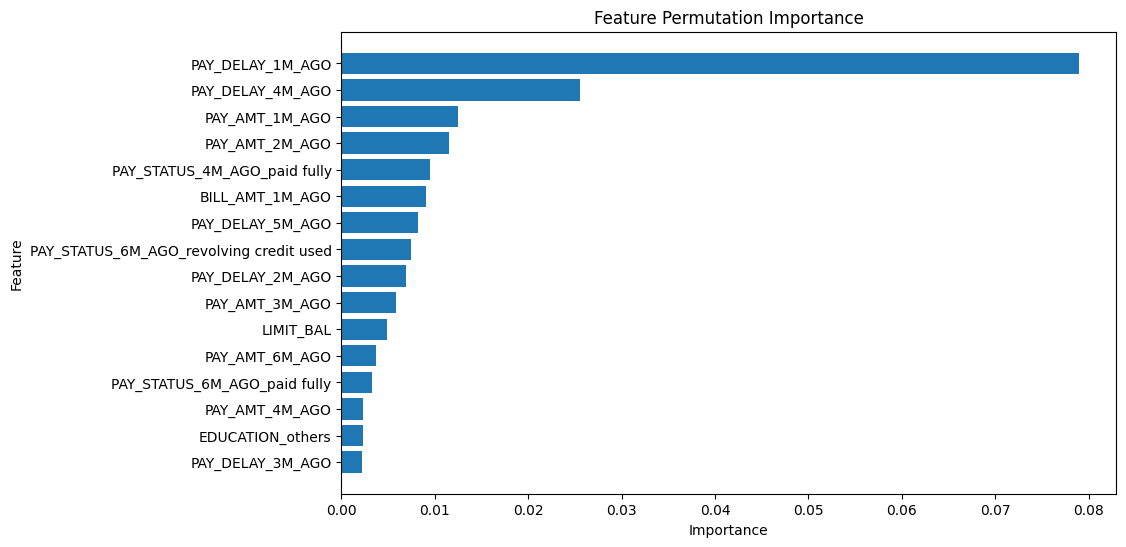

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_paid fully
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_AMT_1M_

In [ ]:
dt2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   765  3715  958   562      44.40   57.65        79.50     74.67     50.16   
1   567  3901  772   760      42.35   42.73        83.48     74.47     42.54   
2   380  4101  572   947      39.92   28.64        87.76     74.68     33.35   
3   355  4177  496   972      41.72   26.75        89.39     75.53     32.60   
4    32  4609   64  1295      33.33    2.41        98.63     77.35      4.50   
5    32  4609   64  1295      33.33    2.41        98.63     77.35      4.50   
6     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               68.57                 0   
1               63.10                 1   
2               58.20                 2   
3               58.07                 3   
4               50.52                 4   
5               50.52                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:17:30.948161

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
dt2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   765  3715  958   562      44.40   57.65        79.50     74.67     50.16   
1   672  3746  927   655      42.03   50.64        80.16     73.63     45.93   
2   640  3813  860   687      42.67   48.23        81.60     74.22     45.28   
3   582  3940  733   745      44.26   43.86        84.31     75.37     44.06   
4   540  4101  572   787      48.56   40.69        87.76     77.35     44.28   
5   546  4084  589   781      48.11   41.15        87.40     77.17     44.35   
6   494  4207  466   833      51.46   37.23        90.03     78.35     43.20   
7   428  4285  388   899      52.45   32.25        91.70     78.55     39.94   
8   423  4294  379   904      52.74   31.88        91.89     78.62     39.74   
9   137  4519  154  1190      47.08   10.32        96.70     77.60     16.93   
10   82  4597   76  1245      51.90    6.18        98.37     77.98     11.04   
11   72  4600   73  1255      49.66    5.43        98.44     77.87      9.78   
12   72  4600   73  1255      49.66    5.43        98.44     77.87      9.78   
13   76  4604   69  1251      52.41    5.73        98.52     78.00     10.33   
14   74  4608   65  1253      53.24    5.58        98.61     78.03     10.10   
15   56  4636   37  1271      60.22    4.22        99.21     78.20      7.89   
16   39  4641   32  1288      54.93    2.94        99.32     78.00      5.58   
17   40  4640   33  1287      54.79    3.01        99.29     78.00      5.71   
18   24  4648   25  1303      48.98    1.81        99.47     77.87      3.49   
19   59  4633   40  1268      59.60    4.45        99.14     78.20      8.27   
20   21  4663   10  1306      67.74    1.58        99.79     78.07      3.09   

    balanced_accuracy  num_feat_missing  \
0               68.57                 0   
1               65.40                 1   
2               64.91                 2   
3               64.09                 3   
4               64.23                 4   
5               64.27                 5   
6               63.63                 6   
7               61.98                 7   
8               61.88                 8   
9               53.51                 9   
10              52.28                10   
11              51.93                11   
12              51.93                12   
13              52.13                13   
14              52.09                14   
15              51.71                15   
16              51.13                16   
17              51.15                17   
18              50.64                18   
19              51.80                19   
20              50.68                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
dt2_perf_temp, dt2_orig_missing_temp, dt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
dt2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  765  3715  958   562      44.40   57.65        79.50     74.67     50.16   
1  482  4179  494   845      49.39   36.32        89.43     77.68     41.86   
2  280  4392  281  1047      49.91   21.10        93.99     77.87     29.66   
3    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              68.57                 0   
1              62.88                 4   
2              57.54                 7   
3              50.00                10   
4              50.00                13   
5              50.00                17   
6              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_temp_mf, dt2_orig_missing_temp_mf, dt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:21:48.169429

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
dt2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  765  3715  958   562      44.40   57.65        79.50     74.67     50.16   
1  531  4088  585   796      47.58   40.02        87.48     76.98     43.47   
2  500  4168  505   827      49.75   37.68        89.19     77.80     42.88   
3  347  4357  316   980      52.34   26.15        93.24     78.40     34.87   
4  146  4512  161  1181      47.56   11.00        96.55     77.63     17.87   
5  149  4512  161  1178      48.06   11.23        96.55     77.68     18.20   
6   17  4648   25  1310      40.48    1.28        99.47     77.75      2.48   

   balanced_accuracy  num_feat_missing  \
0              68.57                 0   
1              63.75                 4   
2              63.44                 7   
3              59.69                10   
4              53.78                13   
5              53.89                17   
6              50.37                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [300],
    'max_features': ['sqrt'],
    'min_samples_split': [0.01],
    'min_samples_leaf': [1],
    'max_depth': [None],
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 20:23:04.950360

Nested Cross-validation Results:
Individual scores: [0.72471021 0.71671564 0.71305602]
Average nested CV score: 0.718 (+/- 0.010)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.718
2025-01-18 20:23:34.064949

Execution time: 0.49 minutes


```
Starting hyperparameter tuning at: 2025-01-18 01:02:54.553203

Nested Cross-validation Results:
Individual scores: [0.72479404 0.71375566 0.71244253]
Average nested CV score: 0.717 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.01, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.718
2025-01-18 02:21:20.607341

Execution time: 78.43 minutes
```

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.050925  0.000922
8                            PAY_AMT_1M_AGO    0.014129  0.000416
13                           PAY_AMT_4M_AGO    0.013439  0.000668
11                           PAY_AMT_3M_AGO    0.013341  0.000501
29                          BILL_AMT_1M_AGO    0.013258  0.000678
9                            PAY_AMT_2M_AGO    0.012186  0.000840
7                                 LIMIT_BAL    0.009732  0.000633
15                           PAY_AMT_6M_AGO    0.008639  0.000644
31                          BILL_AMT_6M_AGO    0.008047  0.000522
14                           PAY_AMT_5M_AGO    0.006567  0.000407
6   PAY_STATUS_1M_AGO_revolving credit used    0.004833  0.000671
2                          PAY_DELAY_3M_AGO    0.004008  0.000817
30                                      AGE    0.003310  0.000574
1                          PAY_DELAY_2M_AGO    0.003108  0.000541
10  PAY_STATUS_3M_AGO_revolving credit used    0.002575  0.000325
18             PAY_STATUS_3M_AGO_paid fully    0.002312  0.000425
22             PAY_STATUS_1M_AGO_paid fully    0.002112  0.000318
19             PAY_STATUS_2M_AGO_paid fully    0.002052  0.000231
23             PAY_STATUS_6M_AGO_paid fully    0.001801  0.000365
17  PAY_STATUS_6M_AGO_revolving credit used    0.001638  0.000354
4                          PAY_DELAY_5M_AGO    0.001577  0.000784
25                     EDUCATION_university    0.001566  0.000274
3                          PAY_DELAY_4M_AGO    0.001366  0.000905
26                                 SEX_male    0.001263  0.000439
28                          MARRIAGE_single    0.001109  0.000162
20             PAY_STATUS_4M_AGO_paid fully    0.001100  0.000333
21             PAY_STATUS_5M_AGO_paid fully    0.001009  0.000240
24                         EDUCATION_others    0.000922  0.000210
12  PAY_STATUS_4M_AGO_revolving credit used    0.000724  0.000305
16  PAY_STATUS_5M_AGO_revolving credit used    0.000501  0.000200
5                          PAY_DELAY_6M_AGO    0.000397  0.000405
27                    EDUCATION_high school    0.000205  0.000048
32                          MARRIAGE_others    0.000086  0.000040

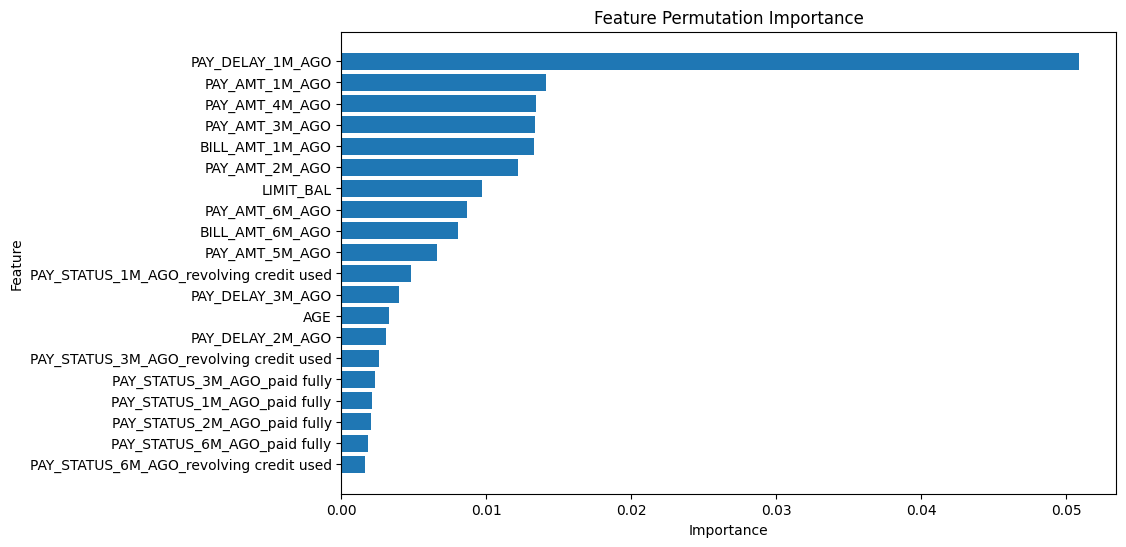

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_3M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_3M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat remov

In [ ]:
rf2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   812  3779  894   515      47.60   61.19        80.87     76.52     53.54   
1   682  3900  773   645      46.87   51.39        83.46     76.37     49.03   
2   595  4056  617   732      49.09   44.84        86.80     77.52     46.87   
3   582  4095  578   745      50.17   43.86        87.63     77.95     46.80   
4   554  4142  531   773      51.06   41.75        88.64     78.27     45.94   
5   533  4178  495   794      51.85   40.17        89.41     78.52     45.27   
6   537  4188  485   790      52.54   40.47        89.62     78.75     45.72   
7   498  4232  441   829      53.04   37.53        90.56     78.83     43.95   
8   490  4242  431   837      53.20   36.93        90.78     78.87     43.59   
9   490  4241  432   837      53.15   36.93        90.76     78.85     43.57   
10  468  4274  399   859      53.98   35.27        91.46     79.03     42.66   
11  478  4251  422   849      53.11   36.02        90.97     78.82     42.93   
12  397  4357  316   930      55.68   29.92        93.24     79.23     38.92   
13  397  4357  316   930      55.68   29.92        93.24     79.23     38.92   
14  306  4442  231  1021      56.98   23.06        95.06     79.13     32.83   
15  306  4441  232  1021      56.88   23.06        95.04     79.12     32.82   
16  306  4441  232  1021      56.88   23.06        95.04     79.12     32.82   
17  306  4441  232  1021      56.88   23.06        95.04     79.12     32.82   
18  223  4534  139  1104      61.60   16.80        97.03     79.28     26.41   
19  223  4534  139  1104      61.60   16.80        97.03     79.28     26.41   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.03                 0   
1               67.43                 1   
2               65.82                 2   
3               65.74                 3   
4               65.19                 4   
5               64.79                 5   
6               65.04                 6   
7               64.05                 7   
8               63.85                 8   
9               63.84                 9   
10              63.36                10   
11              63.50                11   
12              61.58                12   
13              61.58                13   
14              59.06                14   
15              59.05                15   
16              59.05                16   
17              59.05                17   
18              56.92                18   
19              56.92                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2      ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
4   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
5   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
6   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
7   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
8   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
9   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
10  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
11  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
12  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
13  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
14  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
15  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
16  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
17  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
18  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
19  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
20  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:24:00.507497

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
rf2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   812  3779  894   515      47.60   61.19        80.87     76.52     53.54   
1   714  3832  841   613      45.92   53.81        82.00     75.77     49.55   
2   687  3910  763   640      47.38   51.77        83.67     76.62     49.48   
3   617  4025  648   710      48.77   46.50        86.13     77.37     47.61   
4   584  4100  573   743      50.48   44.01        87.74     78.07     47.02   
5   569  4112  561   758      50.35   42.88        87.99     78.02     46.32   
6   563  4132  541   764      51.00   42.43        88.42     78.25     46.32   
7   555  4138  535   772      50.92   41.82        88.55     78.22     45.92   
8   557  4145  528   770      51.34   41.97        88.70     78.37     46.19   
9   575  4122  551   752      51.07   43.33        88.21     78.28     46.88   
10  577  4110  563   750      50.61   43.48        87.95     78.12     46.78   
11  571  4125  548   756      51.03   43.03        88.27     78.27     46.69   
12  553  4154  519   774      51.59   41.67        88.89     78.45     46.10   
13  549  4158  515   778      51.60   41.37        88.98     78.45     45.92   
14  281  4474  199  1046      58.54   21.18        95.74     79.25     31.10   
15  278  4480  193  1049      59.02   20.95        95.87     79.30     30.92   
16  278  4481  192  1049      59.15   20.95        95.89     79.32     30.94   
17  278  4480  193  1049      59.02   20.95        95.87     79.30     30.92   
18  227  4528  145  1100      61.02   17.11        96.90     79.25     26.72   
19  227  4528  145  1100      61.02   17.11        96.90     79.25     26.72   
20   15  4666    7  1312      68.18    1.13        99.85     78.02      2.22   

    balanced_accuracy  num_feat_missing  \
0               71.03                 0   
1               67.90                 1   
2               67.72                 2   
3               66.31                 3   
4               65.87                 4   
5               65.44                 5   
6               65.42                 6   
7               65.19                 7   
8               65.34                 8   
9               65.77                 9   
10              65.72                10   
11              65.65                11   
12              65.28                12   
13              65.18                13   
14              58.46                14   
15              58.41                15   
16              58.42                16   
17              58.41                17   
18              57.00                18   
19              57.00                19   
20              50.49                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2      ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
4   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
5   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
6   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
7   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
8   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
9   ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
10  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
11  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
12  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
13  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
14  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
15  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
16  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
17  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
18  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
19  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...  
20  ['PAY_DELAY_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AM...

In [ ]:
rf2_perf_temp, rf2_orig_missing_temp, rf2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
rf2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  812  3779  894   515      47.60   61.19        80.87     76.52     53.54   
1  588  4044  629   739      48.32   44.31        86.54     77.20     46.23   
2  547  4110  563   780      49.28   41.22        87.95     77.62     44.89   
3  465  4238  435   862      51.67   35.04        90.69     78.38     41.76   
4  306  4427  246  1021      55.43   23.06        94.74     78.88     32.57   
5  254  4494  179  1073      58.66   19.14        96.17     79.13     28.86   
6   35  4655   18  1292      66.04    2.64        99.61     78.17      5.07   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.03                 0   
1              65.43                 4   
2              64.59                 7   
3              62.87                10   
4              58.90                13   
5              57.66                14   
6              51.13                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_temp_mf, rf2_orig_missing_temp_mf, rf2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:28:12.001854

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
rf2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  812  3779  894   515      47.60   61.19        80.87     76.52     53.54   
1  573  4099  574   754      49.96   43.18        87.72     77.87     46.32   
2  546  4139  534   781      50.56   41.15        88.57     78.08     45.37   
3  507  4199  474   820      51.68   38.21        89.86     78.43     43.93   
4  251  4495  178  1076      58.51   18.91        96.19     79.10     28.59   
5  217  4513  160  1110      57.56   16.35        96.58     78.83     25.47   
6  247  4455  218  1080      53.12   18.61        95.33     78.37     27.57   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.03                 0   
1              65.45                 4   
2              64.86                 7   
3              64.03                10   
4              57.55                13   
5              56.46                14   
6              56.97                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [200],
      'max_depth': [2],
      'min_child_samples': [25],
      'min_split_gain': [0.5],
      'reg_lambda': [10.0]
  }

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 20:29:40.214109

Nested Cross-validation Results:
Individual scores: [0.72735794 0.71617243 0.70967163]
Average nested CV score: 0.718 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 25, 'min_split_gain': 0.5, 'n_estimators': 200, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.718
2025-01-18 20:29:45.002426

Execution time: 0.08 minutes


```
Starting hyperparameter tuning at: 2025-01-17 17:38:53.180781

Nested Cross-validation Results:
Individual scores: [0.72351589 0.71505201 0.70603468]
Average nested CV score: 0.715 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 25, 'min_split_gain': 0.5, 'n_estimators': 200, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.718
2025-01-17 17:48:24.897510

Execution time: 9.53 minutes
```

In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.067275  0.001843
29                          BILL_AMT_1M_AGO    0.009762  0.000746
7                                 LIMIT_BAL    0.007335  0.001348
11                           PAY_AMT_3M_AGO    0.004398  0.000904
9                            PAY_AMT_2M_AGO    0.004373  0.000726
8                            PAY_AMT_1M_AGO    0.004247  0.001167
2                          PAY_DELAY_3M_AGO    0.003189  0.000675
3                          PAY_DELAY_4M_AGO    0.002456  0.000704
31                          BILL_AMT_6M_AGO    0.002418  0.000637
1                          PAY_DELAY_2M_AGO    0.002299  0.000694
13                           PAY_AMT_4M_AGO    0.002095  0.000813
24                         EDUCATION_others    0.001591  0.000526
22             PAY_STATUS_1M_AGO_paid fully    0.001548  0.000473
4                          PAY_DELAY_5M_AGO    0.001365  0.000884
28                          MARRIAGE_single    0.000978  0.000690
5                          PAY_DELAY_6M_AGO    0.000905  0.000524
15                           PAY_AMT_6M_AGO    0.000740  0.000520
18             PAY_STATUS_3M_AGO_paid fully    0.000600  0.000226
32                          MARRIAGE_others    0.000300  0.000124
30                                      AGE    0.000261  0.000404
19             PAY_STATUS_2M_AGO_paid fully    0.000131  0.000180
23             PAY_STATUS_6M_AGO_paid fully    0.000114  0.000387
6   PAY_STATUS_1M_AGO_revolving credit used    0.000075  0.000078
16  PAY_STATUS_5M_AGO_revolving credit used    0.000035  0.000124
14                           PAY_AMT_5M_AGO   -0.000004  0.000228
12  PAY_STATUS_4M_AGO_revolving credit used   -0.000130  0.000213
25                     EDUCATION_university   -0.000210  0.000184
26                                 SEX_male   -0.000318  0.000451

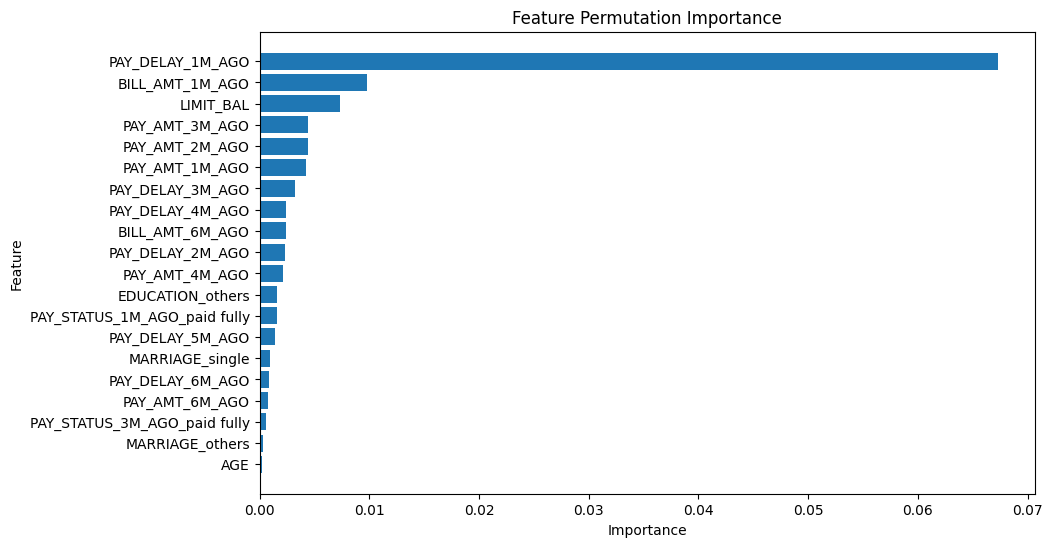

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['P

In [ ]:
gbt2_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   828  3659  1014   499      44.95   62.40        78.30     74.78     52.26   
1   598  3879   794   729      42.96   45.06        83.01     74.62     43.99   
2   470  4195   478   857      49.58   35.42        89.77     77.75     41.32   
3   440  4267   406   887      52.01   33.16        91.31     78.45     40.50   
4   404  4319   354   923      53.30   30.44        92.42     78.72     38.75   
5   390  4354   319   937      55.01   29.39        93.17     79.07     38.31   
6   362  4385   288   965      55.69   27.28        93.84     79.12     36.62   
7   269  4495   178  1058      60.18   20.27        96.19     79.40     30.33   
8   188  4578    95  1139      66.43   14.17        97.97     79.43     23.35   
9   171  4588    85  1156      66.80   12.89        98.18     79.32     21.60   
10   27  4655    18  1300      60.00    2.03        99.61     78.03      3.94   
11   32  4663    10  1295      76.19    2.41        99.79     78.25      4.67   
12   10  4668     5  1317      66.67    0.75        99.89     77.97      1.49   
13    9  4668     5  1318      64.29    0.68        99.89     77.95      1.34   
14    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.35                 0   
1               64.04                 1   
2               62.59                 2   
3               62.23                 3   
4               61.43                 4   
5               61.28                 5   
6               60.56                 6   
7               58.23                 7   
8               56.07                 8   
9               55.53                 9   
10              50.82                10   
11              51.10                11   
12              50.32                12   
13              50.29                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:29:51.052325

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
gbt2_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    828  3659  1014  499      44.95   62.40        78.30     74.78     52.26   
1   1064  2372  2301  263      31.62   80.18        50.76     57.27     45.35   
2   1003  2691  1982  324      33.60   75.58        57.59     61.57     46.52   
3    918  3002  1671  409      35.46   69.18        64.24     65.33     46.88   
4    862  3198  1475  465      36.88   64.96        68.44     67.67     47.05   
5    819  3323  1350  508      37.76   61.72        71.11     69.03     46.85   
6    791  3412  1261  536      38.55   59.61        73.02     70.05     46.82   
7    783  3405  1268  544      38.18   59.01        72.87     69.80     46.36   
8    873  2930  1743  454      33.37   65.79        62.70     63.38     44.28   
9   1011  2347  2326  316      30.30   76.19        50.22     55.97     43.35   
10   878  2633  2040  449      30.09   66.16        56.34     58.52     41.37   
11   868  2623  2050  459      29.75   65.41        56.13     58.18     40.90   
12   891  2522  2151  436      29.29   67.14        53.97     56.88     40.79   
13   874  2560  2113  453      29.26   65.86        54.78     57.23     40.52   
14  1102  1369  3304  225      25.01   83.04        29.30     41.18     38.44   
15  1076  1416  3257  251      24.83   81.09        30.30     41.53     38.02   
16  1238   574  4099   89      23.20   93.29        12.28     30.20     37.15   
17  1296   176  4497   31      22.37   97.66         3.77     24.53     36.40   
18  1297   187  4486   30      22.43   97.74         4.00     24.73     36.48   
19  1320    89  4584    7      22.36   99.47         1.90     23.48     36.51   
20  1320    85  4588    7      22.34   99.47         1.82     23.42     36.49   

    balanced_accuracy  num_feat_missing  \
0               70.35                 0   
1               65.47                 1   
2               66.59                 2   
3               66.71                 3   
4               66.70                 4   
5               66.41                 5   
6               66.31                 6   
7               65.94                 7   
8               64.24                 8   
9               63.21                 9   
10              61.25                10   
11              60.77                11   
12              60.56                12   
13              60.32                13   
14              56.17                14   
15              55.69                15   
16              52.79                16   
17              50.72                17   
18              50.87                18   
19              50.69                19   
20              50.65                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
gbt2_perf_temp, gbt2_orig_missing_temp, gbt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
gbt2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  828  3659  1014   499      44.95   62.40        78.30     74.78     52.26   
1  417  4303   370   910      52.99   31.42        92.08     78.67     39.45   
2  381  4343   330   946      53.59   28.71        92.94     78.73     37.39   
3  269  4507   166  1058      61.84   20.27        96.45     79.60     30.53   
4  219  4536   137  1108      61.52   16.50        97.07     79.25     26.02   
5   55  4646    27  1272      67.07    4.14        99.42     78.35      7.81   
6    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.35                 0   
1              61.75                 4   
2              60.82                 5   
3              58.36                 8   
4              56.79                11   
5              51.78                14   
6              50.00                18   
7              50.00                19   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_temp_mf, gbt2_orig_missing_temp_mf, gbt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:34:03.289074

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
gbt2_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   828  3659  1014  499      44.95   62.40        78.30     74.78     52.26   
1   861  3203  1470  466      36.94   64.88        68.54     67.73     47.07   
2   839  3291  1382  488      37.78   63.23        70.43     68.83     47.29   
3   731  3544  1129  596      39.30   55.09        75.84     71.25     45.87   
4   615  3692   981  712      38.53   46.35        79.01     71.78     42.08   
5   626  3483  1190  701      34.47   47.17        74.53     68.48     39.83   
6  1242   589  4084   85      23.32   93.59        12.60     30.52     37.34   
7  1257   479  4194   70      23.06   94.72        10.25     28.93     37.09   
8  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

   balanced_accuracy  num_feat_missing  \
0              70.35                 0   
1              66.71                 4   
2              66.83                 5   
3              65.46                 8   
4              62.68                11   
5              60.85                14   
6              53.10                18   
7              52.49                19   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[0.0],
    'gamma': [0.5],
    'colsample_bytree':[0.5]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 20:35:43.599391

Nested Cross-validation Results:
Individual scores: [0.72715554 0.71662813 0.70987068]
Average nested CV score: 0.718 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.5, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0.0}

Best Model Performance:
Best CV score: 0.718
2025-01-18 20:35:47.123159

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-17 17:48:24.906853

Nested Cross-validation Results:
Individual scores: [0.72537942 0.71378377 0.70967798]
Average nested CV score: 0.716 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.5, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0}

Best Model Performance:
Best CV score: 0.718
2025-01-17 18:07:02.169218

Execution time: 18.62 minutes
```

In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.044581  0.001215
29                          BILL_AMT_1M_AGO    0.016548  0.000379
1                          PAY_DELAY_2M_AGO    0.010624  0.000778
7                                 LIMIT_BAL    0.010558  0.001138
9                            PAY_AMT_2M_AGO    0.006956  0.000950
8                            PAY_AMT_1M_AGO    0.006578  0.001135
11                           PAY_AMT_3M_AGO    0.005803  0.001072
3                          PAY_DELAY_4M_AGO    0.005623  0.000957
13                           PAY_AMT_4M_AGO    0.003120  0.000883
31                          BILL_AMT_6M_AGO    0.002240  0.000157
24                         EDUCATION_others    0.002087  0.000441
2                          PAY_DELAY_3M_AGO    0.002058  0.000954
15                           PAY_AMT_6M_AGO    0.001953  0.000280
5                          PAY_DELAY_6M_AGO    0.001814  0.000657
23             PAY_STATUS_6M_AGO_paid fully    0.001625  0.000544
30                                      AGE    0.001614  0.000480
6   PAY_STATUS_1M_AGO_revolving credit used    0.001555  0.000652
14                           PAY_AMT_5M_AGO    0.001486  0.000848
12  PAY_STATUS_4M_AGO_revolving credit used    0.001432  0.000641
25                     EDUCATION_university    0.001202  0.000339
10  PAY_STATUS_3M_AGO_revolving credit used    0.000935  0.000691
28                          MARRIAGE_single    0.000778  0.000770
4                          PAY_DELAY_5M_AGO    0.000757  0.000395
26                                 SEX_male    0.000639  0.000475
32                          MARRIAGE_others    0.000486  0.000251
17  PAY_STATUS_6M_AGO_revolving credit used    0.000387  0.000121
16  PAY_STATUS_5M_AGO_revolving credit used    0.000331  0.000307
18             PAY_STATUS_3M_AGO_paid fully    0.000296  0.000336
22             PAY_STATUS_1M_AGO_paid fully   -0.000364  0.000137
19             PAY_STATUS_2M_AGO_paid fully   -0.000564  0.000330

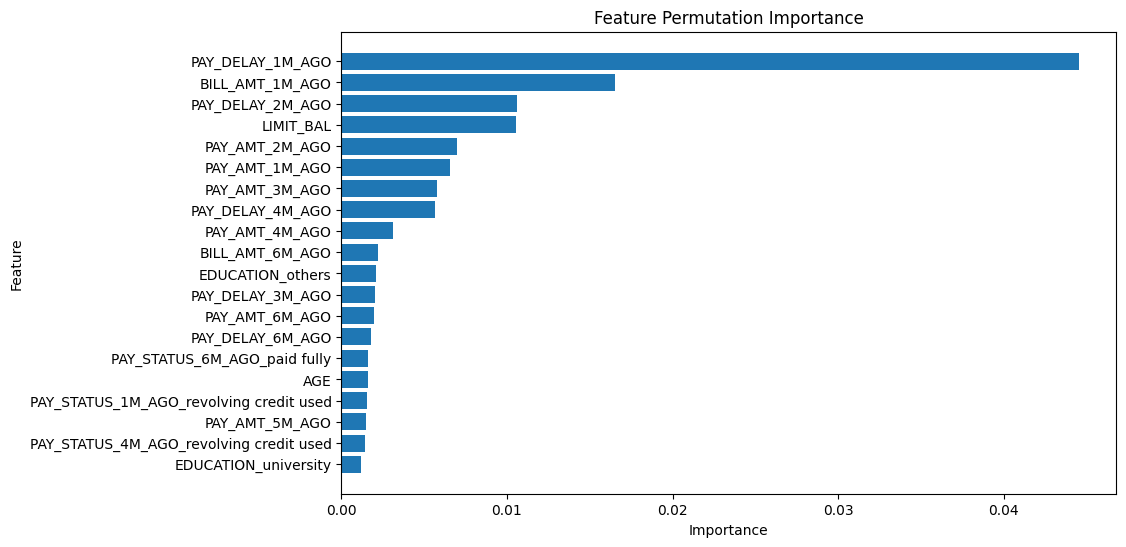

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed

In [ ]:
xgb2_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   840  3638  1035   487      44.80   63.30        77.85     74.63     52.47   
1   736  3718   955   591      43.52   55.46        79.56     74.23     48.77   
2   568  4121   552   759      50.71   42.80        88.19     78.15     46.42   
3   427  4261   412   900      50.89   32.18        91.18     78.13     39.43   
4   361  4356   317   966      53.24   27.20        93.22     78.62     36.01   
5   358  4388   285   969      55.68   26.98        93.90     79.10     36.35   
6   372  4351   322   955      53.60   28.03        93.11     78.72     36.81   
7   351  4389   284   976      55.28   26.45        93.92     79.00     35.78   
8   201  4527   146  1126      57.93   15.15        96.88     78.80     24.01   
9   244  4514   159  1083      60.55   18.39        96.60     79.30     28.21   
10  218  4530   143  1109      60.39   16.43        96.94     79.13     25.83   
11  212  4542   131  1115      61.81   15.98        97.20     79.23     25.39   
12  103  4621    52  1224      66.45    7.76        98.89     78.73     13.90   
13   73  4640    33  1254      68.87    5.50        99.29     78.55     10.19   
14    1  4673     0  1326     100.00    0.08       100.00     77.90      0.15   
15    1  4673     0  1326     100.00    0.08       100.00     77.90      0.15   
16    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.58                 0   
1               67.51                 1   
2               65.50                 2   
3               61.68                 3   
4               60.21                 4   
5               60.44                 5   
6               60.57                 6   
7               60.19                 7   
8               56.01                 8   
9               57.49                 9   
10              56.68                10   
11              56.59                11   
12              53.32                12   
13              52.40                13   
14              50.04                14   
15              50.04                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())


xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:35:49.979728

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
xgb2_perf_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   840  3638  1035   487      44.80   63.30        77.85     74.63     52.47   
1   740  3711   962   587      43.48   55.76        79.41     74.18     48.86   
2   657  3943   730   670      47.37   49.51        84.38     76.67     48.42   
3   521  4087   586   806      47.06   39.26        87.46     76.80     42.81   
4   460  4193   480   867      48.94   34.66        89.73     77.55     40.58   
5   398  4294   379   929      51.22   29.99        91.89     78.20     37.83   
6   396  4291   382   931      50.90   29.84        91.83     78.12     37.62   
7   379  4352   321   948      54.14   28.56        93.13     78.85     37.40   
8   320  4415   258  1007      55.36   24.11        94.48     78.92     33.60   
9   256  4493   180  1071      58.72   19.29        96.15     79.15     29.04   
10  293  4461   212  1034      58.02   22.08        95.46     79.23     31.99   
11  299  4453   220  1028      57.61   22.53        95.29     79.20     32.39   
12  147  4574    99  1180      59.76   11.08        97.88     78.68     18.69   
13  100  4611    62  1227      61.73    7.54        98.67     78.52     13.43   
14   47  4644    29  1280      61.84    3.54        99.38     78.18      6.70   
15   47  4643    30  1280      61.04    3.54        99.36     78.17      6.70   
16   36  4647    26  1291      58.06    2.71        99.44     78.05      5.18   
17   35  4645    28  1292      55.56    2.64        99.40     78.00      5.04   
18   28  4651    22  1299      56.00    2.11        99.53     77.98      4.07   
19   26  4654    19  1301      57.78    1.96        99.59     78.00      3.79   
20   26  4653    20  1301      56.52    1.96        99.57     77.98      3.79   

    balanced_accuracy  num_feat_missing  \
0               70.58                 0   
1               67.59                 1   
2               66.94                 2   
3               63.36                 3   
4               62.20                 4   
5               60.94                 5   
6               60.83                 6   
7               60.85                 7   
8               59.30                 8   
9               57.72                 9   
10              58.77                10   
11              58.91                11   
12              54.48                12   
13              53.10                13   
14              51.46                14   
15              51.45                15   
16              51.08                16   
17              51.02                17   
18              50.82                18   
19              50.78                19   
20              50.77                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_D...

In [ ]:
xgb2_perf_temp, xgb2_orig_missing_temp, xgb2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
xgb2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  840  3638  1035   487      44.80   63.30        77.85     74.63     52.47   
1  638  3940   733   689      46.54   48.08        84.31     76.30     47.29   
2  468  4159   514   859      47.66   35.27        89.00     77.12     40.54   
3  378  4302   371   949      50.47   28.49        92.06     78.00     36.42   
4  306  4403   270  1021      53.12   23.06        94.22     78.48     32.16   
5  242  4472   201  1085      54.63   18.24        95.70     78.57     27.34   
6   21  4660    13  1306      61.76    1.58        99.72     78.02      3.09   
7   17  4667     6  1310      73.91    1.28        99.87     78.07      2.52   
8    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.58                 0   
1              66.20                 4   
2              62.13                 7   
3              60.27                 8   
4              58.64                11   
5              56.97                14   
6              50.65                18   
7              50.58                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_temp_mf, xgb2_orig_missing_temp_mf, xgb2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:39:58.717673

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
xgb2_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  840  3638  1035   487      44.80   63.30        77.85     74.63     52.47   
1  577  4050   623   750      48.08   43.48        86.67     77.12     45.67   
2  383  4285   388   944      49.68   28.86        91.70     77.80     36.51   
3  367  4313   360   960      50.48   27.66        92.30     78.00     35.74   
4  208  4518   155  1119      57.30   15.67        96.68     78.77     24.62   
5   89  4620    53  1238      62.68    6.71        98.87     78.48     12.12   
6   37  4645    28  1290      56.92    2.79        99.40     78.03      5.32   
7   46  4643    30  1281      60.53    3.47        99.36     78.15      6.56   
8   34  4646    27  1293      55.74    2.56        99.42     78.00      4.90   

   balanced_accuracy  num_feat_missing  \
0              70.58                 0   
1              65.07                 4   
2              60.28                 7   
3              59.98                 8   
4              56.18                11   
5              52.79                14   
6              51.09                18   
7              51.41                19   
8              50.99                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [200],
      'max_depth': [None],
      'max_features':[0.5],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 20:41:39.706932

Nested Cross-validation Results:
Individual scores: [0.71719844 0.72062238 0.70600657]
Average nested CV score: 0.715 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.715
2025-01-18 20:42:02.265011

Execution time: 0.38 minutes


```
Starting hyperparameter tuning at: 2025-01-17 19:52:23.542918

Nested Cross-validation Results:
Individual scores: [0.71798655 0.70950295 0.70589729]
Average nested CV score: 0.711 (+/- 0.010)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.715
2025-01-17 20:43:02.683004

Execution time: 50.65 minutes
```




In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.061029  0.001005
7                                 LIMIT_BAL    0.031741  0.000762
6   PAY_STATUS_1M_AGO_revolving credit used    0.029107  0.001181
1                          PAY_DELAY_2M_AGO    0.022547  0.000724
29                          BILL_AMT_1M_AGO    0.022258  0.000610
17  PAY_STATUS_6M_AGO_revolving credit used    0.022225  0.001305
8                            PAY_AMT_1M_AGO    0.017742  0.001757
31                          BILL_AMT_6M_AGO    0.016472  0.000555
9                            PAY_AMT_2M_AGO    0.015928  0.000881
13                           PAY_AMT_4M_AGO    0.015679  0.000958
11                           PAY_AMT_3M_AGO    0.015440  0.001235
10  PAY_STATUS_3M_AGO_revolving credit used    0.015014  0.000710
26                                 SEX_male    0.012405  0.000910
22             PAY_STATUS_1M_AGO_paid fully    0.012346  0.000432
19             PAY_STATUS_2M_AGO_paid fully    0.012172  0.000612
15                           PAY_AMT_6M_AGO    0.012156  0.001162
25                     EDUCATION_university    0.012137  0.000384
14                           PAY_AMT_5M_AGO    0.012109  0.001306
28                          MARRIAGE_single    0.011949  0.001721
18             PAY_STATUS_3M_AGO_paid fully    0.011866  0.000843
2                          PAY_DELAY_3M_AGO    0.011664  0.001272
30                                      AGE    0.010345  0.000181
12  PAY_STATUS_4M_AGO_revolving credit used    0.010187  0.000223
16  PAY_STATUS_5M_AGO_revolving credit used    0.009907  0.000873
3                          PAY_DELAY_4M_AGO    0.008390  0.000600
20             PAY_STATUS_4M_AGO_paid fully    0.007619  0.000647
23             PAY_STATUS_6M_AGO_paid fully    0.007608  0.000323
4                          PAY_DELAY_5M_AGO    0.006917  0.000594
21             PAY_STATUS_5M_AGO_paid fully    0.006343  0.001072
27                    EDUCATION_high school    0.005553  0.000288
24                         EDUCATION_others    0.003561  0.000316
5                          PAY_DELAY_6M_AGO    0.003001  0.000254
32                          MARRIAGE_others    0.000570  0.000085

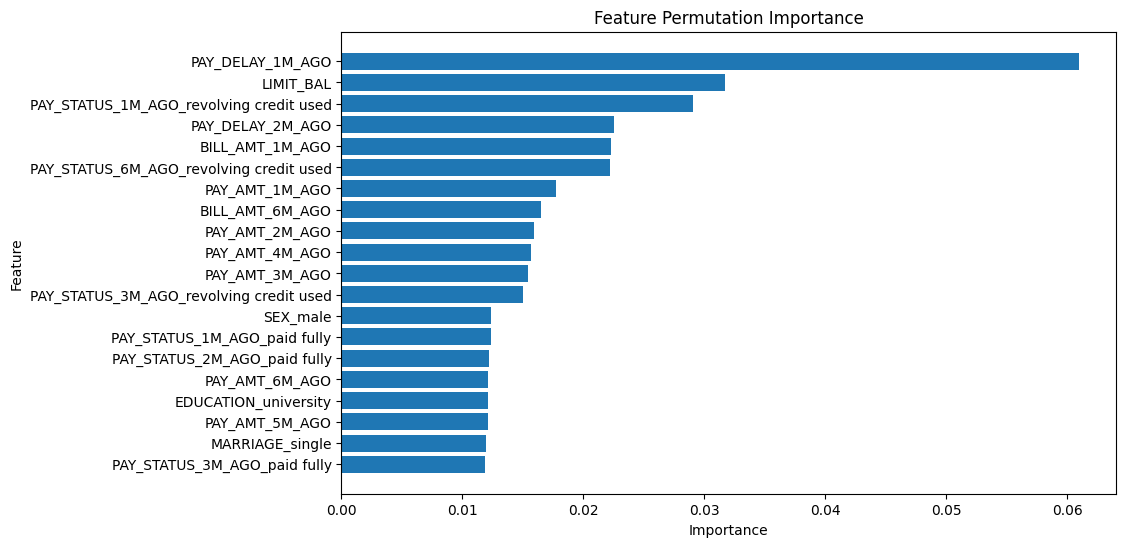

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STAT

In [ ]:
et2_perf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   808  3768  905  519      47.17   60.89        80.63     76.27     53.16   
1   669  3913  760  658      46.82   50.41        83.74     76.37     48.55   
2   614  4007  666  713      47.97   46.27        85.75     77.02     47.10   
3   607  3999  674  720      47.38   45.74        85.58     76.77     46.55   
4   422  4205  468  905      47.42   31.80        89.99     77.12     38.07   
5   408  4238  435  919      48.40   30.75        90.69     77.43     37.60   
6   409  4240  433  918      48.57   30.82        90.73     77.48     37.71   
7   413  4232  441  914      48.36   31.12        90.56     77.42     37.87   
8   413  4231  442  914      48.30   31.12        90.54     77.40     37.86   
9   415  4227  446  912      48.20   31.27        90.46     77.37     37.93   
10  415  4228  445  912      48.26   31.27        90.48     77.38     37.95   
11  412  4231  442  915      48.24   31.05        90.54     77.38     37.78   
12  421  4219  454  906      48.11   31.73        90.28     77.33     38.24   
13  421  4219  454  906      48.11   31.73        90.28     77.33     38.24   
14  421  4212  461  906      47.73   31.73        90.13     77.22     38.12   
15  421  4208  465  906      47.52   31.73        90.05     77.15     38.05   
16  421  4208  465  906      47.52   31.73        90.05     77.15     38.05   
17  421  4208  465  906      47.52   31.73        90.05     77.15     38.05   
18  421  4208  465  906      47.52   31.73        90.05     77.15     38.05   
19  421  4208  465  906      47.52   31.73        90.05     77.15     38.05   
20  421  4208  465  906      47.52   31.73        90.05     77.15     38.05   

    balanced_accuracy  num_feat_missing  \
0               70.76                 0   
1               67.08                 1   
2               66.01                 2   
3               65.66                 3   
4               60.89                 4   
5               60.72                 5   
6               60.78                 6   
7               60.84                 7   
8               60.83                 8   
9               60.86                 9   
10              60.88                10   
11              60.79                11   
12              61.01                12   
13              61.01                13   
14              60.93                14   
15              60.89                15   
16              60.89                16   
17              60.89                17   
18              60.89                18   
19              60.89                19   
20              60.89                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:42:25.749661

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
et2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   808  3768  905   519      47.17   60.89        80.63     76.27     53.16   
1   694  3833  840   633      45.24   52.30        82.02     75.45     48.51   
2   677  3855  818   650      45.28   51.02        82.50     75.53     47.98   
3   628  3922  751   699      45.54   47.32        83.93     75.83     46.42   
4   527  4033  640   800      45.16   39.71        86.30     76.00     42.26   
5   451  4201  472   876      48.86   33.99        89.90     77.53     40.09   
6   421  4240  433   906      49.30   31.73        90.73     77.68     38.61   
7   393  4286  387   934      50.38   29.62        91.72     77.98     37.30   
8   394  4293  380   933      50.90   29.69        91.87     78.12     37.51   
9   396  4287  386   931      50.64   29.84        91.74     78.05     37.55   
10  392  4286  387   935      50.32   29.54        91.72     77.97     37.23   
11  388  4287  386   939      50.13   29.24        91.74     77.92     36.93   
12  387  4294  379   940      50.52   29.16        91.89     78.02     36.98   
13  383  4298  375   944      50.53   28.86        91.98     78.02     36.74   
14  382  4305  368   945      50.93   28.79        92.12     78.12     36.78   
15  383  4300  373   944      50.66   28.86        92.02     78.05     36.77   
16  383  4315  358   944      51.69   28.86        92.34     78.30     37.04   
17  385  4298  375   942      50.66   29.01        91.98     78.05     36.90   
18  371  4342  331   956      52.85   27.96        92.92     78.55     36.57   
19  304  4441  232  1023      56.72   22.91        95.04     79.08     32.64   
20  304  4443  230  1023      56.93   22.91        95.08     79.12     32.67   

    balanced_accuracy  num_feat_missing  \
0               70.76                 0   
1               67.16                 1   
2               66.76                 2   
3               65.63                 3   
4               63.01                 4   
5               61.94                 5   
6               61.23                 6   
7               60.67                 7   
8               60.78                 8   
9               60.79                 9   
10              60.63                10   
11              60.49                11   
12              60.53                12   
13              60.42                13   
14              60.46                14   
15              60.44                15   
16              60.60                16   
17              60.49                17   
18              60.44                18   
19              58.97                19   
20              58.99                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...

In [ ]:
et2_perf_temp, et2_orig_missing_temp, et2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
et2_perf_temp

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0  808  3768  905  519      47.17   60.89        80.63     76.27     53.16   
1  596  4038  635  731      48.42   44.91        86.41     77.23     46.60   
2  600  4013  660  727      47.62   45.21        85.88     76.88     46.39   
3  412  4226  447  915      47.96   31.05        90.43     77.30     37.69   
4  414  4224  449  913      47.97   31.20        90.39     77.30     37.81   
5  329  4375  298  998      52.47   24.79        93.62     78.40     33.67   
6  329  4375  298  998      52.47   24.79        93.62     78.40     33.67   
7  329  4375  298  998      52.47   24.79        93.62     78.40     33.67   
8  329  4375  298  998      52.47   24.79        93.62     78.40     33.67   

   balanced_accuracy  num_feat_missing  \
0              70.76                 0   
1              65.66                 4   
2              65.55                 5   
3              60.74                 8   
4              60.79                12   
5              59.21                15   
6              59.21                18   
7              59.21                19   
8              59.21                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_temp_mf, et2_orig_missing_temp_mf, et2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:46:41.158495

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
et2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  808  3768  905   519      47.17   60.89        80.63     76.27     53.16   
1  530  4131  542   797      49.44   39.94        88.40     77.68     44.19   
2  506  4154  519   821      49.37   38.13        88.89     77.67     43.03   
3  418  4275  398   909      51.23   31.50        91.48     78.22     39.01   
4  374  4304  369   953      50.34   28.18        92.10     77.97     36.14   
5  379  4284  389   948      49.35   28.56        91.68     77.72     36.18   
6  275  4426  247  1052      52.68   20.72        94.71     78.35     29.75   
7  250  4452  221  1077      53.08   18.84        95.27     78.37     27.81   
8  284  4427  246  1043      53.58   21.40        94.74     78.52     30.59   

   balanced_accuracy  num_feat_missing  \
0              70.76                 0   
1              64.17                 4   
2              63.51                 5   
3              61.49                 8   
4              60.14                12   
5              60.12                15   
6              57.72                18   
7              57.06                19   
8              58.07                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5, 10, 100],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1]
  }
else:
  # best model
  svm2_param_grid = {
      'C': [10.0],
      'kernel': ['rbf'],
      'gamma': [0.1]
}

svm2_classifier = SVC(
    class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE
)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy',
    X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 20:48:22.251490

Nested Cross-validation Results:
Individual scores: [0.69842667 0.70636341 0.69763174]
Average nested CV score: 0.701 (+/- 0.008)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.701
2025-01-18 20:49:41.140583

Execution time: 1.31 minutes


```
Starting hyperparameter tuning at: 2025-01-17 21:04:23.477511

Nested Cross-validation Results:
Individual scores: [0.70152361 0.69670584 0.69763174]
Average nested CV score: 0.699 (+/- 0.004)

Fitting final model on entire dataset...
Fitting 3 folds for each of 56 candidates, totalling 168 fits
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.701
2025-01-17 22:21:54.009740

Execution time: 77.51 minutes
```

In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(
    svm2_classifier, X_train_scaled, y_train,
    scoring_metric="balanced_accuracy", n_repeats=3
)
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
6   PAY_STATUS_1M_AGO_revolving credit used    0.086800  0.003980
0                          PAY_DELAY_1M_AGO    0.024446  0.000740
22             PAY_STATUS_1M_AGO_paid fully    0.013612  0.000720
19             PAY_STATUS_2M_AGO_paid fully    0.010998  0.000923
1                          PAY_DELAY_2M_AGO    0.005340  0.000650
17  PAY_STATUS_6M_AGO_revolving credit used    0.004988  0.001497
10  PAY_STATUS_3M_AGO_revolving credit used    0.004581  0.000866
12  PAY_STATUS_4M_AGO_revolving credit used    0.004499  0.000821
28                          MARRIAGE_single    0.004193  0.000557
16  PAY_STATUS_5M_AGO_revolving credit used    0.003978  0.000413
25                     EDUCATION_university    0.003850  0.000275
26                                 SEX_male    0.003785  0.000479
21             PAY_STATUS_5M_AGO_paid fully    0.003751  0.000821
20             PAY_STATUS_4M_AGO_paid fully    0.003732  0.000322
7                                 LIMIT_BAL    0.003448  0.000735
18             PAY_STATUS_3M_AGO_paid fully    0.003444  0.000226
23             PAY_STATUS_6M_AGO_paid fully    0.003225  0.000710
2                          PAY_DELAY_3M_AGO    0.003091  0.000927
3                          PAY_DELAY_4M_AGO    0.002411  0.000621
27                    EDUCATION_high school    0.002347  0.000402
24                         EDUCATION_others    0.001505  0.000127
4                          PAY_DELAY_5M_AGO    0.001414  0.000552
30                                      AGE    0.000832  0.000044
14                           PAY_AMT_5M_AGO    0.000490  0.000164
5                          PAY_DELAY_6M_AGO    0.000483  0.000264
8                            PAY_AMT_1M_AGO    0.000396  0.000104
15                           PAY_AMT_6M_AGO    0.000374  0.000107
29                          BILL_AMT_1M_AGO    0.000272  0.000358
9                            PAY_AMT_2M_AGO    0.000265  0.000227
11                           PAY_AMT_3M_AGO    0.000198  0.000214
13                           PAY_AMT_4M_AGO    0.000077  0.000036
32                          MARRIAGE_others    0.000027  0.000090
31                          BILL_AMT_6M_AGO   -0.000580  0.000094

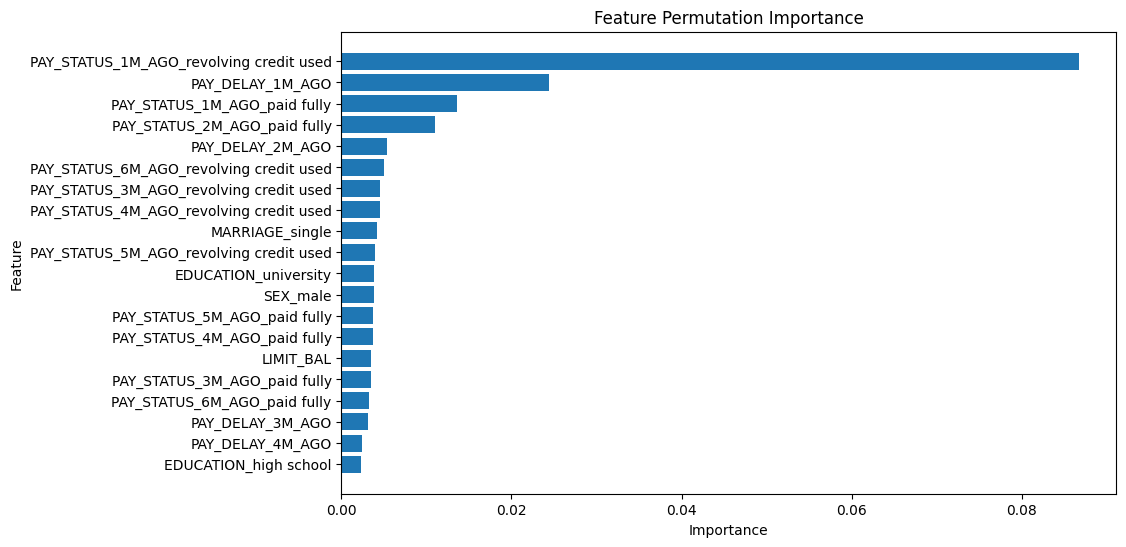

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_paid fully
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed

In [ ]:
svm2_perf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    752  3861   812  575      48.08   56.67        82.62     76.88     52.02   
1   1032  1828  2845  295      26.62   77.77        39.12     47.67     39.66   
2    942  1999  2674  385      26.05   70.99        42.78     49.02     38.11   
3    947  1953  2720  380      25.82   71.36        41.79     48.33     37.93   
4    933  1974  2699  394      25.69   70.31        42.24     48.45     37.63   
5    965  1822  2851  362      25.29   72.72        38.99     46.45     37.53   
6   1102  1257  3416  225      24.39   83.04        26.90     39.32     37.71   
7   1285   320  4353   42      22.79   96.83         6.85     26.75     36.90   
8   1279   339  4334   48      22.79   96.38         7.25     26.97     36.86   
9   1319    84  4589    8      22.33   99.40         1.80     23.38     36.46   
10  1327     2  4671    0      22.12  100.00         0.04     22.15     36.23   
11  1327     2  4671    0      22.12  100.00         0.04     22.15     36.23   
12  1327     2  4671    0      22.12  100.00         0.04     22.15     36.23   
13  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
14  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
15  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
16  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
17  1327     2  4671    0      22.12  100.00         0.04     22.15     36.23   
18  1327     2  4671    0      22.12  100.00         0.04     22.15     36.23   
19  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
20  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

    balanced_accuracy  num_feat_missing  \
0               69.65                 0   
1               58.44                 1   
2               56.88                 2   
3               56.58                 3   
4               56.28                 4   
5               55.86                 5   
6               54.97                 6   
7               51.84                 7   
8               51.82                 8   
9               50.60                 9   
10              50.02                10   
11              50.02                11   
12              50.02                12   
13              50.03                13   
14              50.03                14   
15              50.03                15   
16              50.03                16   
17              50.02                17   
18              50.02                18   
19              50.01                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:58:28.852222

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  2
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUC

In [ ]:
svm2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   752  3861  812   575      48.08   56.67        82.62     76.88     52.02   
1   580  3974  699   747      45.35   43.71        85.04     75.90     44.51   
2   545  4018  655   782      45.42   41.07        85.98     76.05     43.13   
3   544  4033  640   783      45.95   40.99        86.30     76.28     43.33   
4   509  4075  598   818      45.98   38.36        87.20     76.40     41.82   
5   489  4109  564   838      46.44   36.85        87.93     76.63     41.09   
6   405  4234  439   922      47.99   30.52        90.61     77.32     37.31   
7   378  4316  357   949      51.43   28.49        92.36     78.23     36.66   
8   362  4352  321   965      53.00   27.28        93.13     78.57     36.02   
9   333  4395  278   994      54.50   25.09        94.05     78.80     34.37   
10  334  4395  278   993      54.58   25.17        94.05     78.82     34.45   
11  333  4397  276   994      54.68   25.09        94.09     78.83     34.40   
12  333  4397  276   994      54.68   25.09        94.09     78.83     34.40   
13  289  4459  214  1038      57.46   21.78        95.42     79.13     31.58   
14  206  4528  145  1121      58.69   15.52        96.90     78.90     24.55   
15   12  4666    7  1315      63.16    0.90        99.85     77.97      1.78   
16   11  4666    7  1316      61.11    0.83        99.85     77.95      1.64   
17   11  4667    6  1316      64.71    0.83        99.87     77.97      1.64   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.65                 0   
1               64.37                 1   
2               63.53                 2   
3               63.65                 3   
4               62.78                 4   
5               62.39                 5   
6               60.56                 6   
7               60.42                 7   
8               60.21                 8   
9               59.57                 9   
10              59.61                10   
11              59.59                11   
12              59.59                12   
13              58.60                13   
14              56.21                14   
15              50.38                15   
16              50.34                16   
17              50.35                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm2_perf_temp, svm2_orig_missing_temp, svm2_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO    

In [ ]:
svm2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  752  3861  812   575      48.08   56.67        82.62     76.88     52.02   
1    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
2    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
3    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.65                 0   
1              50.00                 4   
2              50.00                 7   
3              50.00                11   
4              50.00                14   
5              50.00                17   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_temp_mf, svm2_orig_missing_temp_mf, svm2_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 21:05:01.570204

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']


In [ ]:
svm2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  752  3861  812   575      48.08   56.67        82.62     76.88     52.02   
1  514  4087  586   813      46.73   38.73        87.46     76.68     42.36   
2  469  4168  505   858      48.15   35.34        89.19     77.28     40.76   
3  439  4196  477   888      47.93   33.08        89.79     77.25     39.14   
4  373  4318  355   954      51.24   28.11        92.40     78.18     36.30   
5  250  4443  230  1077      52.08   18.84        95.08     78.22     27.67   
6  247  4459  214  1080      53.58   18.61        95.42     78.43     27.63   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.65                 0   
1              63.10                 4   
2              62.27                 7   
3              61.44                11   
4              60.26                14   
5              56.96                17   
6              57.02                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20, 100],       # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [20.0],
      'penalty': ['l1'],
      'solver': ['saga']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 21:07:01.963263

Nested Cross-validation Results:
Individual scores: [0.71194317 0.7041067  0.70126869]
Average nested CV score: 0.706 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 20.0, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.706
2025-01-18 21:07:09.070473

Execution time: 0.12 minutes


```
Starting hyperparameter tuning at: 2025-01-17 22:21:54.985748

Nested Cross-validation Results:
Individual scores: [0.71194317 0.7041067  0.70126869]
Average nested CV score: 0.706 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 20.0, 'penalty': 'l1', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.706
2025-01-17 22:22:00.726365

Execution time: 0.10 minutes
```

In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.083855  0.002476
7                                 LIMIT_BAL    0.010966  0.001366
22             PAY_STATUS_1M_AGO_paid fully    0.005078  0.000550
2                          PAY_DELAY_3M_AGO    0.004887  0.000623
17  PAY_STATUS_6M_AGO_revolving credit used    0.003065  0.000475
29                          BILL_AMT_1M_AGO    0.002851  0.001315
3                          PAY_DELAY_4M_AGO    0.002628  0.000762
4                          PAY_DELAY_5M_AGO    0.002382  0.000696
19             PAY_STATUS_2M_AGO_paid fully    0.001283  0.000378
24                         EDUCATION_others    0.001283  0.000353
8                            PAY_AMT_1M_AGO    0.001143  0.000625
9                            PAY_AMT_2M_AGO    0.000917  0.000644
26                                 SEX_male    0.000830  0.000608
6   PAY_STATUS_1M_AGO_revolving credit used    0.000820  0.001017
28                          MARRIAGE_single    0.000642  0.000584
18             PAY_STATUS_3M_AGO_paid fully    0.000372  0.000184
27                    EDUCATION_high school    0.000322  0.000106
32                          MARRIAGE_others    0.000244  0.000180
31                          BILL_AMT_6M_AGO    0.000142  0.000420
15                           PAY_AMT_6M_AGO    0.000079  0.000284
30                                      AGE    0.000065  0.000377
5                          PAY_DELAY_6M_AGO    0.000034  0.000198
23             PAY_STATUS_6M_AGO_paid fully   -0.000021  0.000017
16  PAY_STATUS_5M_AGO_revolving credit used   -0.000037  0.000128
21             PAY_STATUS_5M_AGO_paid fully   -0.000053  0.000152
13                           PAY_AMT_4M_AGO   -0.000053  0.000201
10  PAY_STATUS_3M_AGO_revolving credit used   -0.000055  0.000318
1                          PAY_DELAY_2M_AGO   -0.000067  0.000049
12  PAY_STATUS_4M_AGO_revolving credit used   -0.000219  0.000250
11                           PAY_AMT_3M_AGO   -0.000238  0.000171
25                     EDUCATION_university   -0.000323  0.000245
20             PAY_STATUS_4M_AGO_paid fully   -0.000379  0.000225
14                           PAY_AMT_5M_AGO   -0.000401  0.000360

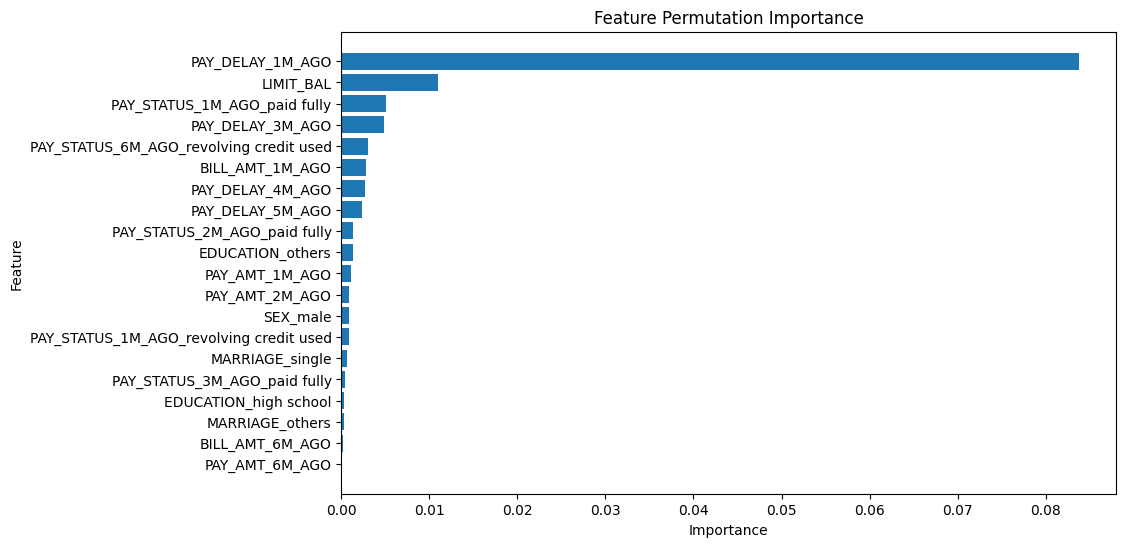

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_6M_AGO']

--- NEW ITERATION ---
Removing f

In [ ]:
lr2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   774  3799  874   553      46.97   58.33        81.30     76.22     52.03   
1   481  4185  488   846      49.64   36.25        89.56     77.77     41.90   
2   442  4222  451   885      49.50   33.31        90.35     77.73     39.82   
3   444  4204  469   883      48.63   33.46        89.96     77.47     39.64   
4   357  4316  357   970      50.00   26.90        92.36     77.88     34.98   
5   263  4427  246  1064      51.67   19.82        94.74     78.17     28.65   
6   208  4546  127  1119      62.09   15.67        97.28     79.23     25.03   
7    55  4644   29  1272      65.48    4.14        99.38     78.32      7.80   
8     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               69.81                 0   
1               62.90                 1   
2               61.83                 2   
3               61.71                 3   
4               59.63                 4   
5               57.28                 5   
6               56.48                 6   
7               51.76                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)


print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 21:07:12.245061

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   774  3799  874  553      46.97   58.33        81.30     76.22     52.03   
1   713  3724  949  614      42.90   53.73        79.69     73.95     47.71   
2   698  3799  874  629      44.40   52.60        81.30     74.95     48.15   
3   674  3839  834  653      44.69   50.79        82.15     75.22     47.55   
4   668  3853  820  659      44.89   50.34        82.45     75.35     47.46   
5   650  3865  808  677      44.58   48.98        82.71     75.25     46.68   
6   615  3974  699  712      46.80   46.35        85.04     76.48     46.57   
7   606  3983  690  721      46.76   45.67        85.23     76.48     46.21   
8   576  4045  628  751      47.84   43.41        86.56     77.02     45.52   
9   550  4103  570  777      49.11   41.45        87.80     77.55     44.95   
10  565  4083  590  762      48.92   42.58        87.37     77.47     45.53   
11  593  3974  699  734      45.90   44.69        85.04     76.12     45.28   
12  600  3959  714  727      45.66   45.21        84.72     75.98     45.44   
13  576  4042  631  751      47.72   43.41        86.50     76.97     45.46   
14  507  4213  460  820      52.43   38.21        90.16     78.67     44.20   
15  478  4269  404  849      54.20   36.02        91.35     79.12     43.28   
16  483  4246  427  844      53.08   36.40        90.86     78.82     43.18   
17  483  4243  430  844      52.90   36.40        90.80     78.77     43.12   
18  483  4260  413  844      53.91   36.40        91.16     79.05     43.45   
19  470  4275  398  857      54.15   35.42        91.48     79.08     42.82   
20  469  4271  402  858      53.85   35.34        91.40     79.00     42.68   

    balanced_accuracy  num_feat_missing  \
0               69.81                 0   
1               66.71                 1   
2               66.95                 2   
3               66.47                 3   
4               66.40                 4   
5               65.85                 5   
6               65.69                 6   
7               65.45                 7   
8               64.98                 8   
9               64.62                 9   
10              64.98                10   
11              64.86                11   
12              64.97                12   
13              64.95                13   
14              64.18                14   
15              63.69                15   
16              63.63                16   
17              63.60                17   
18              63.78                18   
19              63.45                19   
20              63.37                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...

In [ ]:
lr2_perf_temp, lr2_orig_missing_temp, lr2_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
8                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
29                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   774  3799   874   553      46.97   58.33         81.3     76.22     52.03   
1  1327     0  4673     0      22.12  100.00          0.0     22.12     36.22   
2     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   
3     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   
4     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   
5     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   
6     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   
7     0  4673     0  1327       0.00    0.00        100.0     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.81                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                12   
5              50.00                15   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_temp_mf, lr2_orig_missing_temp_mf, lr2_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 21:11:30.593511

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  774  3799  874   553      46.97   58.33        81.30     76.22     52.03   
1  623  3916  757   704      45.14   46.95        83.80     75.65     46.03   
2  660  3890  783   667      45.74   49.74        83.24     75.83     47.65   
3  588  4064  609   739      49.12   44.31        86.97     77.53     46.59   
4  580  3996  677   747      46.14   43.71        85.51     76.27     44.89   
5  563  4031  642   764      46.72   42.43        86.26     76.57     44.47   
6  500  4129  544   827      47.89   37.68        88.36     77.15     42.18   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              69.81                 0   
1              65.37                 4   
2              66.49                 5   
3              65.64                 8   
4              64.61                12   
5              64.34                15   
6              63.02                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Results comparison - Standard Scenario**



## **F1-score**

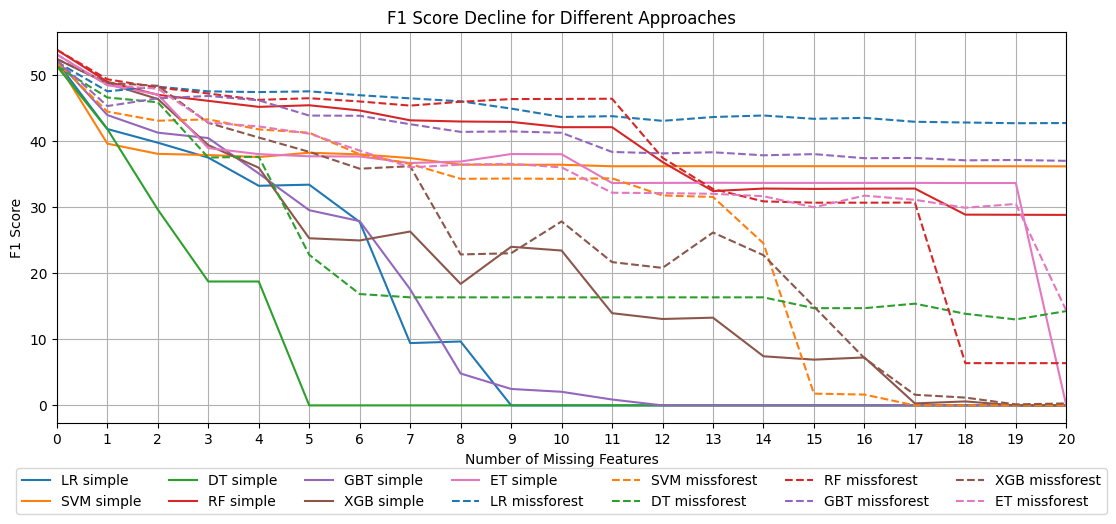

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

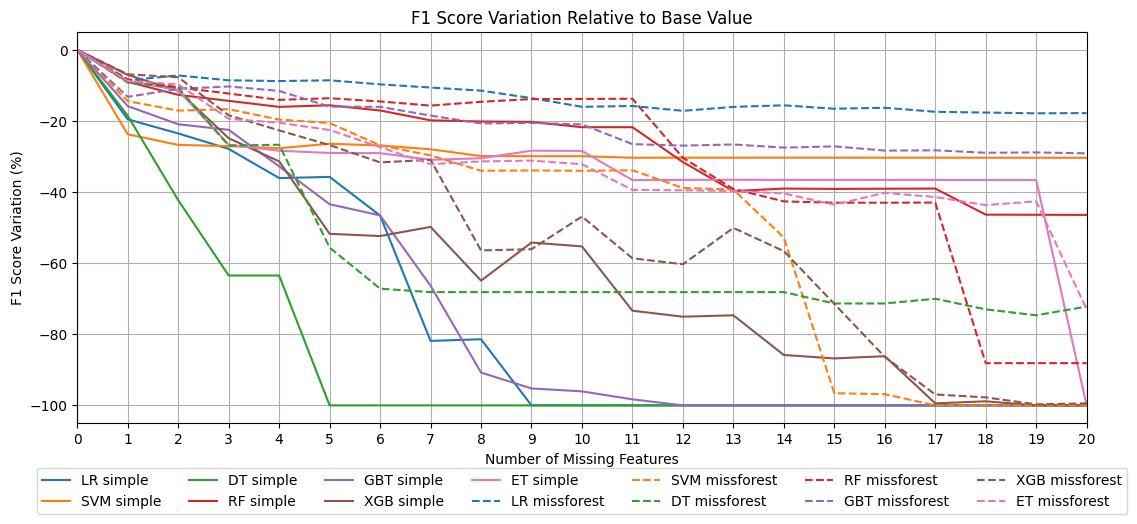

In [ ]:
# Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced accuracy**

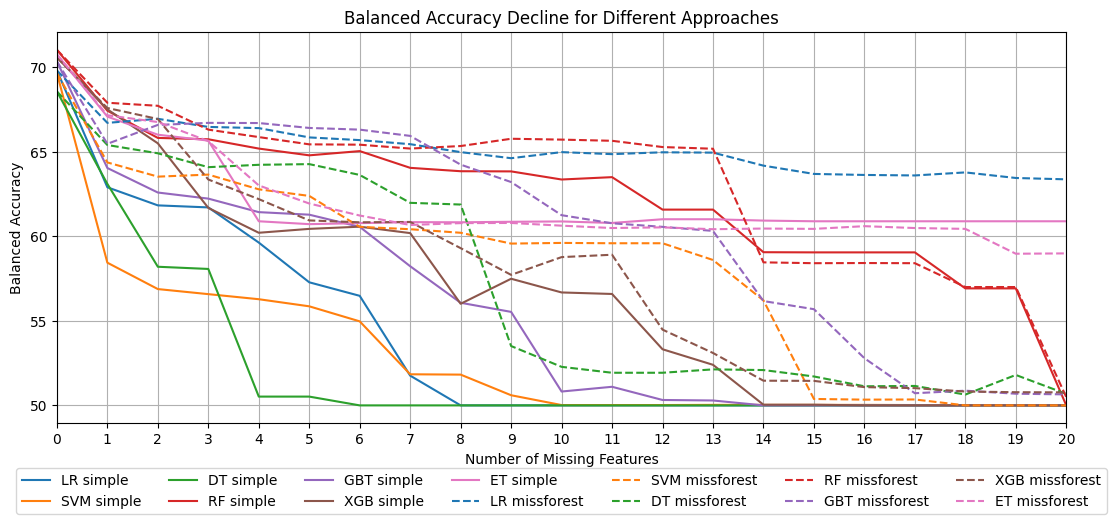

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

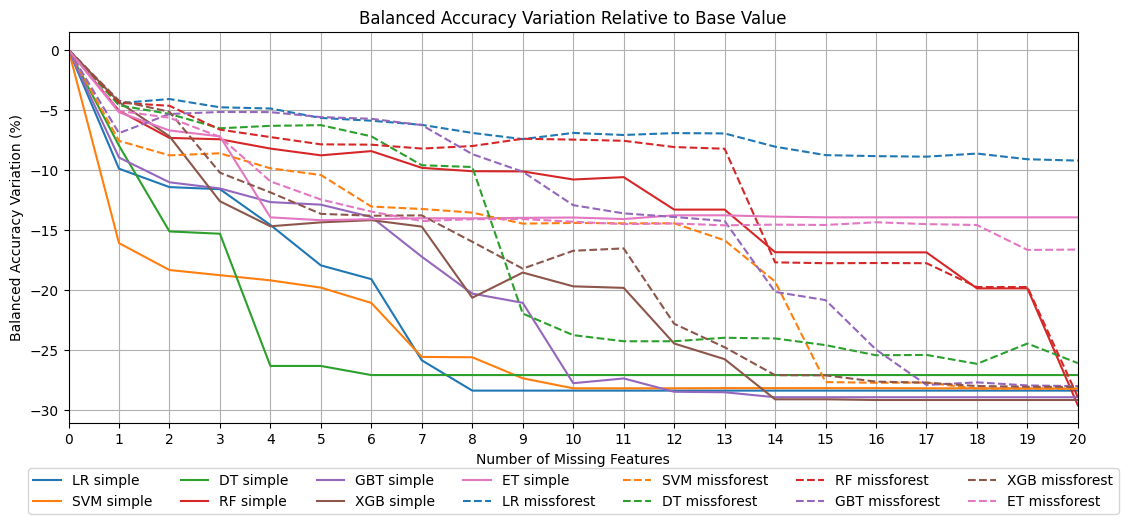

In [ ]:
# Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In this dataset there are few highly correlated variables (even considerind the ohe). So the ensemble models like Random Forests and Extra Trees do not benefit from the power of backup variables because they actually do not exist.

From the analysis of F1 and Balanced Accuracy, Decision Trees and XGBoost seem to be the less resilient to features missing.

# **Results comparison - Temporal Scenario**

## **F1-score**

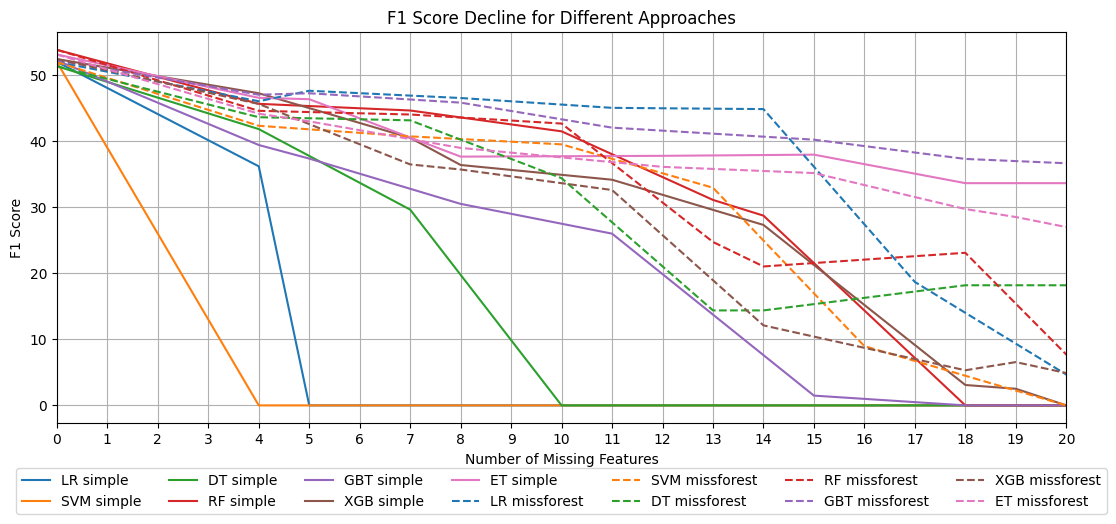

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf_temp['num_feat_missing'], lr_perf_temp['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf_temp['num_feat_missing'], svm_perf_temp['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf_temp['num_feat_missing'], dt_perf_temp['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf_temp['num_feat_missing'], rf_perf_temp['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf_temp['num_feat_missing'], gbt_perf_temp['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf_temp['num_feat_missing'], xgb_perf_temp['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf_temp['num_feat_missing'], et_perf_temp['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_temp_mf['num_feat_missing'], lr_perf_temp_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_temp_mf['num_feat_missing'], svm_perf_temp_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_temp_mf['num_feat_missing'], dt_perf_temp_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_temp_mf['num_feat_missing'], rf_perf_temp_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_temp_mf['num_feat_missing'], gbt_perf_temp_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_temp_mf['num_feat_missing'], xgb_perf_temp_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_temp_mf['num_feat_missing'], et_perf_temp_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

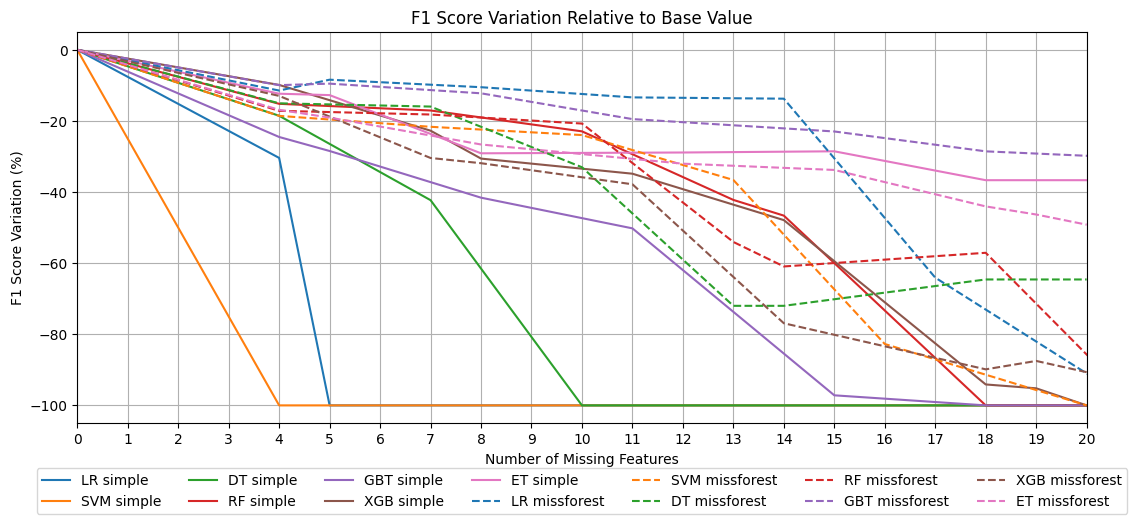

In [ ]:
# # Line plot for the f1 score variation relative to the base value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf_temp, svm_perf_temp, dt_perf_temp, rf_perf_temp, gbt_perf_temp, xgb_perf_temp, et_perf_temp,
     lr_perf_temp_mf, svm_perf_temp_mf, dt_perf_temp_mf, rf_perf_temp_mf, gbt_perf_temp_mf, xgb_perf_temp_mf, et_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Balanced accuracy**

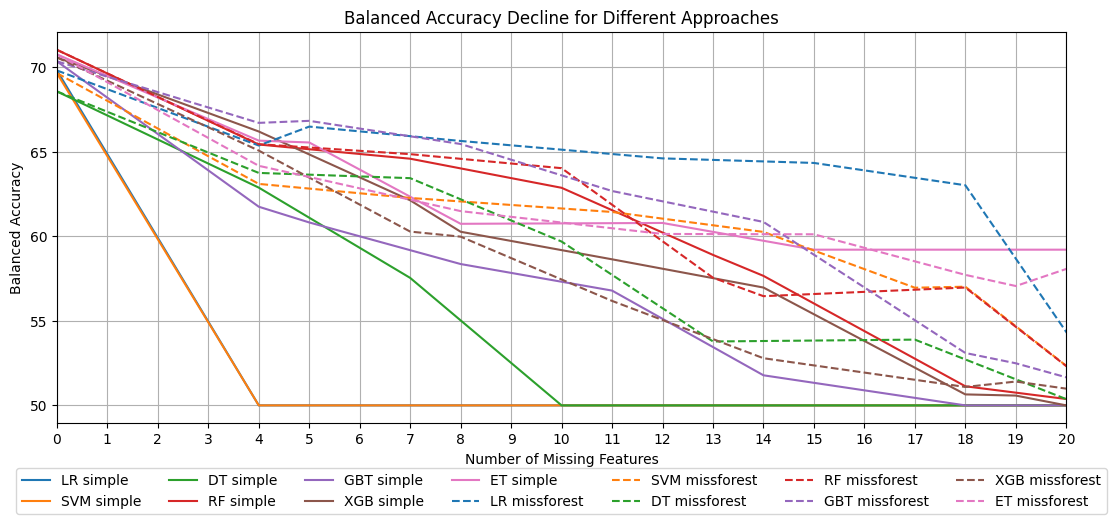

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf_temp['num_feat_missing'], lr2_perf_temp['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf_temp['num_feat_missing'], svm2_perf_temp['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf_temp['num_feat_missing'], dt2_perf_temp['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf_temp['num_feat_missing'], rf2_perf_temp['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf_temp['num_feat_missing'], gbt2_perf_temp['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf_temp['num_feat_missing'], xgb2_perf_temp['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf_temp['num_feat_missing'], et2_perf_temp['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_temp_mf['num_feat_missing'], lr2_perf_temp_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_temp_mf['num_feat_missing'], svm2_perf_temp_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_temp_mf['num_feat_missing'], dt2_perf_temp_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_temp_mf['num_feat_missing'], rf2_perf_temp_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_temp_mf['num_feat_missing'], gbt2_perf_temp_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_temp_mf['num_feat_missing'], xgb2_perf_temp_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_temp_mf['num_feat_missing'], et2_perf_temp_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

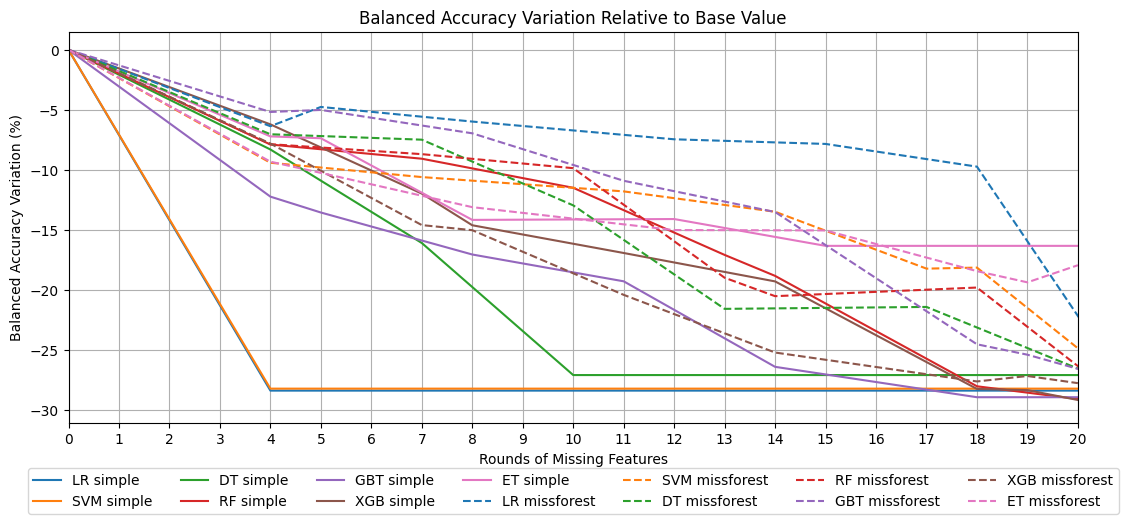

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the balanced accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf_temp, svm2_perf_temp, dt2_perf_temp, rf2_perf_temp, gbt2_perf_temp, xgb2_perf_temp, et2_perf_temp,
     lr2_perf_temp_mf, svm2_perf_temp_mf, dt2_perf_temp_mf, rf2_perf_temp_mf, gbt2_perf_temp_mf, xgb2_perf_temp_mf, et2_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base balanced accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Rounds of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf
}

all_data = combine_datasets(
    dataset_dict,
    'Default Credit Card', 'Scenario 2: drop intercorrelated',
    RANDOM_STATE
)
save_dataset(all_data, 'default_cc_scenario2_seed_2025.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset_temp_dict = {
    'lr_perf_temp': lr_perf_temp,
    'svm_perf_temp': svm_perf_temp,
    'dt_perf_temp': dt_perf_temp,
    'rf_perf_temp': rf_perf_temp,
    'gbt_perf_temp': gbt_perf_temp,
    'xgb_perf_temp': xgb_perf_temp,
    'et_perf_temp': et_perf_temp,
    'lr_perf_temp_mf': lr_perf_temp_mf,
    'svm_perf_temp_mf': svm_perf_temp_mf,
    'dt_perf_temp_mf': dt_perf_temp_mf,
    'rf_perf_temp_mf': rf_perf_temp_mf,
    'gbt_perf_temp_mf': gbt_perf_temp_mf,
    'xgb_perf_temp_mf': xgb_perf_temp_mf,
    'et_perf_temp_mf': et_perf_temp_mf,
    'lr2_perf_temp': lr2_perf_temp,
    'svm2_perf_temp': svm2_perf_temp,
    'dt2_perf_temp': dt2_perf_temp,
    'rf2_perf_temp': rf2_perf_temp,
    'gbt2_perf_temp': gbt2_perf_temp,
    'xgb2_perf_temp': xgb2_perf_temp,
    'et2_perf_temp': et2_perf_temp,
    'lr2_perf_temp_mf': lr2_perf_temp_mf,
    'svm2_perf_temp_mf': svm2_perf_temp_mf,
    'dt2_perf_temp_mf': dt2_perf_temp_mf,
    'rf2_perf_temp_mf': rf2_perf_temp_mf,
    'gbt2_perf_temp_mf': gbt2_perf_temp_mf,
    'xgb2_perf_temp_mf': xgb2_perf_temp_mf,
    'et2_perf_temp_mf': et2_perf_temp_mf
}

all_data_temp = combine_datasets(
    dataset_temp_dict,
    'Default Credit Card Temporal', 'Scenario 2: drop intercorrelated',
    RANDOM_STATE
)
save_dataset(all_data_temp, 'default_cc_temp_scenario2_seed_2025.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0    773  3802  871   554      47.02   58.25        81.36     76.25     52.04   
1    480  4187  486   847      49.69   36.17        89.60     77.78     41.87   
2    441  4225  448   886      49.61   33.23        90.41     77.77     39.80   
3    409  4230  443   918      48.00   30.82        90.52     77.32     37.54   
4    332  4336  337   995      49.63   25.02        92.79     77.80     33.27   
..   ...   ...  ...   ...        ...     ...          ...       ...       ...   
583  383  4315  358   944      51.69   28.86        92.34     78.30     37.04   
584  385  4298  375   942      50.66   29.01        91.98     78.05     36.90   
585  371  4342  331   956      52.85   27.96        92.92     78.55     36.57   
586  304  4441  232  1023      56.72   22.91        95.04     79.08     32.64   
587  304  4443  230  1023      56.93   22.91        95.08     79.12     32.67   

     balanced_accuracy  num_feat_missing  \
0                69.81                 0   
1                62.89                 1   
2                61.82                 2   
3                60.67                 3   
4                58.90                 4   
..                 ...               ...   
583              60.60                16   
584              60.49                17   
585              60.44                18   
586              58.97                19   
587              58.99                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1                         ['PAY_DELAY_1M_AGO'] imputed      lr_perf   
2            ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed      lr_perf   
3    ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...      lr_perf   
4    ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...      lr_perf   
..                                                 ...          ...   
583  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  et2_perf_mf   
584  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  et2_perf_mf   
585  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  et2_perf_mf   
586  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  et2_perf_mf   
587  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  et2_perf_mf   

                  source                          scenario  random_state  \
0    Default Credit Card  Scenario 2: drop intercorrelated          2025   
1    Default Credit Card  Scenario 2: drop intercorrelated          2025   
2    Default Credit Card  Scenario 2: drop intercorrelated          2025   
3    Default Credit Card  Scenario 2: drop intercorrelated          2025   
4    Default Credit Card  Scenario 2: drop intercorrelated          2025   
..                   ...                               ...           ...   
583  Default Credit Card  Scenario 2: drop intercorrelated          2025   
584  Default Credit Card  Scenario 2: drop intercorrelated          2025   
585  Default Credit Card  Scenario 2: drop intercorrelated          2025   
586  Default Credit Card  Scenario 2: drop intercorrelated          2025   
587  Default Credit Card  Scenario 2: drop intercorrelated          2025   

                metric  
0             f1 score  
1             f1 score  
2             f1 score  
3             f1 score  
4             f1 score  
..                 ...  
583  balanced accuracy  
584  balanced accuracy  
585  balanced accuracy  
586  balanced accuracy  
587  balanced accuracy  

[588 rows x 17 columns]

In [ ]:
all_data_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  \
0     773  3802   871   554      47.02   58.25        81.36     76.25   
1    1327     0  4673     0      22.12  100.00         0.00     22.12   
2       0  4673     0  1327       0.00    0.00       100.00     77.88   
3       0  4673     0  1327       0.00    0.00       100.00     77.88   
4       0  4673     0  1327       0.00    0.00       100.00     77.88   
..    ...   ...   ...   ...        ...     ...          ...       ...   
227   374  4304   369   953      50.34   28.18        92.10     77.97   
228   379  4284   389   948      49.35   28.56        91.68     77.72   
229   275  4426   247  1052      52.68   20.72        94.71     78.35   
230   250  4452   221  1077      53.08   18.84        95.27     78.37   
231   284  4427   246  1043      53.58   21.40        94.74     78.52   

     f1_score  balanced_accuracy  num_feat_missing  \
0       52.04              69.81                 0   
1       36.22              50.00                 4   
2        0.00              50.00                 5   
3        0.00              50.00                 8   
4        0.00              50.00                11   
..        ...                ...               ...   
227     36.14              60.14                12   
228     36.18              60.12                15   
229     29.75              57.72                18   
230     27.81              57.06                19   
231     30.59              58.07                20   

                                               imputed           dataset  \
0                                                           lr_perf_temp   
1    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
2    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
3    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
4    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
..                                                 ...               ...   
227  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
228  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
229  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
230  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
231  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   

                           source                          scenario  \
0    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
1    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
2    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
3    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
4    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
..                            ...                               ...   
227  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
228  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
229  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
230  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
231  Default Credit Card Temporal  Scenario 2: drop intercorrelated   

     random_state             metric  
0            2025           f1 score  
1            2025           f1 score  
2            2025           f1 score  
3            2025           f1 score  
4            2025           f1 score  
..            ...                ...  
227          2025  balanced accuracy  
228          2025  balanced accuracy  
229          2025  balanced accuracy  
230          2025  balanced accuracy  
231          2025  balanced accuracy  

[232 rows x 17 columns]